# California Schools Inquiry
By: Martín Mendoza-Ceja  
Project Durtaion: 3/28/24 - 4/8/24  
Last Updated: 7/20/2024 

**Update Log**
- **Update:** 5/4/24-5/22/24
     - Put all school years and grad/dropout rates into their own dataframe.
        - The need for a dataframe to be inputted in some functions was changed to int(i.e. the school year) or, in some cases, fully deprecated from a function call.
        - Removed the `distr_edu_facet` functions for gender and ethnicity as I didn't see any significant insight in the data it visualized
        - imported and utilized (2009-2023) Graduation/Dropout rates Dataset
        - Geographically plotted data: graduation/dropout rates by county in California.
        - Overall, made code more efficient and articulate.
    

    - **Update Note:**
    I did not work on this update for every day between 5/4-5/22. I worked on this update on certain days in the that time frame.

- **Update:** 7/20/24
    - Add disclaimer to the Graduation and Dropout rates projections. The disclaimer explaining the white colored counties are missing data or there was not data recorded for that county.

## Data Sources:
**Public Schools and Districts:** [Public Schools and Districts](https://www.cde.ca.gov/ds/si/ds/pubschls.asp) 

**(2007-2022)Enrollment:** [Census Day Enrollment by School](https://www.cde.ca.gov/ds/ad/filesenr.asp) 

**(2016-2023)Graduation/Dropout Rates:** [Four-Year Adjusted Cohort Graduation Rate and Outcome Data](https://www.cde.ca.gov/ds/ad/filesacgr.asp)

**(2009-2015)Graduation/Dropout Rates:** ["Historical" Four-Year Adjusted Cohort Graduation Rate and Outcome Data](https://www.cde.ca.gov/ds/ad/filescohort.asp)

**California broken into up by its counties:** [California Counties](https://hub.arcgis.com/datasets/CALFIRE-Forestry::california-counties/about)


## Goals
- Make insightful querying functions.
- Make a function that can predict the enrollment for district/school.
- Make a function that can forecast the enrollment for a district/school.
- Use querying functions on some of the top cities in California.
- Geographically plot the graduation and dropout rates for California by county.


In [3]:
import numpy as np #allows for efficient calculations and manipulation with arrays
import pandas as pd #allows for the use of dataframes and quick insight to the dataset
import matplotlib.pyplot as plt #used with seaborn also allows for object-oriented plotting
import seaborn as sns # allows for visualizations
import regex as re # mainly used for acquiring numbers from strings
import geopandas as gpd #allows for geospatial analysis
from shapely.geometry import Point #converts lat and long values to geometries
# allows for dynamic and interactive plots
import plotly.express as px
from ipywidgets import interact
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

In [4]:
# set plot style
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 4

colors_facet = ['r','g','b','m','darkcyan','k','#800080','#bf4d24','darkgoldenrod']


## Loading in The Dataets

In [5]:
# shapefile with California and its counties
ca_counties = gpd.read_file("California_Counties/cnty19_1_basicplus.shp")


In [6]:
# General dataset of schools in CA
cde_df = pd.read_csv('pubschls.xlsx - Public Schools and Districts.csv')

In [7]:

# The rates data sets have to be in the format 'Graduation_Rate_Outcome_xx-xx.csv'
# (e.g.'Graduation_Rate_Outcome_22-23.csv')
# 'old' years rate data (i.e. < 2016)

rate_files_old = ['rates_data/Graduation_Rate_Outcome_09-10.csv',
                  'rates_data/Graduation_Rate_Outcome_10-11.csv',
              'rates_data/Graduation_Rate_Outcome_11-12.csv',
              'rates_data/Graduation_Rate_Outcome_12-13.csv',
              'rates_data/Graduation_Rate_Outcome_13-14.csv',
              'rates_data/Graduation_Rate_Outcome_15-16.csv']


rate_dfs_old = []


for file in rate_files_old:
     df = pd.read_csv(file,low_memory=False)
     rate_dfs_old.append(df)



In [8]:

# recent years rate data (i.e. 2016+)
rate_files = ['rates_data/Graduation_Rate_Outcome_16-17.csv',
              'rates_data/Graduation_Rate_Outcome_17-18.csv',
              'rates_data/Graduation_Rate_Outcome_18-19.csv',
              'rates_data/Graduation_Rate_Outcome_19-20.csv',
              'rates_data/Graduation_Rate_Outcome_20-21.csv',
              'rates_data/Graduation_Rate_Outcome_21-22.csv',
              'rates_data/Graduation_Rate_Outcome_22-23.csv']


rate_dfs = []


for file in rate_files:
     df = pd.read_csv(file,low_memory=False)
     rate_dfs.append(df)



In [9]:

# the enrollment data sets have to be in the format 'Enrxx-xx.csv' (e.g.'Enr07-08.csv')
enr_files = ['enrollment_data/Enr07-08.csv','enrollment_data/Enr08-09.csv','enrollment_data/Enr09-10.csv',
             'enrollment_data/Enr10-11.csv','enrollment_data/Enr11-12.csv','enrollment_data/Enr12-13.csv',
             'enrollment_data/Enr13-14.csv','enrollment_data/Enr14-15.csv','enrollment_data/Enr15-16.csv',
             'enrollment_data/Enr16-17.csv','enrollment_data/Enr17-18.csv','enrollment_data/Enr18-19.csv',
             'enrollment_data/Enr19-20.csv','enrollment_data/Enr20-21.csv' ,'enrollment_data/Enr21-22.csv',
             'enrollment_data/Enr22-23.csv']

enr_dfs = []


for file in enr_files:
    df = pd.read_csv(file,low_memory=False)
    enr_dfs.append(df)




## Cleaning the Datasets



### Public Schools and Districts Cleaning

In [10]:


rel_clean_cde = cde_df.drop(['CDSCode', 'NCESDist', 'NCESSchool','MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'FaxNumber', 'Email', 'WebSite','EdOpsCode', 'EdOpsName','Magnet','FederalDFCDistrictID','AdmEmail','State','CharterNum','Zip','Street','GSserved','SOC'],axis=1) #remove irrelevant columns


fr_clean_cde = rel_clean_cde[ (rel_clean_cde['SOCType'] != 'No Data') & (rel_clean_cde['EILCode'] != 'No Data') & (rel_clean_cde['EILName'] != 'No Data') ]
al_clean_cde = fr_clean_cde.dropna()
reset_cde = al_clean_cde.reset_index()
reset_cde.columns = reset_cde.columns.str.lower()

# replace code values with respective education system

reset_cde['doc'] = [('County Office of Education' if i  == '00' else
                    'State Board of Education' if i  == '02' else
                    'Statewide Benefit Charter' if i  == '03' else
                    'State Special Schools' if i  == '31' else
                    'Non-school Location' if i  == '34' else
                    'Elementary School District' if i  == '52' else
                    'Unified School District' if i  == '54' else
                    'High School District' if i  == '56' else 'Regional Occupation Center') for i in reset_cde['doc']]




la_clean_cde_closed = reset_cde.drop('index',axis=1) #with schools that are open and closed

#dataframe with schools that are still open 
la_clean_cde_open = la_clean_cde_closed[la_clean_cde_closed['statustype'] != 'Closed'] 



### Cleaning Graduation/Dropout Rates Data
**Context:**  
CDE (owners of the data) changed their methodology when recording the data for cohort graduation rate and outcome data around 2015-2016. So, the structure of the dataframes of the timeframe after 2016 changed. Having imported the data before the change, I will clean the dataframes for those years (i.e., 2009-2015) to ultimately fit into a dataframe with the recent years.  
Also, when cleaning this data I realized that the county Alpine tends to have its data suppressed. So, it will be labeled as suppressed in map out drop from the working data frames.

In [11]:
def clean_rate_old(df):
    """
    dataframe -> dataframe
    expects a grad/dropout df that falls in the years 2009-2015
    returns the dataframe in the clean form
   
    """


    temp_df = df
    temp_df.columns = temp_df.columns.str.lower()
    # get the rows that are aggregated for the county
    county_lvl = temp_df.loc[(temp_df['agglevel'] == 'O') & (temp_df['subgroup'] == 'All') ].reset_index().drop(columns='index')
    df_len = len(county_lvl)
    # replace the suppressed data('*') with zero
    county_lvl['numcohort']  = ['0' if county_lvl.numcohort[i] == '*' else county_lvl.numcohort[i] for i in np.arange(df_len)]
    county_lvl['numgraduates']  = ['0' if county_lvl.numgraduates[i] == '*' else county_lvl.numgraduates[i] for i in np.arange(df_len)]
    county_lvl['numdropouts']  = ['0' if county_lvl.numdropouts[i] == '*' else county_lvl.numdropouts[i] for i in np.arange(df_len)]

    # obtain relevant columns

    county_lvl = county_lvl[['year','name','numcohort','numgraduates','numdropouts']]

    # have the year value be in the format 20xx-xx
    county_lvl['year'] = [county_lvl.year[i] + 200000 for i in np.arange(df_len)]

    # convert datatypes accordingly
    county_lvl.year = county_lvl.year.astype(str)
    county_lvl.numcohort = county_lvl.numcohort.astype(int)
    county_lvl.numgraduates = county_lvl.numgraduates.astype(int)
    county_lvl.numdropouts = county_lvl.numdropouts.astype(int)

    # add a - between the school year value

    county_lvl['year']   = [re.sub('(\d+)(\d{2})',r'\1-\2',year) for year in county_lvl.year]

    # manipulate a data frame with each county with their total rates for grad and dropout    
    # groupby to acquire the sum of total students,grads, and dropouts for each county
    rate_df = county_lvl.groupby(by='name').sum().reset_index()#.drop(1)

    

    grad_rate = [round(rate_df.numgraduates[i]/rate_df.numcohort[i] * 100,2) for i in np.arange(len(rate_df))]
    dropout_rate = [round(rate_df.numdropouts[i]/rate_df.numcohort[i] * 100,2) for i in np.arange(len(rate_df))]


    # create the final returning dataframe
    rate_df = pd.DataFrame({'county':rate_df.name,
                       'academic_year':county_lvl.year[0],
                       'total_students':rate_df.numcohort,
                       'graduate_count':rate_df.numgraduates,
                       'dropout_count':rate_df.numdropouts,
                        'graduate_rate':grad_rate,
                       'dropout_rate':dropout_rate})

    # drop the county Alpine
    rate_df = rate_df.drop(1).reset_index().drop(columns='index')
    return rate_df


In [12]:
# put all old clean cde rates dataframes into one dataframe
clean_rates_old = [clean_rate_old(df) for df in rate_dfs_old]

cde_rates_old = pd.concat(clean_rates_old).reset_index().drop('index',axis=1)


In [13]:
def clean_rate_new(df):
    """
    dataframe -> dataframe
    expects a grad/dropout df in the years 2016-2023
    returns the dataframe in the clean form
   
    """
    # Filter the dataset for total total aggregates value for a school
    
    rate_df = df.loc[(df['AggregateLevel'] == 'S') | (df['ReportingCategory'] == 'TA') ]
    # extract relevant columns
    rate_df = rate_df[['AcademicYear','CountyName','DistrictName','SchoolName','CohortStudents','Regular HS Diploma Graduates (Count)',
                      'Regular HS Diploma Graduates (Rate)','Dropout (Count)','Dropout (Rate)']]

    # standarize column names
    rate_df.columns = [re.sub(r'([a-z])([A-Z])', r'\1_\2',col) for col in rate_df.columns]
    rate_df.rename(columns={'Cohort_Students':'total_students','County_Name':'county',
                        'Regular HS Diploma Graduates (Count)':'graduate_count',
                       'Regular HS Diploma Graduates (Rate)':'graduate_rate',
                       'Dropout (Count)':'dropout_count',
                       'Dropout (Rate)':'dropout_rate'},inplace=True)
    # lowercase column names
    rate_df.columns = rate_df.columns.str.lower()


    # drop nan values
    rate_df.dropna(inplace=True)
    #drop rows that have '*' as the value (suppressed data)
    rate_df = rate_df.drop(rate_df[rate_df['total_students'] == '*'].index)
    # convert numerical data to its respective type 
    rate_df['total_students'] = rate_df['total_students'].astype(int)
    rate_df['graduate_count'] = rate_df['graduate_count'].astype(int)
    rate_df['graduate_rate'] = rate_df['graduate_rate'].astype(float)
    rate_df['dropout_count'] = rate_df['dropout_count'].astype(int)
    rate_df['dropout_rate'] = rate_df['dropout_rate'].astype(float)
    #manipulate a data frame with each county with their total rates for grad and dropout    
    # groupby to acquire the sum of total students,grads, and dropouts for each county
    scaff_df = rate_df.groupby(by='county').sum().reset_index()
    # fix the academic_year value
    scaff_df['academic_year'] = list(rate_df.academic_year)[0]
    # select relevant columns
    county_rates  = scaff_df[['county','academic_year','total_students','graduate_count','dropout_count']]

    # calculate and add rate columns
    county_rates['graduate_rate'] = [round(county_rates.graduate_count[i]/county_rates.total_students[i] * 100,2) for i in np.arange(len(county_rates))]
    county_rates['dropout_rate'] = [round(county_rates.dropout_count[i]/county_rates.total_students[i] * 100,2) for i in np.arange(len(county_rates))]
    
    return county_rates


In [14]:
# put all clean cde rates dataframes into one dataframe
clean_rates_new = [clean_rate_new(df) for df in rate_dfs]

cde_rates_new = pd.concat(clean_rates_new).reset_index().drop('index',axis=1)



In [15]:
# Dataframe for grad/dropout rates for 2009-2023 
cde_rates = pd.concat([cde_rates_old,cde_rates_new])



### Enrollment Cleaning

In [16]:
#store the relevant enrollment years
recent_year = 2023 #change the value of this to the most recent year 
#(i.e. 2023 is recent because 2022-2023 was the last shcool year with published data)
enr_years = np.arange(2007,recent_year)


In [17]:
def clean_enr(file_name):
    """
    string -> dataframe
    expects a enrollment file name
    returns the dataframe in the clean form
   
    """
    enr_raw = enr_dfs[enr_files.index(file_name)].drop(['CDS_CODE','ADULT','UNGR_SEC','UNGR_ELM'],axis=1) #remove irrelevant columns
    enr_raw.columns = enr_raw.columns.str.lower()
    enr_raw['ethnic'] = [('American Indian or Alaska Native' if i == 1 
                      else 'Asian' if i == 2 
                      else 'Pacific Islander' if i == 3 
                      else 'Filipino' if i == 4 
                      else 'Hispanic or Latino' if i == 5 
                      else 'African American' if i == 6 
                      else 'White' if i == 7 
                      else 'Mixed' if i == 9 
                      else 'Not Reported') for i in enr_raw['ethnic']] # replace code value with respective race

    enr_raw['gender'] = [('Female' if i == 'F' 
                     else 'Male' if i == 'M'
                     else 'Non-Binary' if i == 'X'
                     else 'Missing') for i in enr_raw['gender']]  # replace code value with respective gender
    rel_enr = enr_raw
    rel_enr['year'] = int(re.findall('\d+',file_name)[0]) + 2000 # will work as long as file_name is correctly formatted
    return rel_enr


In [18]:
#store the cleaned data frames in this variable and then put each data frame in a variable
enr_years_cleaned = [clean_enr(i) for i in enr_files]
# The cleaned enrollment data sets all in one dataframe
# main working df that will be in most function bodies
cde_enrolloment = pd.concat(enr_years_cleaned)


In [19]:
# store each school year dataframe in list, can help in iteration when analyzing trends
 # filter for every unique year 
cde_enrolloment_yearly = [cde_enrolloment.loc[cde_enrolloment['year'] == year] for year in enr_years]




### GeoProcessing

#### GeoDataFrame of counties and their respective grad/dropout rates for the school years in 2016-2023

In [20]:
# Remove schools that don't have a lat and lon value and are closed
# Also, acquire the schools that have a year 12(which subsequently leads to graduation) 
la_clean_cde_open = la_clean_cde_closed[(la_clean_cde_closed.latitude != 'No Data') &
                                       (la_clean_cde_closed.longitude != 'No Data')& 
                                        (la_clean_cde_closed.statustype	!= 'Closed')&
                                        (la_clean_cde_closed.gsoffered.str.contains('12'))] 

# cast lat and long as floats
la_clean_cde_open.latitude = la_clean_cde_open.latitude.astype(float)
la_clean_cde_open.longitude = la_clean_cde_open.longitude.astype(float)

# add a geometry column(i.e. add the point where each school lays)
la_clean_cde_open['geometry'] = [Point(xy) for xy in zip(la_clean_cde_open.longitude,la_clean_cde_open.latitude)]
# cast as a geodataframe
geo_cde = gpd.GeoDataFrame(la_clean_cde_open)

In [21]:
# join the cde_rates and geo_cde
# to have the schools all fall under one point(i.e. the county)
# The stats correspond to the county and the geometry corresponds to the schools
geo_cde_rates =  geo_cde.merge(cde_rates)
geo_cde_rates =  geo_cde_rates[['academic_year','county',
                                'total_students','graduate_count','graduate_rate','dropout_count','dropout_rate',
                                'district','city','school','gsoffered','geometry']]

geo_cde_rates.head(1)


academic_year   county  total_students  graduate_count  graduate_rate  \
0       2009-10  Alameda           35578           26954          75.76   

   dropout_count  dropout_rate                            district     city  \
0           6094         17.13  Alameda County Office of Education  Oakland   

                                   school gsoffered  \
0  Envision Academy for Arts & Technology      6-12   

                      geometry  
0  POINT (-122.26815 37.80452)

In [22]:

def geo_county(county):
    """
    string -> dataframe
    expects a county name
    returns a dataframe with the geometry for that county and stats respective to that county(i.e. grad/dropout rates)
    """
    # spatial join to manipulate a data frame that has the points that fall in each county
    county_df = geo_cde_rates.loc[geo_cde_rates['county'] == county]
    geom_county = ca_counties.loc[ca_counties['COUNTY_NAM'] == county]
    county_points = gpd.sjoin(county_df,geom_county,how='right')
    county_points = county_points[['academic_year','county','total_students','graduate_count','graduate_rate','dropout_count',
                                  'dropout_rate','geometry']].reset_index().drop(columns='index')
    
    return county_points


In [23]:
# takes ~30sec to load
# create one data frame with all counties and their geometry
# store the counties
counties = pd.unique(cde_rates.county)
# use the function above to have a dataframe for each county 
# The duplicates were due to how the rows in the cde_rates df were assigned for a certain school which caused repeats in the time frame(2016-2023)
geo_counties = [geo_county(county) for county in counties]
# NTS: using the drop_duplicates method added nan values when slicing did not 
geo_county_df = pd.concat(geo_counties).drop_duplicates().reset_index().drop(columns='index').dropna()


In [24]:
# convert column values accordingly
geo_county_df.total_students = geo_county_df.total_students.astype(int)
geo_county_df.graduate_count = geo_county_df.graduate_count.astype(int)
geo_county_df.dropout_count = geo_county_df.dropout_count.astype(int)

In [25]:
#working df for geospatial analysis
geo_county_df.head(22) # first two counties

academic_year   county  total_students  graduate_count  graduate_rate  \
0        2009-10  Alameda           35578           26954          75.76   
1        2010-11  Alameda           33982           26506          78.00   
2        2011-12  Alameda           34226           27308          79.79   
3        2012-13  Alameda           34518           27882          80.78   
4        2015-16  Alameda           33318           28556          85.71   
5        2016-17  Alameda          316558          266416          84.16   
6        2017-18  Alameda          331922          284178          85.62   
7        2018-19  Alameda          327718          280550          85.61   
8        2019-20  Alameda          334362          286814          85.78   
9        2020-21  Alameda          336102          287342          85.49   
10       2021-22  Alameda          136217          119720          87.89   
11       2022-23  Alameda          137488          119239          86.73   
12       2009-10   Amador             849             730          85.98   
13       2010-11   Amador             825             707          85.70   
14       2011-12   Amador             703             625          88.90   
15       2012-13   Amador             696             582          83.62   
16       2015-16   Amador             622             547          87.94   
17       2016-17   Amador            5820            5092          87.49   
18       2017-18   Amador            6164            5548          90.01   
19       2018-19   Amador            5464            4836          88.51   
20       2019-20   Amador            6076            5492          90.39   
21       2020-21   Amador            6052            5432          89.76   

    dropout_count  dropout_rate  \
0            6094         17.13   
1            5134         15.11   
2            4500         13.15   
3            3848         11.15   
4            2854          8.57   
5           27600          8.72   
6           26722          8.05   
7           27988          8.54   
8           26348          7.88   
9           27093          8.06   
10          10051          7.38   
11          10803          7.86   
12             61          7.18   
13             89         10.79   
14             47          6.69   
15             80         11.49   
16             60          9.65   
17            544          9.35   
18            228          3.70   
19            300          5.49   
20            112          1.84   
21            288          4.76   

                                             geometry  
0   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
1   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
2   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
3   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
4   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
5   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
6   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
7   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
8   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
9   POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
10  POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
11  POLYGON ((-122.27125 37.90503, -122.27024 37.9...  
12  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
13  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
14  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
15  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
16  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
17  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
18  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
19  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
20  POLYGON ((-120.07246 38.70276, -120.07249 38.6...  
21  POLYGON ((-120.07246 38.70276, -120.07249 38.6...

## Querying Functions
The functions below are mainly helper functions used later in the functions that output plots

##### parameter/functions labeling context:
- `school_year`: the year the school year started (e.g. 2014-2015, school_year = 2014)
- `distr`: distribution
- `edu`: school or district
- `is_district` by default is set to True meaning that `edu` expects a district name, in the case of when querying for a school `is_district` should be set to False in the function call, `is_district=False`

In [26]:

def search(edu,is_district=True):
    """"
    string is_district=boolean -> array([str])
    search to see if an edu is in a desired school year
    expects an edu 
    returns an array with the possible 
    matches of what the user is looking for.
    """
    
    # These lists contain the edu that the user may be looking for
    if is_district:
        district_list = pd.unique(cde_enrolloment.loc[cde_enrolloment.district.str.contains(edu,na=False)].district)
        return district_list
    else:
        school_list = pd.unique(cde_enrolloment.loc[cde_enrolloment.school.str.contains(edu,na=False)].school)
        return school_list




In [27]:

def get_enr_total(school_year,edu,is_district=True):
    """
    int string is_district=boolean -> string
    expects the school year and an edu
    returns a statement of how the total enrollment for that given edu in the given school year
    
    """
    # filter for the given school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    school_year_lsuffix = school_year_df.year[0]
    school_year_rsuffix = school_year_df.year[0]+1
    # locate the edu 
    if is_district:
        spec_edu = school_year_df.loc[school_year_df.district == edu]
        total = np.sum(spec_edu['enr_total'])
        
    else:
        spec_edu = school_year_df.loc[school_year_df.school == edu]
        total = np.sum(spec_edu['enr_total'])
    # state the total enrollment for the given edu
    return 'There was '+str(total) + ' students enrolled in '+edu+' ('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')'
    
    


In [28]:


def male_gender_counts(school_year,edu,is_district=True):
    """
    int string is_district=boolean -> int
    expects the school year and an edu
    returns the count of male students in the given edu
    
    """
    # filter for the main enrollment data frame for the inputted school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    # accounts for a district argument
    
    if is_district: 
        male_counts = school_year_df.loc[(school_year_df['gender'] == 'Male') & (school_year_df['district'] == edu) ]
        male_total = male_counts['enr_total'].sum()
    # accounts for a school argument
    else:
        male_counts = school_year_df.loc[(school_year_df['gender'] == 'Male') & (school_year_df['school'] == edu)]
        male_total = male_counts['enr_total'].sum()
    return male_total


def female_gender_counts(school_year,edu,is_district=True):
    """
    int string is_district=boolean -> int
    expects the school year and an edu
    returns the count of female students in the given edu
    
    """
    # filter for the main enrollment data frame for the inputted school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    
    # accounts for a district argument
    if is_district: 
        female_counts = school_year_df.loc[(school_year_df['gender'] == 'Female') & (school_year_df['district'] == edu)]
        female_total = female_counts['enr_total'].sum()
    # accounts for a school argument
    else:
        female_counts = school_year_df.loc[(school_year_df['gender'] == 'Female') & (school_year_df['school'] == edu)]
        female_total = female_counts['enr_total'].sum()
    return female_total


def non_binary_counts(school_year,edu,is_district=True):
    """
    int string is_district=boolean -> int
    expects the school year and an edu
    returns the count of non-binary students in the given edu
    
    """
    # filter for the main enrollment data frame for the inputted school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    # accounts for a district argument 
    # non-binary data didn't occur until 2019+
    if is_district and school_year_df.year[0] > 2018:
        non_binary_counts = school_year_df.loc[(school_year_df['gender'] == 'Non-Binary') & (school_year_df['district'] == edu)]
        non_binary_total = non_binary_counts['enr_total'].sum()
    # accounts for a school argument
    else: 
        non_binary_counts = school_year_df.loc[(school_year_df['gender'] == 'Non-Binary') & (school_year_df['school'] == edu)]
        non_binary_total = non_binary_counts['enr_total'].sum()
    return non_binary_total



In [29]:

def enr_school_year(school_year):
    """
    int -> dataframe
    expects a school year
    returns a dataframe with the total enrollment for every school in the given school year
    """
    # filter for the main enrollment data frame for the inputted school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    # obtain the total enrollment column for every school 
    enr_total = school_year_df.groupby(['school'])['enr_total'].sum()
    # create a concise dataframe
    out_df = pd.DataFrame({'enr_total':enr_total,'year':school_year}).reset_index()
    return out_df



In [30]:

def enr_per_school(school_year,district_name):

    """
    int string -> DataFrame
    expects a school year and district name
    returns a dataframe with the total enrollment for every school in the given district

    """
    # filter for the main enrollment data frame for the inputted school year and district
    school_year_df = cde_enrolloment.loc[(cde_enrolloment.year == school_year) & (cde_enrolloment.district == district_name)]
    # obtain the total enrollment column for every school 
    enr_total = school_year_df.groupby(['school'])['enr_total'].sum()

    # create a concise dataframe
    out_df = pd.DataFrame({'district':district_name,'enr_total':enr_total,'year':school_year}).reset_index()
    return out_df


In [31]:

def total_enrl_yearly(edu,is_district=True):
    """
    string is_district=boolean -> dataframe
    total enrollment for each year for the given edu
    expects an edu and returns the total enrollment for each year for the given edu in dataframe
    
    """
    if is_district:
        # create a dataframe with years
        enrl_total = pd.DataFrame({'year':enr_years})
        # add a total enrollment column
        enrl_total['total_enrl'] = [enr_per_school(i,edu).enr_total.sum() for i in enr_years]
        # cast enrollment as int
        enrl_total.total_enrl = enrl_total.total_enrl.astype(int)
        
    else:
        enrl_total = pd.DataFrame({'year':enr_years})
        
        enrl_total['total_enrl'] = [list(enr_school_year(i).loc[enr_school_year(i).school == edu ].enr_total)[0] 
                                      if  len(enr_school_year(i).loc[enr_school_year(i).school == edu ].enr_total) > 0 
                                      else None # Some school dont have data in certain years this code accounts for those cases
                                      for i in enr_years]
        # replace nan values with zeros 
        enrl_total = enrl_total.fillna(0)
        # cast enrollment as int
        enrl_total.total_enrl = enrl_total.total_enrl.astype(int)
    return enrl_total

total_enrl_yearly('Lincoln (Abraham) High',is_district=False).head(8) #example call and output


year  total_enrl
0  2007           0
1  2008           0
2  2009           0
3  2010           0
4  2011        2020
5  2012        2010
6  2013        1958
7  2014        2027

## Querying Functions that Output Plots
These functions can be best for getting the quick insights. I recommend using the  `search` function when starting your query to check if the EDU you are looking for is present. Also, I recommend using `total_enr_dist` to get an idea of the top schools in the district you are interested in.

### Trend for Enrollment in an EDU (2007-2023)

In [32]:

def trend_enroll(edu,is_district=True):
    """
    string is_district=boolean -> plot
    expects an edu 
    returns a line plot of the trend in total enrollment for the given edu
    
    """
    # manipulate the data into a data frame for the line plot
    if is_district:
        plt.figure(figsize=(10,6))
        # dataframe with enrollment values for 2007-2022
        total_enr_yearly_df = total_enrl_yearly(edu)
        # plotting
        sns.lineplot(data=total_enr_yearly_df,x='year',y='total_enrl') 
        plt.title('Enrollment Trend, '+ edu) 
        plt.xlabel('Year') 
        plt.ylabel('Total Enrollment') 
        plt.ylim(0)
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        # dataframe with enrollment values for 2007-2022
        total_enr_yearly_df = total_enrl_yearly(edu,is_district=False)
        # plotting
        sns.lineplot(data=total_enr_yearly_df,x='year',y='total_enrl') 
        plt.title('Enrollment Trend, '+ edu) 
        plt.xlabel('Year') 
        plt.ylabel('Total Enrollment') 
        plt.ylim(0)
        plt.show() 
    


### Trend for Enrollment Between two edu's(2007-2023)

In [33]:

def trend_two_edu(edu1,edu2,is_district=True):
    """
    string string is_district=boolean -> plot
    expects two districts or schools (there has to be two of each can't be a district and school)  
    returns a line plot of the trend in total enrollment for the given edu's
    """
    
    
    if is_district:
         # accquire the total enrollment for both edu's (schools)
        total_enr_edu1 = total_enrl_yearly(edu1)
        total_enr_edu2 = total_enrl_yearly(edu2)
        # plotiing
        plt.figure(figsize=(10,6))
        sns.lineplot(data=years_total,x='year',y=edu1,label=edu1) 
        sns.lineplot(data=years_total,x='year',y=edu2,label=edu2) 
        plt.title('Enrollment Trend for '+ edu1+' and '+edu2) 
        plt.xlabel('Year') 
        plt.ylabel('Total Enrollment') 
        plt.legend(fontsize="large")
        plt.ylim(0)
        plt.show()
    else:
        # accquire the total enrollment for both edu's (schools)
        total_enr_edu1 = total_enrl_yearly(edu1,is_district=False)
        total_enr_edu2 = total_enrl_yearly(edu2,is_district=False)
        # plotiing
        plt.figure(figsize=(10,6))
        sns.lineplot(data=total_enr_edu1,x='year',y='total_enrl',label=edu1) 
        sns.lineplot(data=total_enr_edu2,x='year',y='total_enrl',label=edu2) 
        plt.title('Enrollment Trend for '+ edu1+' and '+edu2) 
        plt.xlabel('Year') 
        plt.ylabel('Total Enrollment') 
        plt.legend(fontsize='large')
        plt.ylim(0)
        plt.show() 



### Bar Plot of Total Enrollment for Each School in a District in school year

In [34]:

def total_enr_dist(school_year,district,amount=10):
    
    """
    int string amount=int -> plot
    expects a school year
    returns a barplot of the count of total enrollment in the given district.
    the optional argument `amount=` which by default selects the top 10 schools in enrollment for the given district
    assign this parameter with a desired amount to see a specific amount of schools
    """
    # Sort the school with by total enrollment in the given district
    df_ready = enr_per_school(school_year,district).sort_values(by='enr_total',ascending=False).reset_index().iloc[:amount]
    df_year = df_ready.year[0]
    plt.figure(figsize=(15,10)) 
    sns.barplot(data=df_ready,y='school',x='enr_total') 
    plt.title('Total Enrollment per School in '+district+' ('+str(df_year)+'-'+str(df_year+1)+')',fontdict={'fontsize': 36}) 
    plt.xlabel('Total Count of Enrollemnt',fontdict={'fontsize': 20}) 
    plt.ylabel('School',fontdict={'fontsize': 20}) 
    
    plt.show()



## Distributions of Gender/Ethnicity in a District/School

### Gender Distributions

In [35]:

def gender_stat(school_year,edu,is_district=True):
    """
    dataframe string is_district=boolean -> string plot
    expects a school year
    returns a barplot of the count of each gender in a given edu and a statistical statement
    
    """

    # filter for the main enrollment data frame for the inputted school year
    school_year_df = cde_enrolloment.loc[cde_enrolloment.year == school_year]
    
    if is_district:
        #account for non-binary
        if school_year_df.year[0] > 2018:
            # obtain the count of each gender 
            counts = {'gender':['male','female','non-binary'],
                  'gender_counts':[male_gender_counts(school_year,edu),female_gender_counts(school_year,edu),non_binary_counts(school_year,edu)]}
            counts_df = pd.DataFrame(counts)
            # define the school year
            school_year_lsuffix = school_year_df.year[0]
            school_year_rsuffix = school_year_df.year[0]+1
            # plot the data
            sns.barplot(data=counts_df,x='gender',y='gender_counts') 
            plt.title(edu+' Gender Demographic '+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')') 
            plt.ylabel('count')
            plt.show()
            # calculate the gender stats
            stat_male = str(int(round((counts_df.gender_counts[0])/counts_df.gender_counts.sum()*100,2))) 
            stat_female = str(int(round((counts_df.gender_counts[1])/counts_df.gender_counts.sum()*100,2))) 
            stat_nb = str(int(round((counts_df.gender_counts[2])/counts_df.gender_counts.sum()*100,2))) 
             # get the total enrollment that's in the string that this function outputs
            total_students = re.findall("\d+",get_enr_total(school_year,edu))[0]
            # state the stats
            statement = f"""At {edu}, males make up {stat_male}%, females make up {stat_female}%, and non-binary students make up {stat_nb}% with a total of {total_students} students in {str(school_year_lsuffix)}-{str(school_year_rsuffix)}"""
                
            return statement
        else:
            # obtain the count of each gender 
            counts = {'gender':['male','female'],
                  'gender_counts':[male_gender_counts(school_year,edu),female_gender_counts(school_year,edu)]}
            counts_df = pd.DataFrame(counts)
            # define the school year
            school_year_lsuffix = school_year_df.year[0]
            school_year_rsuffix = school_year_df.year[0]+1
            # plot the data
            sns.barplot(data=counts_df,x='gender',y='gender_counts') 
            plt.title(edu+' Gender Demographic '+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')') 
            plt.ylabel('count')
            plt.show()
            # calculate the gender stats
            stat_male = str(int(round((counts_df.gender_counts[0])/counts_df.gender_counts.sum()*100,2))) 
            stat_female = str(int(round((counts_df.gender_counts[1])/counts_df.gender_counts.sum()*100,2))) 
             # get the total enrollment that's in the string that this function outputs
            total_students = re.findall("\d+",get_enr_total(school_year,edu))[0]
            # state the stats
            statement = f"""At {edu}, males make up {stat_male}%, females make up {stat_female}% with a total of {total_students} students in {str(school_year_lsuffix)}-{str(school_year_rsuffix)}"""
                
            return statement
    else:
        #account for non-binary
        if school_year_df.year[0] > 2018:
           # obtain the count of each gender 
            counts = {'gender':['male','female','non-binary'],
                  'gender_counts':[male_gender_counts(school_year,edu,is_district=False),female_gender_counts(school_year,edu,is_district=False),non_binary_counts(school_year,edu,is_district=False)]}
            counts_df = pd.DataFrame(counts)
            # define the school year
            school_year_lsuffix = school_year_df.year[0]
            school_year_rsuffix = school_year_df.year[0]+1
            # plot the data
            sns.barplot(data=counts_df,x='gender',y='gender_counts') 
            plt.title(edu+' Gender Demographic '+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')') 
            plt.ylabel('count')
            plt.show()
            # calculate the gender stats
            stat_male = str(int(round((counts_df.gender_counts[0])/counts_df.gender_counts.sum()*100,2))) 
            stat_female = str(int(round((counts_df.gender_counts[1])/counts_df.gender_counts.sum()*100,2))) 
            stat_nb = str(int(round((counts_df.gender_counts[2])/counts_df.gender_counts.sum()*100,2))) 
             # get the total enrollment that's in the string that this function outputs
            total_students = re.findall("\d+",get_enr_total(school_year,edu,is_district=False))[0]
            # state the stats
            statement = f"""At {edu}, males make up {stat_male}%, females make up {stat_female}%, and non-binary students make up {stat_nb}% with a total of {total_students} students in {str(school_year_lsuffix)}-{str(school_year_rsuffix)}"""
                
            return statement
        else:
            # obtain the count of each gender 
            counts = {'gender':['male','female'],
                  'gender_counts':[male_gender_counts(school_year,edu,is_district=False),female_gender_counts(school_year,edu,is_district=False)]}
            counts_df = pd.DataFrame(counts)
            # define the school year
            school_year_lsuffix = school_year_df.year[0]
            school_year_rsuffix = school_year_df.year[0]+1
            # plot the data
            sns.barplot(data=counts_df,x='gender',y='gender_counts') 
            plt.title(edu+' Gender Demographic '+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')') 
            plt.ylabel('count')
            plt.show()
            # calculate the gender stats
            stat_male = str(int(round((counts_df.gender_counts[0])/counts_df.gender_counts.sum()*100,2))) 
            stat_female = str(int(round((counts_df.gender_counts[1])/counts_df.gender_counts.sum()*100,2))) 
             # get the total enrollment that's in the string that this function outputs
            total_students = re.findall("\d+",get_enr_total(school_year,edu,is_district=False))[0]
            # state the stats
            statement = f"""At {edu}, males make up {stat_male}%, females make up {stat_female}% with a total of {total_students} students in {str(school_year_lsuffix)}-{str(school_year_rsuffix)}"""
                
            return statement
    
        


### Gender Trend for an EDU

In [36]:

def gender_trend(edu,is_district=True):
    """
    string is_district=boolean -> plot
    expects an edu 
    returns a line plot demonstrating the trend of each gender for the given edu
    
    """
    if is_district:
        
        # manipulate a data frame for the given edu with total enrollment for each gender for 2007-2022
         # create a column of the total count for each gender
        male_counts_col = [male_gender_counts(year,edu) for year in enr_years]
        female_counts_col = [female_gender_counts(year,edu) for year in enr_years]
        non_binary_counts_col = [non_binary_counts(year,edu) for year in enr_years]
         # asses a data frame for a line plot
        gender_df = pd.DataFrame({'year':enr_years,'male_count':male_counts_col,'female_count':female_counts_col,'non-binary_count':non_binary_counts_col}).fillna(0)
         # obtain the gender labels
        edu_gender = gender_df.columns[1:]
        #genrate lineplots for each gender
        plt.figure(figsize=(15,6))
        [sns.lineplot(gender_df,x='year',y=i,label=i) for i in edu_gender]
        plt.title('Gender Trend for '+edu+' (2007-'+str(recent_year)+')')
        plt.ylim(0)
        plt.ylabel('Total Enrollment')
        plt.show()
    else:
         # manipulate a data frame for the given edu with total enrollment for each gender for 2007-2022
         # create a column of the total count for each gender
        male_counts_col = [male_gender_counts(year,edu,is_district=False) for year in enr_years]
        female_counts_col = [female_gender_counts(year,edu,is_district=False) for year in enr_years]
        non_binary_counts_col = [non_binary_counts(year,edu,is_district=False) for year in enr_years]
         # asses a data frame for a line plot
        gender_df = pd.DataFrame({'year':enr_years,'male_count':male_counts_col,'female_count':female_counts_col,'non-binary_count':non_binary_counts_col}).fillna(0)
         # obtain the gender labels
        edu_gender = gender_df.columns[1:]
        #genrate lineplots for each gender
        plt.figure(figsize=(15,6))
        [sns.lineplot(gender_df,x='year',y=i,label=i) for i in edu_gender]
        plt.title('Gender Trend for '+edu+' (2007-'+str(recent_year)+')')
        plt.ylim(0)
        plt.ylabel('Total Enrollment')
        plt.show()


### Ethnicity Distributions

In [37]:


def ethnicity_stat(school_year,edu,is_district=True):
    """ 
    int string is_district=boolean -> list plot
    expects a school year and an edu 
    returns a barplot of the count of each ethnicity in a given school 
    and a statistic respective to each ethnicity
    """

    # Filter for the main enrollment data frame for the inputted school year and district
    school_year_df = cde_enrolloment.loc[(cde_enrolloment.year == school_year)]
    # define the school year
    school_year_lsuffix = school_year_df.year[0]
    school_year_rsuffix = school_year_df.year[0]+1
    # check if there is data for the given school year
    if is_district:
        if edu not in pd.unique(school_year_df.district):
            return print("The district you are looking for is not present in the given dataset.\nTry with a dataset with data after 2010.")

        #  accquire the sum of each ethnicity
        ethnic_counts = school_year_df.loc[school_year_df.district == edu].groupby('ethnic').sum().reset_index().sort_values(by='ethnic')
        # plot the count of each ethnicity
        sns.barplot(ethnic_counts,x='enr_total',y='ethnic',palette='Dark2');
        plt.title("Ethnicity Counts, " + edu+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')');
        plt.ylabel('ethnicity')
        plt.xlabel('enrollment count');

        # calculate the percentage of each ethnicity
            # the use of conditional here is called upon because there is a need to check
            # If the value is an empty list and if it is it will assign that value list as zero 
            # so the calculation can continue
        
        list_Asian = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Asian'].enr_total)
        if list_Asian:
            stat_Asian = list_Asian[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Asian = 0
        
        list_African_American = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'African American'].enr_total)
        if list_African_American:
            stat_African_American = list_African_American[0]/ethnic_counts.enr_total.sum()
        else:
            stat_African_American = 0
    
        list_H_L = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Hispanic or Latino'].enr_total)
        if list_H_L:
            stat_H_L = list_H_L[0]/ethnic_counts.enr_total.sum()
        else:
            stat_H_L = 0
    
        list_Mixed = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Mixed'].enr_total)
        if list_Mixed:
            stat_Mixed = list_Mixed[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Mixed = 0
    
        list_White = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'White'].enr_total)
        if list_White:
            stat_White = list_White[0]/ethnic_counts.enr_total.sum()
        else:
            stat_White = 0
    
        list_Not_Reported = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Not Reported'].enr_total)
        if list_Not_Reported:
            stat_Not_Reported = list_Not_Reported[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Not_Reported = 0
    
        list_Filipino = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Filipino'].enr_total)
        if list_Filipino:
            stat_Filipino = list_Filipino[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Filipino = 0
    
        list_AIN = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'American Indian or Alaska Native'])
        # This particular variable raised an error which caused the use of this code in the `if` header
        # Checks if every element in list_AIN is either an integer or a float so it can be divided
        if list_AIN and all(isinstance(x, (int, float)) for x in list_AIN): 
            stat_AIN = list_AIN[0]/ethnic_counts.enr_total.sum()
        else:
            stat_AIN = 0
                    
        list_PI = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Pacific Islander'].enr_total)
        if list_PI:
            stat_PI = list_PI[0]/ethnic_counts.enr_total.sum()
        else:
            stat_PI = 0
    
        # state the stats 
        statement_raw = f"""
        Asian's: {round(stat_Asian*100,2)}% \n
        African American's: {round(stat_African_American*100,2)}%
        Hispanic or Latino's: {round(stat_H_L*100,2)}%
        Mixed: {round(stat_Mixed*100,2)}%
        White: {round(stat_White*100,2)}%
        Filipino: {round(stat_Filipino*100,2)}%
        American Indian or Alaska Native: {round(stat_AIN*100,2)}%
        Pacific Islander's: {round(stat_PI*100,2)}%
        Not Reported: {round(stat_Not_Reported*100,2)}%
        """
        # clean out white spaces 
        need_drop_blanks = re.split('\n    | \n|    ',statement_raw)
        
        statement = [i for i in need_drop_blanks if i.strip()]
    
        return statement 
        
    else:
        if edu not in pd.unique(school_year_df.school):
            return print("The school you are looking for is not present in the given dataset.\nTry with a dataset with data after 2010.")
        #  accquire the sum of each ethnicity
        ethnic_counts = school_year_df.loc[school_year_df.school == edu].groupby('ethnic').sum().reset_index().sort_values(by='ethnic')
        # plot the count of each ethnicity
        sns.barplot(ethnic_counts,x='enr_total',y='ethnic',palette='Dark2');
        plt.title("Ethnicity Counts, " + edu+'('+str(school_year_lsuffix)+'-'+str(school_year_rsuffix)+')');
        plt.ylabel('ethnicity')
        plt.xlabel('enrollment count');

        # calculate the percentage of each ethnicity
            # the use of conditional here is called upon because there is a need to check
            # If the value is an empty list and if it is it will assign that value list as zero 
            # so the calculation can continue
        
        list_Asian = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Asian'].enr_total)
        if list_Asian:
            stat_Asian = list_Asian[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Asian = 0
        
        list_African_American = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'African American'].enr_total)
        if list_African_American:
            stat_African_American = list_African_American[0]/ethnic_counts.enr_total.sum()
        else:
            stat_African_American = 0
    
        list_H_L = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Hispanic or Latino'].enr_total)
        if list_H_L:
            stat_H_L = list_H_L[0]/ethnic_counts.enr_total.sum()
        else:
            stat_H_L = 0
    
        list_Mixed = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Mixed'].enr_total)
        if list_Mixed:
            stat_Mixed = list_Mixed[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Mixed = 0
    
        list_White = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'White'].enr_total)
        if list_White:
            stat_White = list_White[0]/ethnic_counts.enr_total.sum()
        else:
            stat_White = 0
    
        list_Not_Reported = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Not Reported'].enr_total)
        if list_Not_Reported:
            stat_Not_Reported = list_Not_Reported[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Not_Reported = 0
    
        list_Filipino = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Filipino'].enr_total)
        if list_Filipino:
            stat_Filipino = list_Filipino[0]/ethnic_counts.enr_total.sum()
        else:
            stat_Filipino = 0
    
        list_AIN = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'American Indian or Alaska Native'])
        # This particular variable raised an error which caused the use of this code in the `if` header
        # Checks if every element in list_AIN is either an integer or a float so it can be divided
        if list_AIN and all(isinstance(x, (int, float)) for x in list_AIN): 
            stat_AIN = list_AIN[0]/ethnic_counts.enr_total.sum()
        else:
            stat_AIN = 0
                    
        list_PI = list(ethnic_counts.loc[ethnic_counts['ethnic'] == 'Pacific Islander'].enr_total)
        if list_PI:
            stat_PI = list_PI[0]/ethnic_counts.enr_total.sum()
        else:
            stat_PI = 0
    
        # state the stats 
        statement_raw = f"""
        Asian's: {round(stat_Asian*100,2)}% \n
        African American's: {round(stat_African_American*100,2)}%
        Hispanic or Latino's: {round(stat_H_L*100,2)}%
        Mixed: {round(stat_Mixed*100,2)}%
        White: {round(stat_White*100,2)}%
        Filipino: {round(stat_Filipino*100,2)}%
        American Indian or Alaska Native: {round(stat_AIN*100,2)}%
        Pacific Islander's: {round(stat_PI*100,2)}%
        Not Reported: {round(stat_Not_Reported*100,2)}%
        """
        # clean out white spaces 
        need_drop_blanks = re.split('\n    | \n|    ',statement_raw)
        
        statement = [i for i in need_drop_blanks if i.strip()]
    
        return statement


### Ethnicty Trend for an EDU

In [38]:

def ethnicity_trend(edu,is_district=True,facet=False):
    """
     string is_district=boolean facet=boolean -> plot or subplots(9)
     Expects an edu 
     return a line plot of the distinct ethnicities for that edu. 
     Can pass facet=True if the line plot is hard to interpret. (recommended)
     If one of the subplots is blank, there is no data for that ethnicity.
  
    """
    
    if is_district and not facet:
        plt.figure(figsize=(15,6))
        # manipulate a data frame for the given edu with total enrollment for each of its distinct ethnics
         # accquire the total of each ethnicity in the district
        ethnicity_df = ethnicity_df = pd.DataFrame([df.loc[df.district == edu].groupby('ethnic').sum()['enr_total'] for df in cde_enrolloment_yearly]).fillna(0)
         # add year column
        ethnicity_df['year'] = enr_years
         # obtain the labels(ethnicities)
        edu_ethnic = ethnicity_df.columns[:-1]
        #genrate lineplots for each ethnic
        [sns.lineplot(ethnicity_df,x='year',y=i,label=i) for i in edu_ethnic]
        plt.title('Ethnicity Trend for '+edu+' (2007-'+str(recent_year)+')')
        plt.ylim(0)
        plt.ylabel('Total Enrollment')
        plt.show()
    elif not is_district and not facet:
        plt.figure(figsize=(15,6))
        # manipulate a data frame for the given edu with total enrollment for each of its distinct ethnics
         # accquire the total of each ethnicity in the school
        ethnicity_df = pd.DataFrame([df.loc[df.school == edu].groupby('ethnic').sum()['enr_total'] for df in cde_enrolloment_yearly]).fillna(0)
        ethnicity_df['year'] = enr_years
        # obtain the labels(ethnicities)
        edu_ethnic = ethnicity_df.columns[:-1]
        #genrate lineplots for each ethnic
        [sns.lineplot(ethnicity_df,x='year',y=i,label=i) for i in edu_ethnic]
        plt.title('Ethnicity Trend for '+edu+' (2007-'+str(recent_year)+')')
        plt.ylim(0)
        plt.ylabel('Total Enrollment')
        plt.show()
        
    elif facet and not is_district:
        # manipulate a data frame for the given edu with total enrollment for each of its distinct ethnics
         # accquire the total of each ethnicity in the school
        ethnicity_df = pd.DataFrame([df.loc[df.school == edu].groupby('ethnic').sum()['enr_total'] for df in cde_enrolloment_yearly]).fillna(0)
        ethnicity_df['year'] = enr_years
        # obtain the labels(ethnicities)
        edu_ethnic = ethnicity_df.columns[:-1]
        
        
        fig,ax = plt.subplots(3,3, figsize=(40,20))
        
        # condiontionals check to see if the ethnicty is present in the shcool
        
        ethnic_trend_plots = [sns.lineplot(ethnicity_df,x='year',y=ethnic,color=colors_facet[i],ax=ax[i//3][i%3])
                             for i,ethnic in enumerate(edu_ethnic)]
        
        # set apporiate titleslabel for y-axis
        [ethnic_trend_plots[i].set_title(ethnic) for i,ethnic in enumerate(edu_ethnic)]
        # set an apporiate label for y-axis
        [plot.set_ylabel('Total Enrollment') for plot in ethnic_trend_plots]

        # general title
        fig.suptitle('Enrollment Trend for Each Ethnicity in '+edu,fontsize = 54)
        plt.tight_layout()
        
    elif facet and is_district:
        ethnicity_df = pd.DataFrame([df.loc[df.district == edu].groupby('ethnic').sum()['enr_total'] for df in cde_enrolloment_yearly]).fillna(0)
        ethnicity_df['year'] = enr_years
        # obtain the labels(ethnicities)
        edu_ethnic = ethnicity_df.columns[:-1]
        
        
        fig,ax = plt.subplots(3,3, figsize=(40,20))
        
        # condiontionals check to see if the ethnicty is present in the shcool
        
        ethnic_trend_plots = [sns.lineplot(ethnicity_df,x='year',y=ethnic,color=colors_facet[i],ax=ax[i//3][i%3])
                             for i,ethnic in enumerate(edu_ethnic)]
        
        # set apporiate titleslabel for y-axis
        [ethnic_trend_plots[i].set_title(ethnic) for i,ethnic in enumerate(edu_ethnic)]
        # set an apporiate label for y-axis
        [plot.set_ylabel('Total Enrollment') for plot in ethnic_trend_plots]

        # general title
        fig.suptitle('Enrollment Trend for Each Ethnicity in '+edu,fontsize = 54)
        plt.tight_layout()
            
        
        



##  Predict Future Enrollment

In [39]:
#functions to facilitate prediction 
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t[x])
    y_standard = standard_units(t[y])
    return np.average(x_standard * y_standard)


def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t[y])
    x_sd = np.std(t[x])
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t[x])
    y_mean = np.mean(t[y])
    return y_mean - slope(t, x, y)*x_mean

def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

### EDU Prediction 

In [40]:

def predict_enr(edu,year,is_district=True):
    """
    string int is_district=boolean -> string
    expects and edu and the year to predict the total enrollment
    returns a statement stating the predicted total enrollment for the given edu
    """
    if is_district:
        prediction_value = prediction_at(total_enrl_yearly(edu),'year','total_enrl',year)
        statment = 'The projection of total enrollment for ' + edu +' in '+ str(year) +' is to be ' + str(int(round(prediction_value,0)))
        return statment
    else:
        prediction_value = prediction_at(total_enrl_yearly(edu,is_district=False),'year','total_enrl',year)
        statement = 'The projection of total enrollment for ' + edu +' in '+ str(year) +' is to be ' + str(int(round(prediction_value,0)))
        return statement
    





In [41]:

def forecast_future_enrol(edu,end_year,is_district=True):
    """
    string num is_district=boolean-> stringplot
    (takes its time to load)
    expects an edu and the final year(from the recent year to the specified end year)
    returns a line plot that forecast the total enrollment for the given edu and up to the given end year
    red line represents the predicted trend in total enrollment
    also provides a statement stating the predicted enrollment for the given end year and the diffrence of enrollment using the 
    the total enrollemnt of the most recent data and the predicted enrollemnt for the given end year
    """
    if is_district:
        plt.figure(figsize=(15,10))
        # list of the years that start recent year and that go up to given end year
        years_to_forecast = np.arange(recent_year,end_year)# start year has to be the year after the year with recent data.
        # obatin the prediction values of every year up to the given end year
        forecasted_enrols = [int(re.split(' ',predict_enr(edu,i))[-1]) for i in years_to_forecast]
        # structure the years up to end year and the prediction values
        forcasted_df = pd.DataFrame({'year':years_to_forecast,'total_enrl':forecasted_enrols})
        # tidy it up
        df_last = pd.DataFrame(total_enrl_yearly(edu).iloc[-1]).T
        # stack the dataframe of the existing enrollment values with the predicted ones
        real_n_forecast = pd.concat([df_last,forcasted_df])
        # calculate the diffrence end_year - recent_year of total enrollment
         # obtain the prediction value for the given end year
        prediction_value = int(re.findall("\d+",predict_enr(edu,end_year))[1])
         # obtain the recent amount of total enrollment
        recent_enrollment_value = int(re.findall("\d+",get_enr_total(enr_years[-1],edu))[0])
        
        diffrence_num = prediction_value - recent_enrollment_value
        # plot the original values with the predicted one
        sns.lineplot(total_enrl_yearly(edu),x='year',y='total_enrl')
        sns.lineplot(real_n_forecast,x='year',y='total_enrl',color='r')
        plt.ylabel('Total Enrollment')
        plt.ylim(0)
        plt.title('Forcasted Future Enrollment for '+edu+' (2007'+'-'+str(end_year)+')')
        # state the prediction
        statement = predict_enr(edu,end_year)+'. Which is '+str(diffrence_num)+' more students than '+str(years_to_forecast[0])
        return statement
    else:
        plt.figure(figsize=(15,10))
        # list of the years that start recent year and that go up to given end year
        years_to_forecast = np.arange(recent_year,end_year)# start year has to be the year after the year with recent data.
        # obatin the prediction values of every year up to the given end year
        forecasted_enrols = [int(re.split(' ',predict_enr(edu,i,is_district=False))[-1]) for i in years_to_forecast]
        # structure the years up to end year and the prediction values
        forcasted_df = pd.DataFrame({'year':years_to_forecast,'total_enrl':forecasted_enrols})
        # transpose the values for the ease of plotting
        df_last = pd.DataFrame(total_enrl_yearly(edu,is_district=False).iloc[-1]).T
        # stack the dataframe of the existing enrollment values with the predicted ones
        real_n_forecast = pd.concat([df_last,forcasted_df])
        # calculate the diffrence end_year - recent_year of total enrollment
         # obtain the prediction value for the given end year
        prediction_value = int(re.findall("\d+",predict_enr(edu,end_year,is_district=False))[1])
         # obtain the recent amount of total enrollment
        recent_enrollment_value = int(re.findall("\d+",get_enr_total(enr_years[-1],edu,is_district=False))[0])
        
        diffrence_num = prediction_value - recent_enrollment_value
        # plot the original values with the predicted one
        sns.lineplot(total_enrl_yearly(edu,is_district=False),x='year',y='total_enrl')
        sns.lineplot(real_n_forecast,x='year',y='total_enrl',color='r')
        plt.ylabel('Total Enrollment')
        plt.ylim(0)
        plt.title('Forcasted Future Enrollment for '+edu+' (2007'+'-'+str(end_year)+')')
        # state the prediction
        statement = predict_enr(edu,end_year,is_district=False)+'. Which is '+str(diffrence_num)+' more students than '+str(years_to_forecast[0])
        return statement
    

In [42]:

def forecast_two_future_enrol(edu1,edu2,end_year,is_district=True):
    """
    string string num is_district=boolean -> plot
    expects an two edu's to comapre and the final year(from the recent year to the specified end year)
    returns a line plot that forecast the total enrollment for the given edu's that go's up the end year
    darker colored lines represent the predicted trend in total enrollment for the edu's
    (will take its time to load)
    and a statement stating the disparity of enrollment between the two edu's 
    
    """
    if is_district:
        plt.figure(figsize=(15,10))
        # list of the years that start recent year and that go up to given end year
        years_to_forecast = np.arange(recent_year,end_year)#start year has to be the year after the year with recent data.
        # obatin the prediction values of every year up to the given end year for both edu's
        forecasted_enrols_edu1 = [int(re.findall('\d+',predict_enr(edu1,i))[1]) for i in years_to_forecast]
        forecasted_enrols_edu2 = [int(re.findall('\d+',predict_enr(edu2,i))[1]) for i in years_to_forecast]
        # structure the years up to end year and the prediction values
        forcasted_df_edu1 = pd.DataFrame({'year':years_to_forecast,
                                     'total_enrl':forecasted_enrols_edu1})
        forcasted_df_edu2 = pd.DataFrame({'year':years_to_forecast,
                            'total_enrl':forecasted_enrols_edu2})
        # transpose them the values for the ease of plotting
        df_last_edu1 = pd.DataFrame(total_enrl_yearly(edu1).iloc[-1]).T
        df_last_edu2 = pd.DataFrame(total_enrl_yearly(edu2).iloc[-1]).T
        # stack the dataframe of the existing enrollment values with the predicted ones
        real_n_forecast_edu1 = pd.concat([df_last_edu1,forcasted_df_edu1])
        real_n_forecast_edu2 = pd.concat([df_last_edu2,forcasted_df_edu2])
        # plot the original values with the predicted one
         # original data
        sns.lineplot(total_enrl_yearly(edu1),x='year',y='total_enrl')
        sns.lineplot(total_enrl_yearly(edu2),x='year',y='total_enrl')
         # predicticted data
        sns.lineplot(real_n_forecast_edu1,x='year',y='total_enrl',label=edu1,color='darkblue')
        sns.lineplot(real_n_forecast_edu2,x='year',y='total_enrl',label=edu2,color='orangered')
        plt.ylabel('Total Enrollment')
        plt.ylim(0)
        plt.title('Forcasted Future Enrollment for '+edu1+' and '+edu2+' (2007'+'-'+str(end_year)+')')
        
        # calculate the difference in total enrollment between both edu's, 
        # and then determine the disparity between those two values.
         # obtain the prediction value for the given end year
        prediction_value_edu1 = int(re.findall("\d+",predict_enr(edu1,end_year))[1])
         # obtain the recent amount of total enrollment
        recent_enrollment_value_edu1 = int(re.findall("\d+",get_enr_total(enr_years[-1],edu1))[0])
        
        diffrence_num_edu1 = prediction_value_edu1 - recent_enrollment_value_edu1
        prediction_value_edu2 = int(re.findall("\d+",predict_enr(edu2,end_year))[1])
        recent_enrollment_value_edu2 = int(re.findall("\d+",get_enr_total(enr_years[-1],edu2))[0])
        diffrence_num_edu2 = prediction_value_edu2 - recent_enrollment_value_edu2
        # check to see which diffrence is bigger
        
        edu1_enrollment = prediction_value_edu1
        edu2_enrollment = prediction_value_edu2
        disparity_num_edu1 = abs(edu1_enrollment - edu2_enrollment)
        disparity_num_edu2 = abs(edu2_enrollment - edu1_enrollment)
        
        if edu1_enrollment > edu2_enrollment:
            # state the superior diffrence
            message_raw = f"""
                Predicted enrollment for {edu1} in {end_year}: {edu1_enrollment}
                Predicted enrollment for {edu2} in {end_year}: {edu2_enrollment}
                The disparity in enrollment between {edu1} and {edu2} is {disparity_num_edu1}, indicating that {edu1} is projected to have more students than {edu2} in {end_year}.
                """
            need_drop_blanks = re.split('\n    | \n|    ',message_raw)
            message = [i for i in need_drop_blanks if i.strip()]
            return message
        else:
            message_raw = f"""
                Predicted enrollment for {edu1} in {end_year}: {edu1_enrollment}
                Predicted enrollment for {edu2} in {end_year}: {edu2_enrollment}
                The disparity in enrollment between {edu1} and {edu2} is {disparity_num_edu2}, indicating that 
                {edu2} is projected to have more students than {edu1} in {end_year}.
                """
            
            need_drop_blanks = re.split('\n    | \n|    ',message_raw)
            message = [i for i in need_drop_blanks if i.strip()]
    
            return message
            
        
   
    
    else:
        plt.figure(figsize=(15,10))
        # list of the years that start recent year and that go up to given end year
        years_to_forecast = np.arange(recent_year,end_year)#start year has to be the year after the year with recent data.
        # obatin the prediction values of every year up to the given end year for both edu's
        forecasted_enrols_edu1 = [int(re.findall('\d+',predict_enr(edu1,i,is_district=False))[1]) for i in years_to_forecast]
        forecasted_enrols_edu2 = [int(re.findall('\d+',predict_enr(edu2,i,is_district=False))[1]) for i in years_to_forecast]
        # structure the years up to end year and the prediction values
        forcasted_df_edu1 = pd.DataFrame({'year':years_to_forecast,
                                     'total_enrl':forecasted_enrols_edu1})
        forcasted_df_edu2 = pd.DataFrame({'year':years_to_forecast,
                            'total_enrl':forecasted_enrols_edu2})
        # transpose them the values for the ease of plotting
        df_last_edu1 = pd.DataFrame(total_enrl_yearly(edu1,is_district=False).iloc[-1]).T
        df_last_edu2 = pd.DataFrame(total_enrl_yearly(edu2,is_district=False).iloc[-1]).T
        # stack the dataframe of the existing enrollment values with the predicted ones
        real_n_forecast_edu1 = pd.concat([df_last_edu1,forcasted_df_edu1])
        real_n_forecast_edu2 = pd.concat([df_last_edu2,forcasted_df_edu2])
        # plot the original values with the predicted one
         # original data
        sns.lineplot(total_enrl_yearly(edu1,is_district=False),x='year',y='total_enrl')
        sns.lineplot(total_enrl_yearly(edu2,is_district=False),x='year',y='total_enrl')
         # predicticted data
        sns.lineplot(real_n_forecast_edu1,x='year',y='total_enrl',label=edu1,color='darkblue')
        sns.lineplot(real_n_forecast_edu2,x='year',y='total_enrl',label=edu2,color='orangered')
        plt.ylabel('Total Enrollment')
        plt.ylim(0)
        plt.title('Forcasted Future Enrollment for '+edu1+' and '+edu2+' (2007'+'-'+str(end_year)+')')
        
        # calculate the difference in total enrollment between both edu's, 
        # and then determine the disparity between those two values.
         # obtain the prediction value for the given end year
        prediction_value_edu1 = int(re.findall("\d+",predict_enr(edu1,end_year,is_district=False))[1])
         # obtain the recent amount of total enrollment
        recent_enrollment_value_edu1 = int(re.findall("\d+",get_enr_total(enr_years[-1],edu1,is_district=False))[0])
        
        diffrence_num_edu1 = prediction_value_edu1 - recent_enrollment_value_edu1
        prediction_value_edu2 = int(re.findall("\d+",predict_enr(edu2,end_year,is_district=False))[1])
        recent_enrollment_value_edu2 = int(re.findall("\d+",get_enr_total(enr_years[-1],edu2,is_district=False))[0])
        diffrence_num_edu2 = prediction_value_edu2 - recent_enrollment_value_edu2
        # check to see which diffrence is bigger
        
        edu1_enrollment = prediction_value_edu1
        edu2_enrollment = prediction_value_edu2
        disparity_num_edu1 = abs(edu1_enrollment - edu2_enrollment)
        disparity_num_edu2 = abs(edu2_enrollment - edu1_enrollment)
        
        if edu1_enrollment > edu2_enrollment:
            # state the superior diffrence
            message_raw = f"""
                Predicted enrollment for {edu1} in {end_year}: {edu1_enrollment}
                Predicted enrollment for {edu2} in {end_year}: {edu2_enrollment}
                The disparity in enrollment between {edu1} and {edu2} is {disparity_num_edu1}, indicating that {edu1} is projected to have more students than {edu2} in {end_year}.
                """
            need_drop_blanks = re.split('\n    | \n|    ',message_raw)
            message = [i for i in need_drop_blanks if i.strip()]
            return message
        else:
            message_raw = f"""
                Predicted enrollment for {edu1} in {end_year}: {edu1_enrollment}
                Predicted enrollment for {edu2} in {end_year}: {edu2_enrollment}
                The disparity in enrollment between {edu1} and {edu2} is {disparity_num_edu2}, indicating that 
                {edu2} is projected to have more students than {edu1} in {end_year}.
                """
            
            need_drop_blanks = re.split('\n    | \n|    ',message_raw)
            message = [i for i in need_drop_blanks if i.strip()]
    
            return message
            
            
        
    



# Oakland Query

In [43]:
# filter for Oakland Schools
oakland_closed = la_clean_cde_closed.loc[(la_clean_cde_closed['city'] == 'Oakland') & (la_clean_cde_closed['district'] == 'Oakland Unified')]
oakland_open = la_clean_cde_open.loc[(la_clean_cde_open['city'] == 'Oakland') & (la_clean_cde_open['district'] == 'Oakland Unified')]


In [44]:
 #find the average year schools were opened in Oakland
oak_date_list = list(oakland_closed.opendate)
oak_split_date = [re.split('/+',i) for i in oak_date_list]
oak_years =[ ''.join([i for i in sub_date if len(i) == 4]) for sub_date in oak_split_date]
int_oak_years = [int(i) for i in oak_years]
print('The average year schools opened in Oakland is '+str(int(np.mean(int_oak_years) )) +'(closed schools included).' )

oak_date_listo = list(oakland_open.opendate)
oak_split_dateo = [re.split('/+',i) for i in oak_date_listo]
oak_yearso =[ ''.join([i for i in sub_date if len(i) == 4]) for sub_date in oak_split_dateo]
int_oak_yearso = [int(i) for i in oak_yearso]

print('The average year schools opened in Oakland is '+str(int(np.mean(int_oak_yearso) )) +'(only open schools included).' )



The average year schools opened in Oakland is 1992(closed schools included).
The average year schools opened in Oakland is 2000(only open schools included).


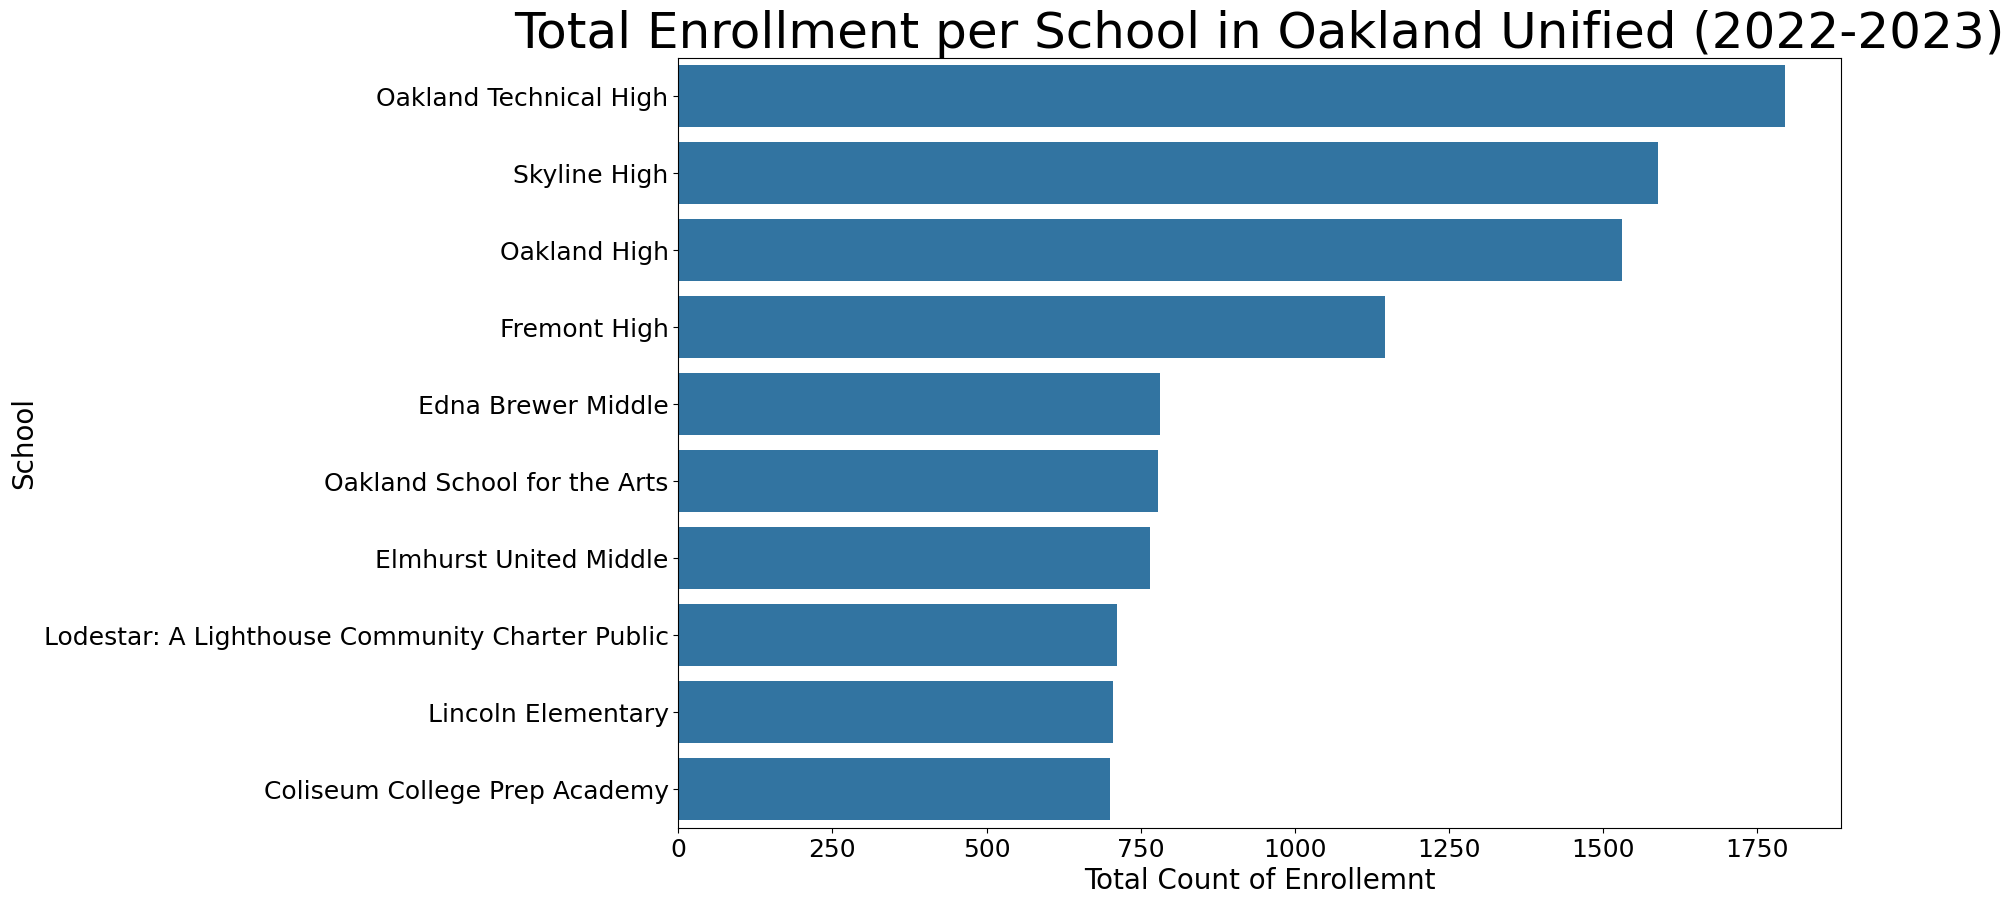

In [45]:
# get an idea of the schools in the district
OakUni_district = 'Oakland Unified'
total_enr_dist(2022,OakUni_district)

## Oakland and Enrollment

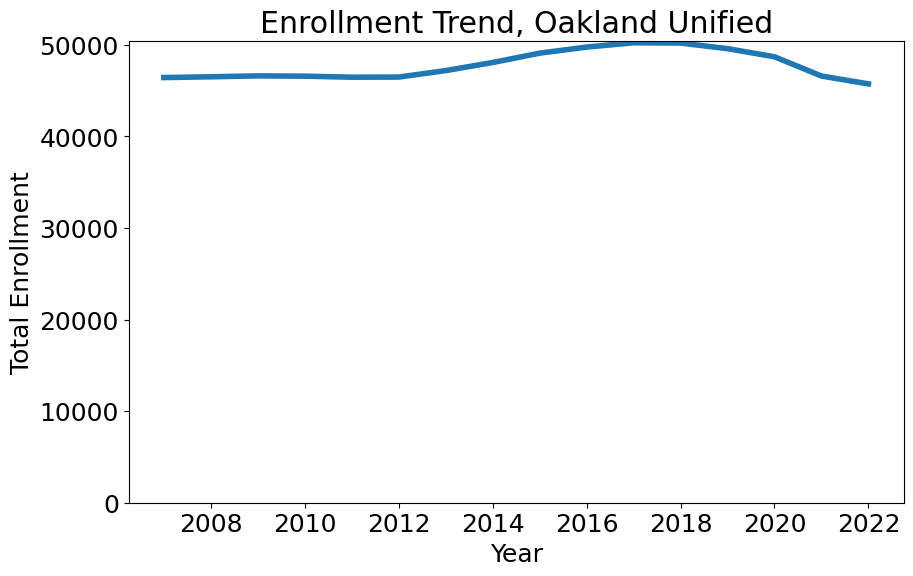

In [46]:
trend_enroll(OakUni_district)

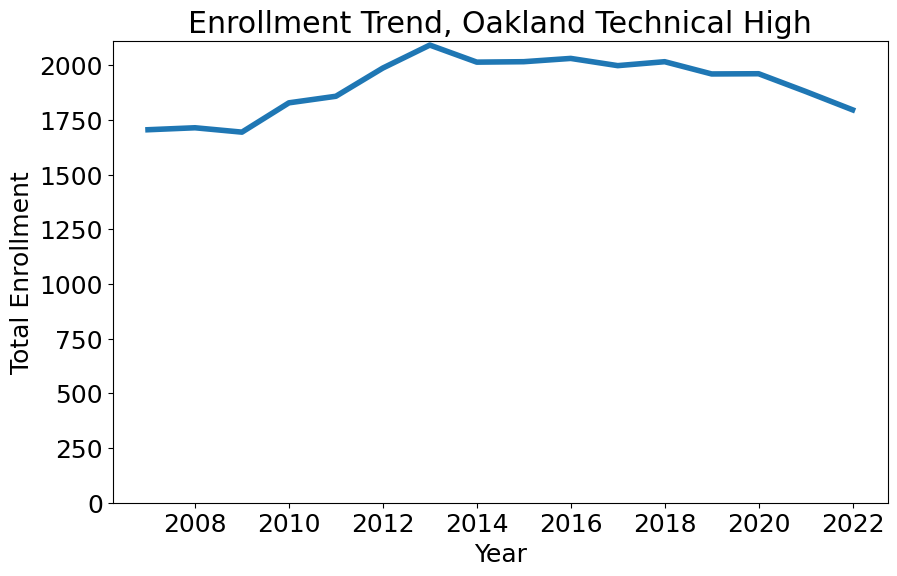

In [47]:
trend_enroll('Oakland Technical High',is_district=False)

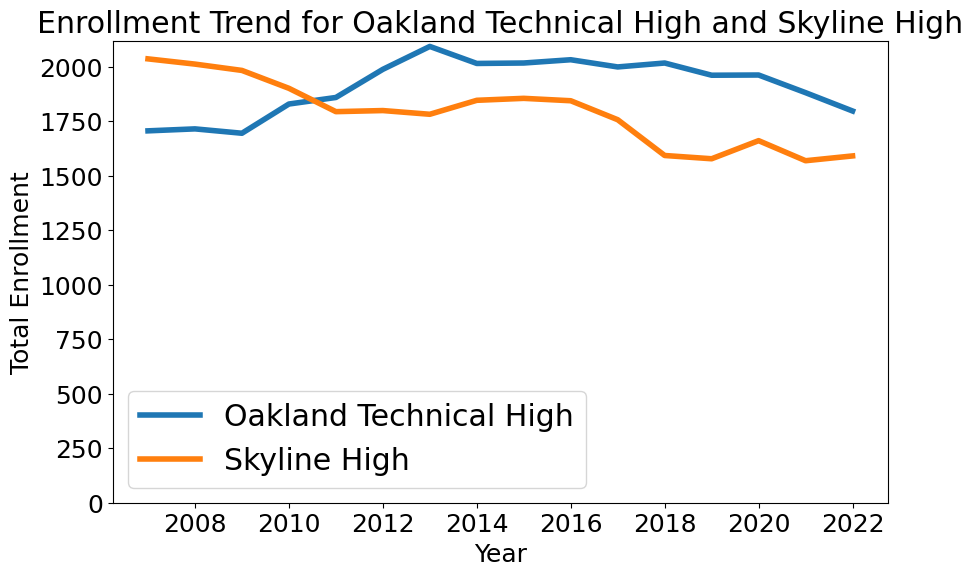

In [48]:
trend_two_edu('Oakland Technical High','Skyline High',is_district=False)

##### Observation:
looking at the top  two schools and it seems that Oakland Tech wasn't always on top

## Oakland Demographics (Gender/Ethnicity)

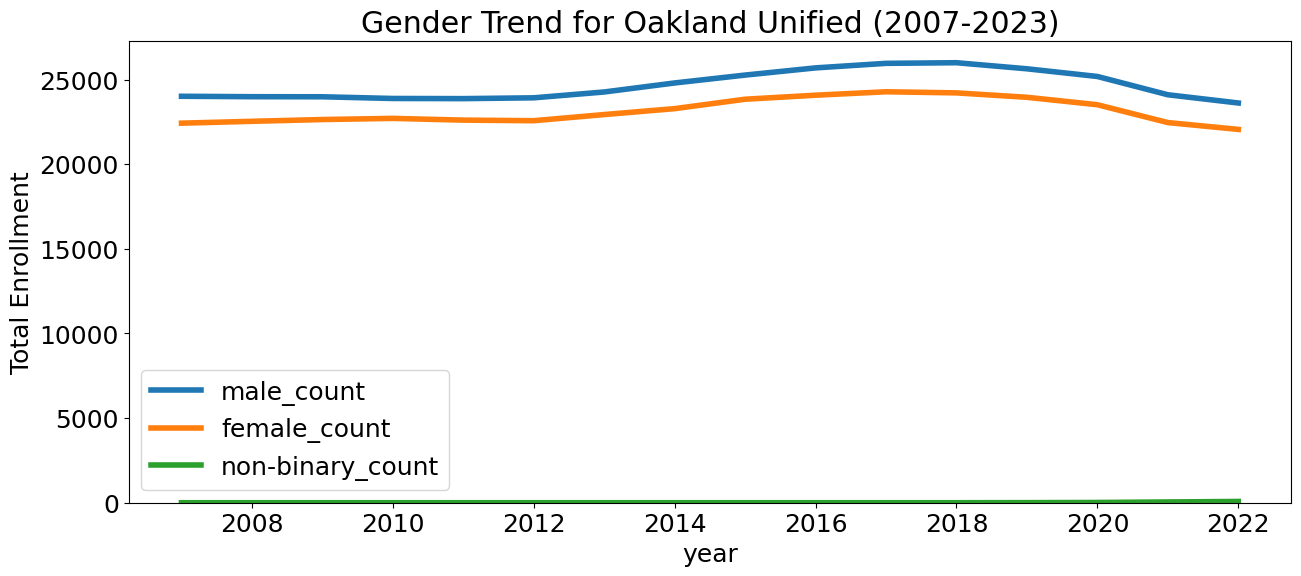

In [49]:
gender_trend(OakUni_district)

##### Observation:
it seems the total of enrollment of males has been always been on top compered to females

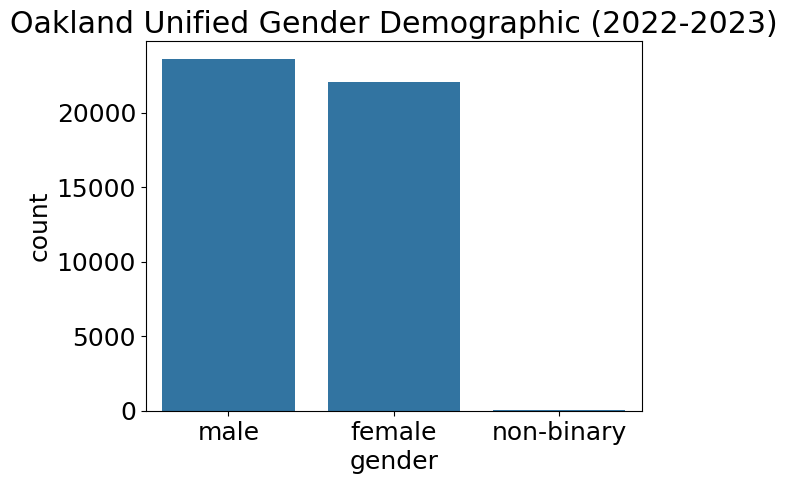

'At Oakland Unified, males make up 51%, females make up 48%, and non-binary students make up 0% with a total of 45741 students in 2022-2023'

In [50]:
gender_stat(2022,OakUni_district)

["Asian's: 10.07%",
 "African American's: 20.09%",
 "Hispanic or Latino's: 49.37%",
 'Mixed: 5.93%',
 'White: 9.46%',
 'Filipino: 0.75%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 0.71%",
 'Not Reported: 3.39%']

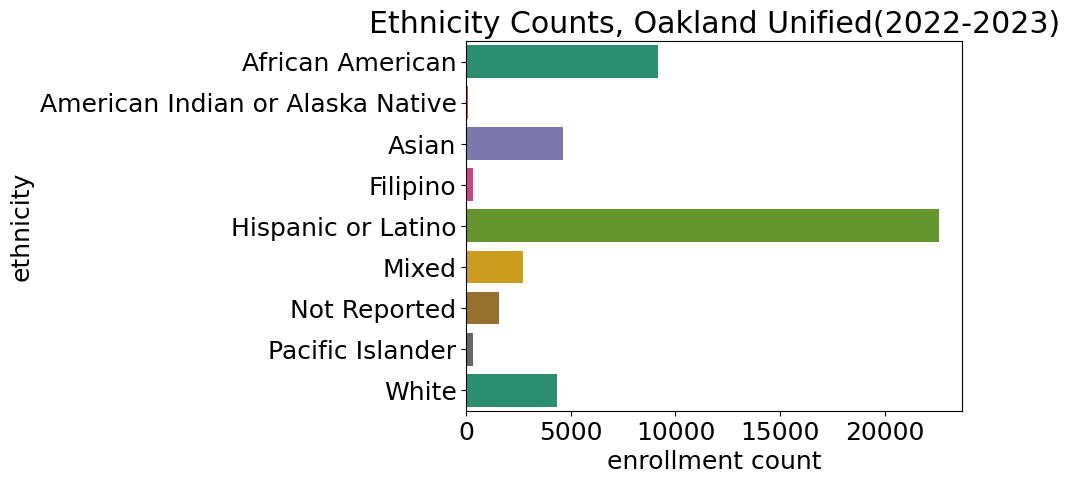

In [51]:
ethnicity_stat(2022,OakUni_district)

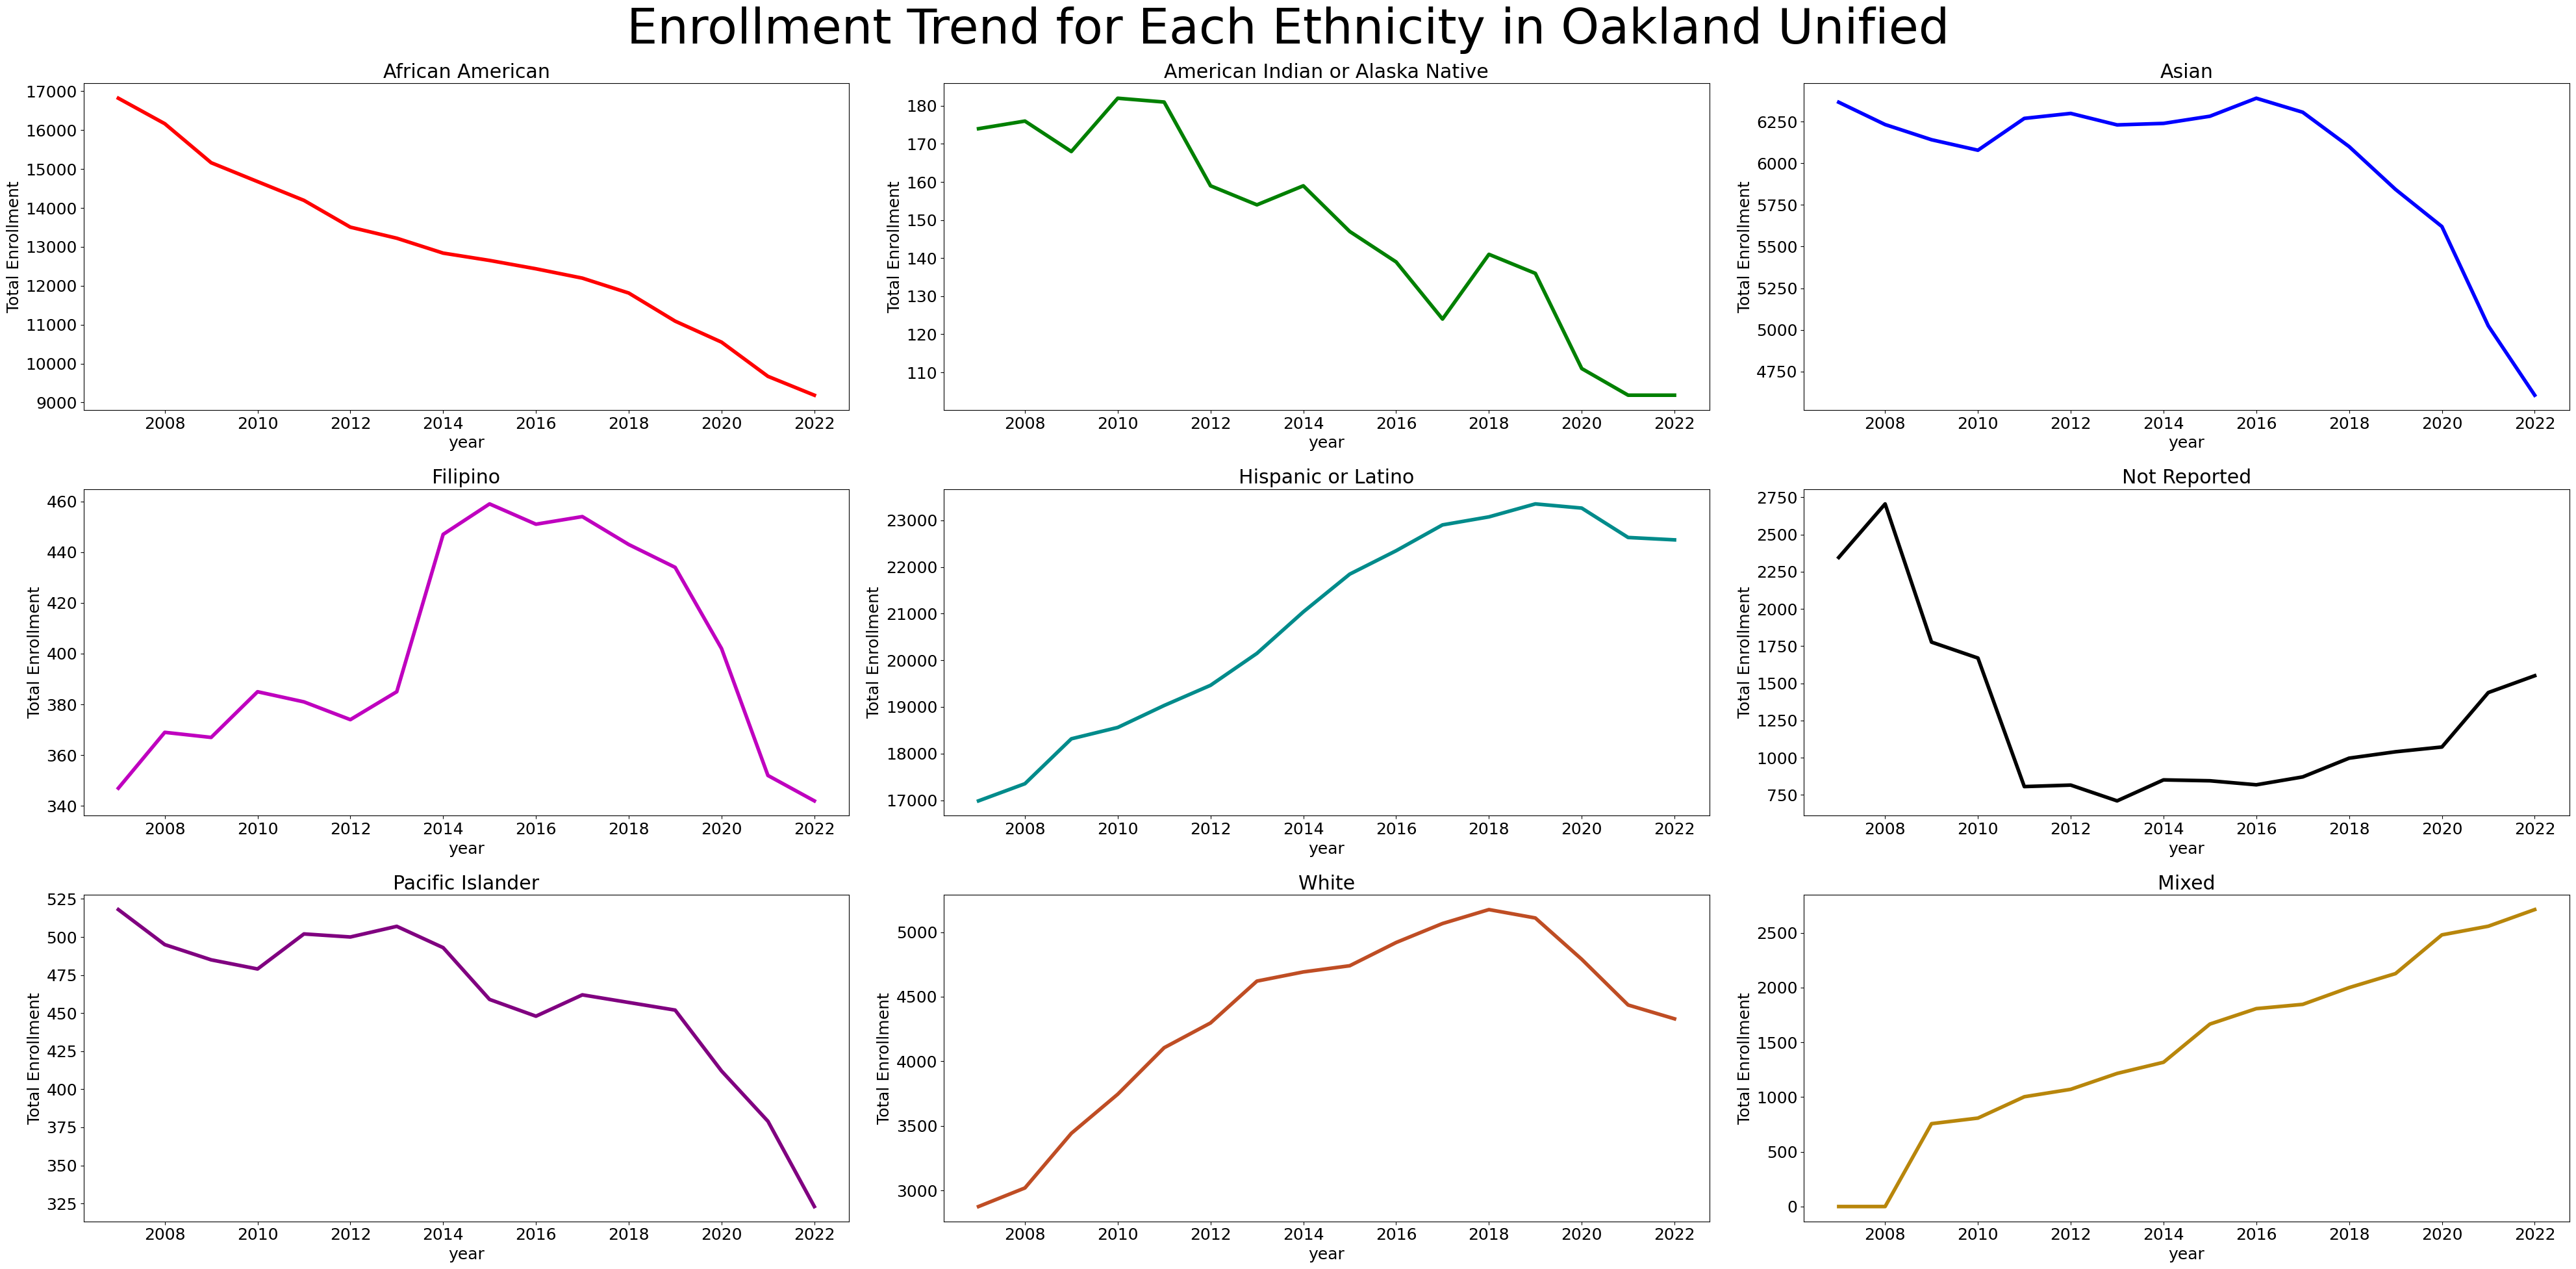

In [52]:
ethnicity_trend('Oakland Unified',is_district=True,facet=True)

### looking at top schools distribution in gender/ethnicity

#### Oakland Technical High

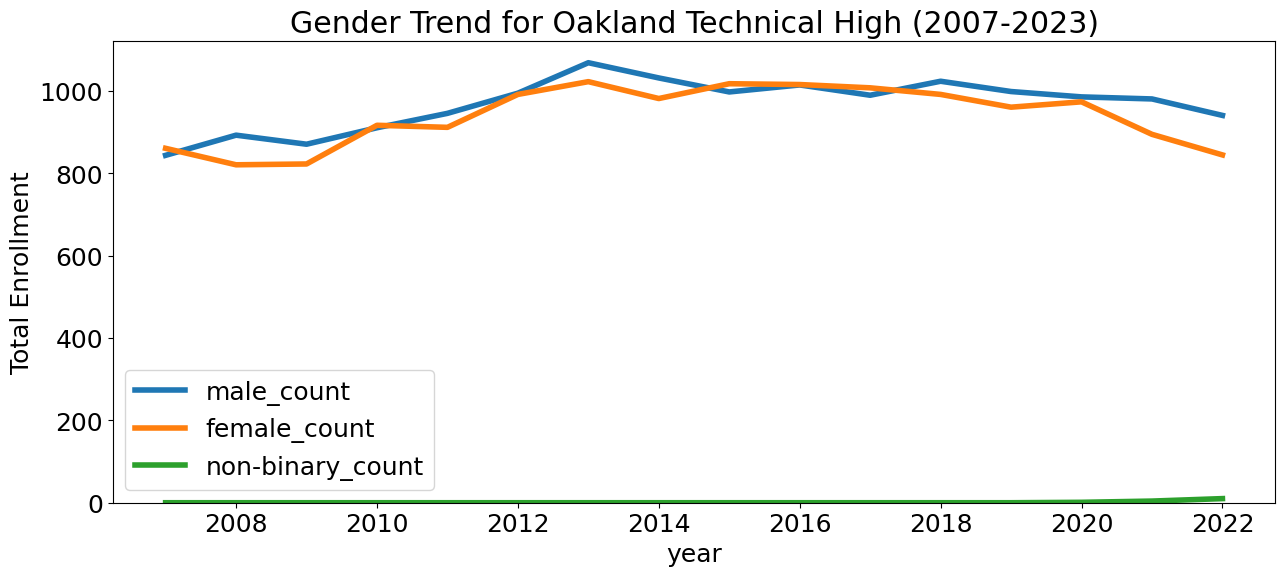

In [53]:
gender_trend('Oakland Technical High',is_district=False)

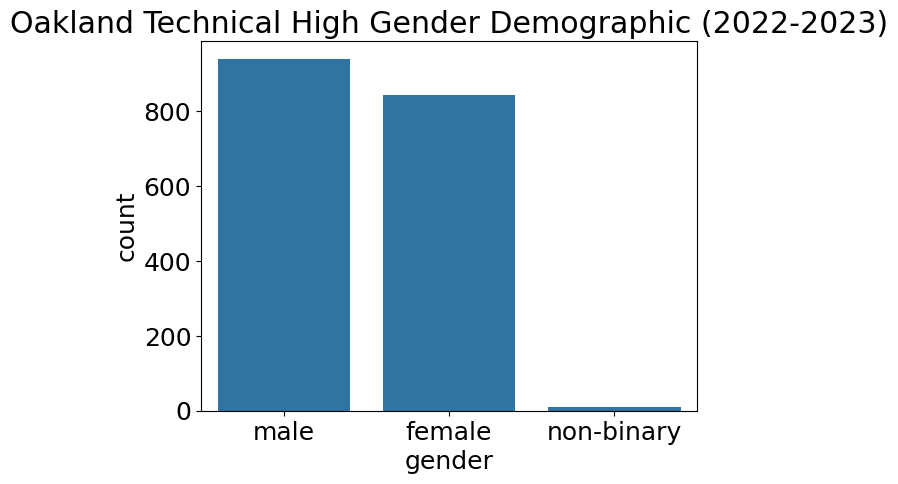

'At Oakland Technical High, males make up 52%, females make up 47%, and non-binary students make up 0% with a total of 1796 students in 2022-2023'

In [54]:
gender_stat(2022,'Oakland Technical High',is_district=False)

["Asian's: 15.48%",
 "African American's: 26.95%",
 "Hispanic or Latino's: 21.44%",
 'Mixed: 10.02%',
 'White: 22.44%',
 'Filipino: 0.95%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 0.11%",
 'Not Reported: 2.56%']

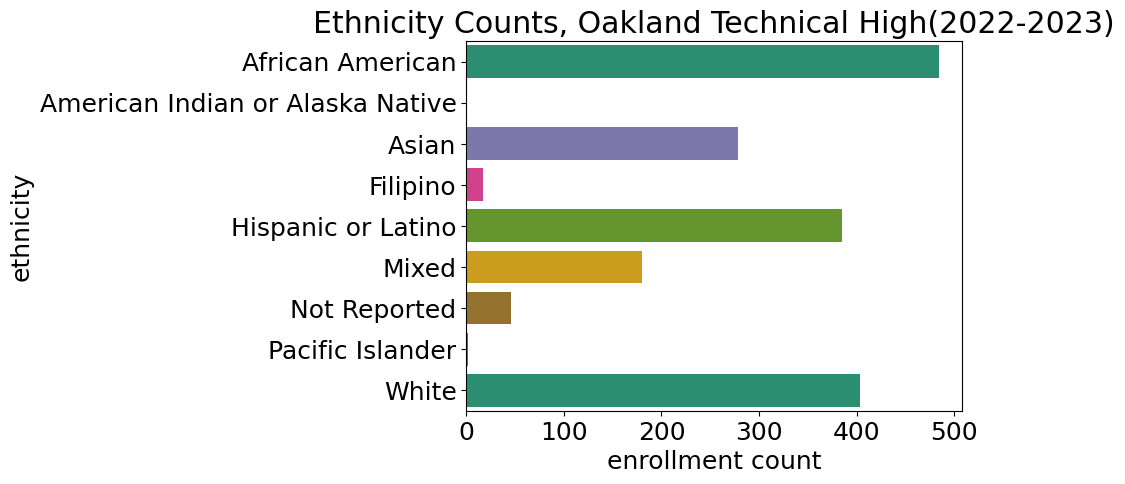

In [55]:

ethnicity_stat(2022,'Oakland Technical High',is_district=False)


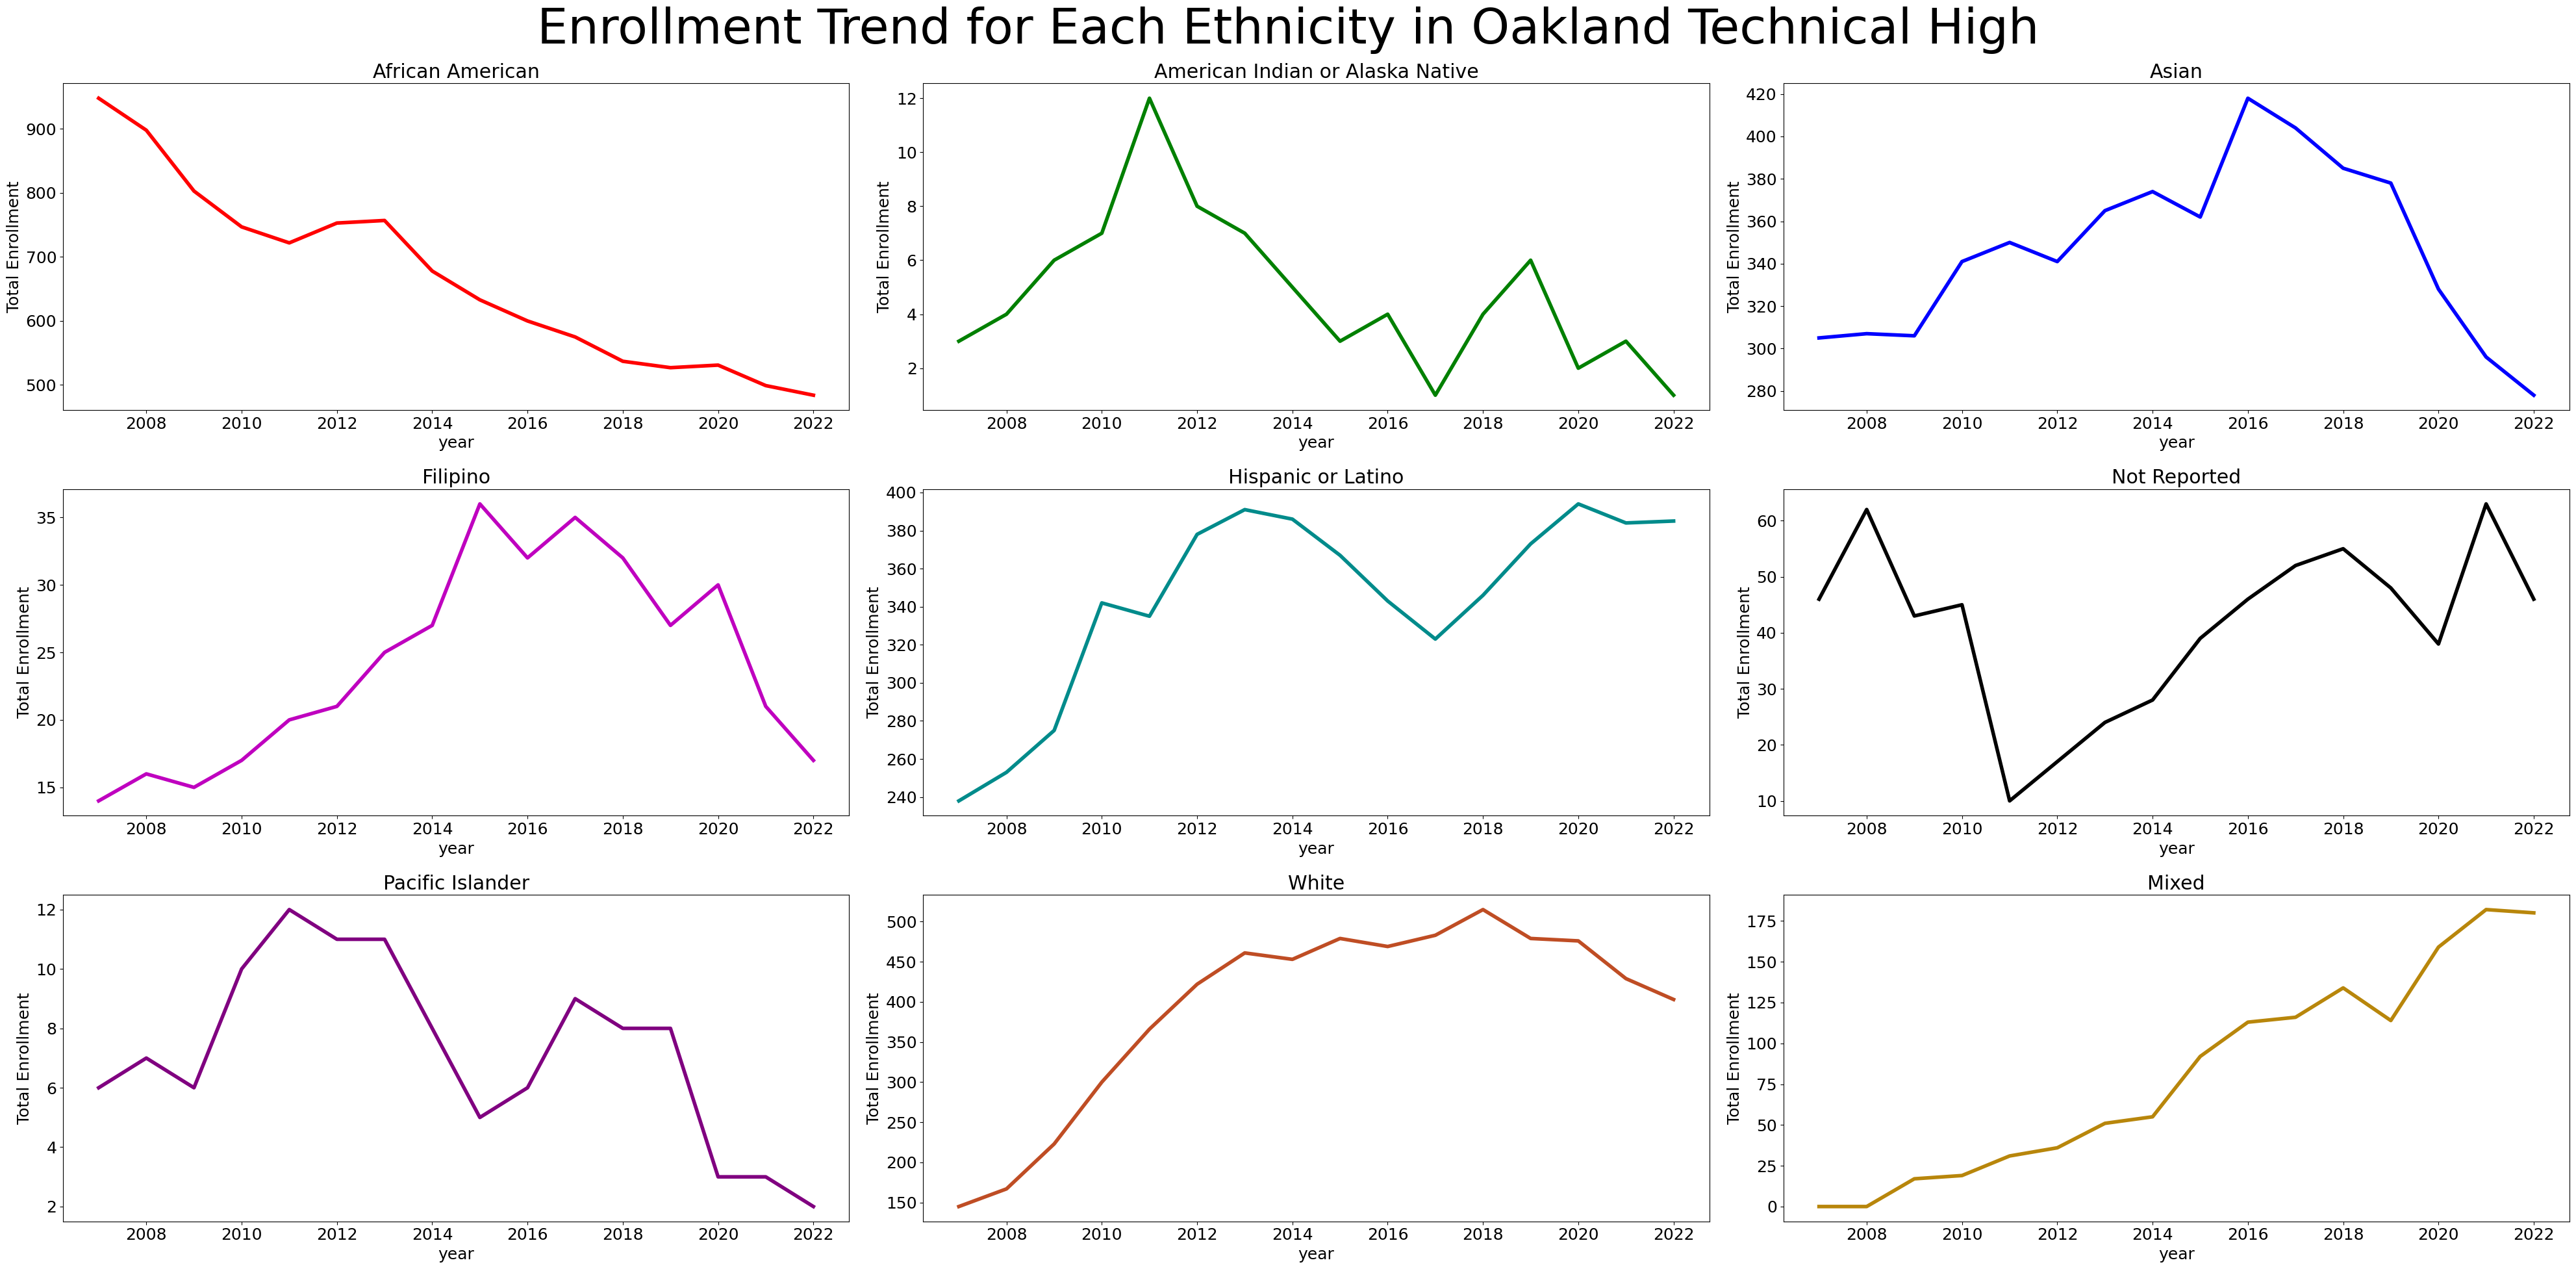

In [56]:
ethnicity_trend('Oakland Technical High',is_district=False,facet=True)

#### Skyline High

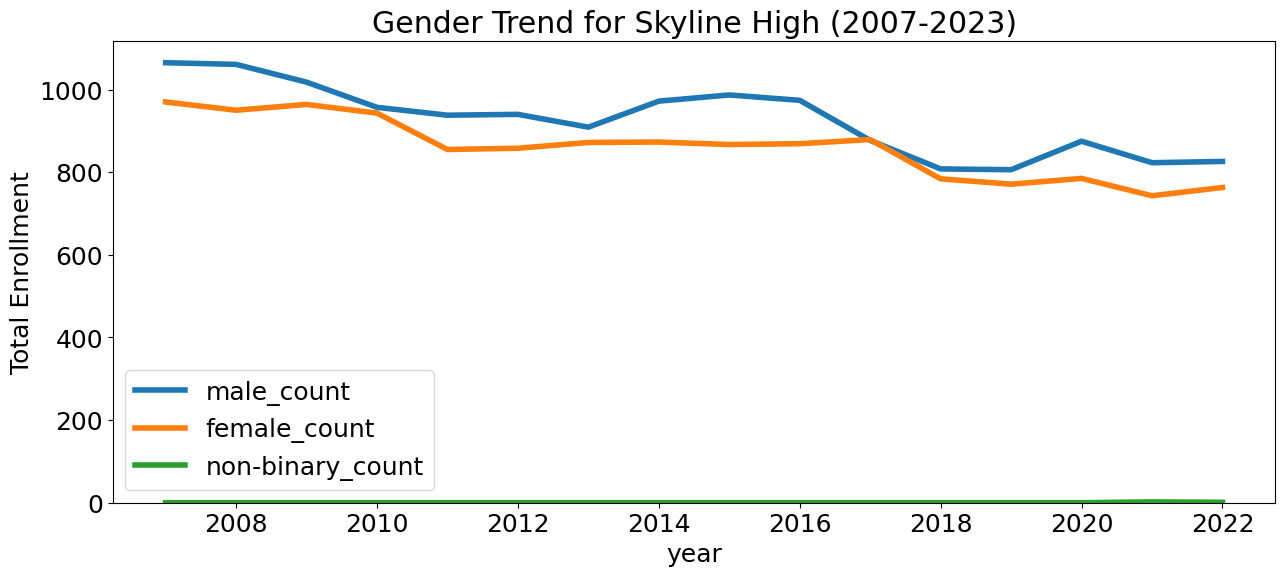

In [57]:
gender_trend('Skyline High',is_district=False)

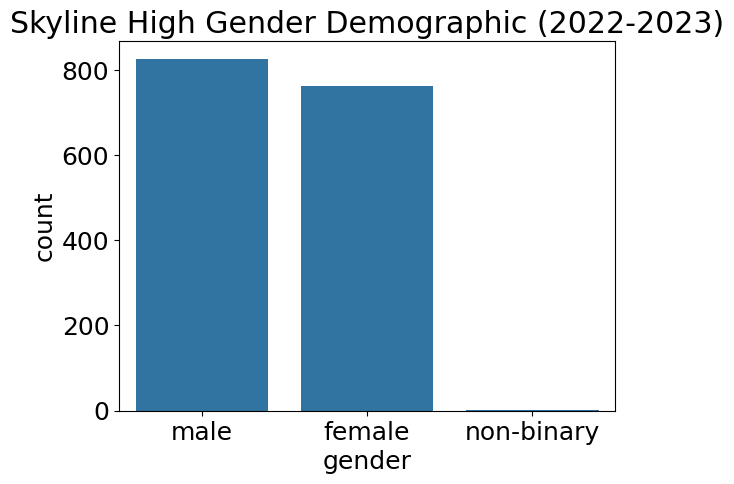

'At Skyline High, males make up 51%, females make up 47%, and non-binary students make up 0% with a total of 1590 students in 2022-2023'

In [58]:
gender_stat(2022,'Skyline High',is_district=False)

["Asian's: 10.13%",
 "African American's: 25.53%",
 "Hispanic or Latino's: 38.93%",
 'Mixed: 7.36%',
 'White: 12.26%',
 'Filipino: 1.51%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 1.32%",
 'Not Reported: 2.58%']

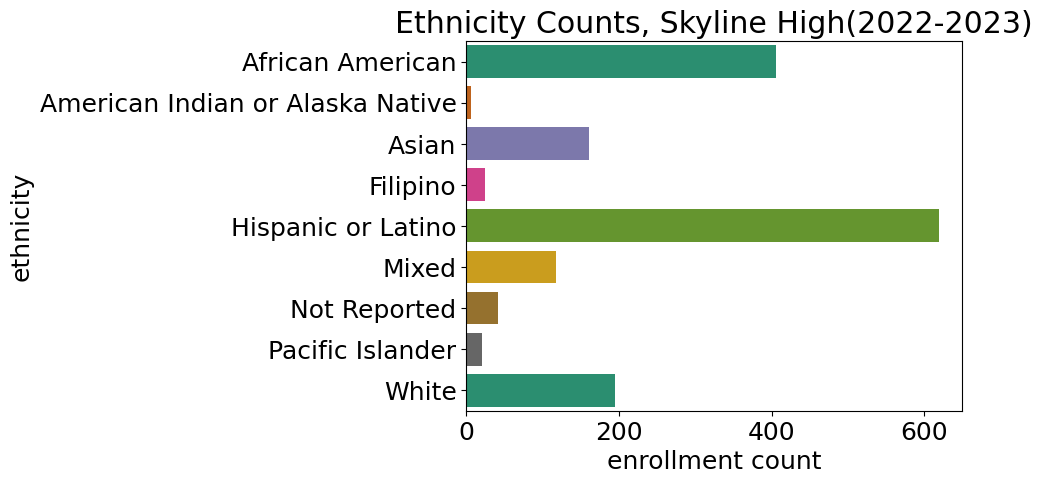

In [59]:

ethnicity_stat(2022,'Skyline High',is_district=False)


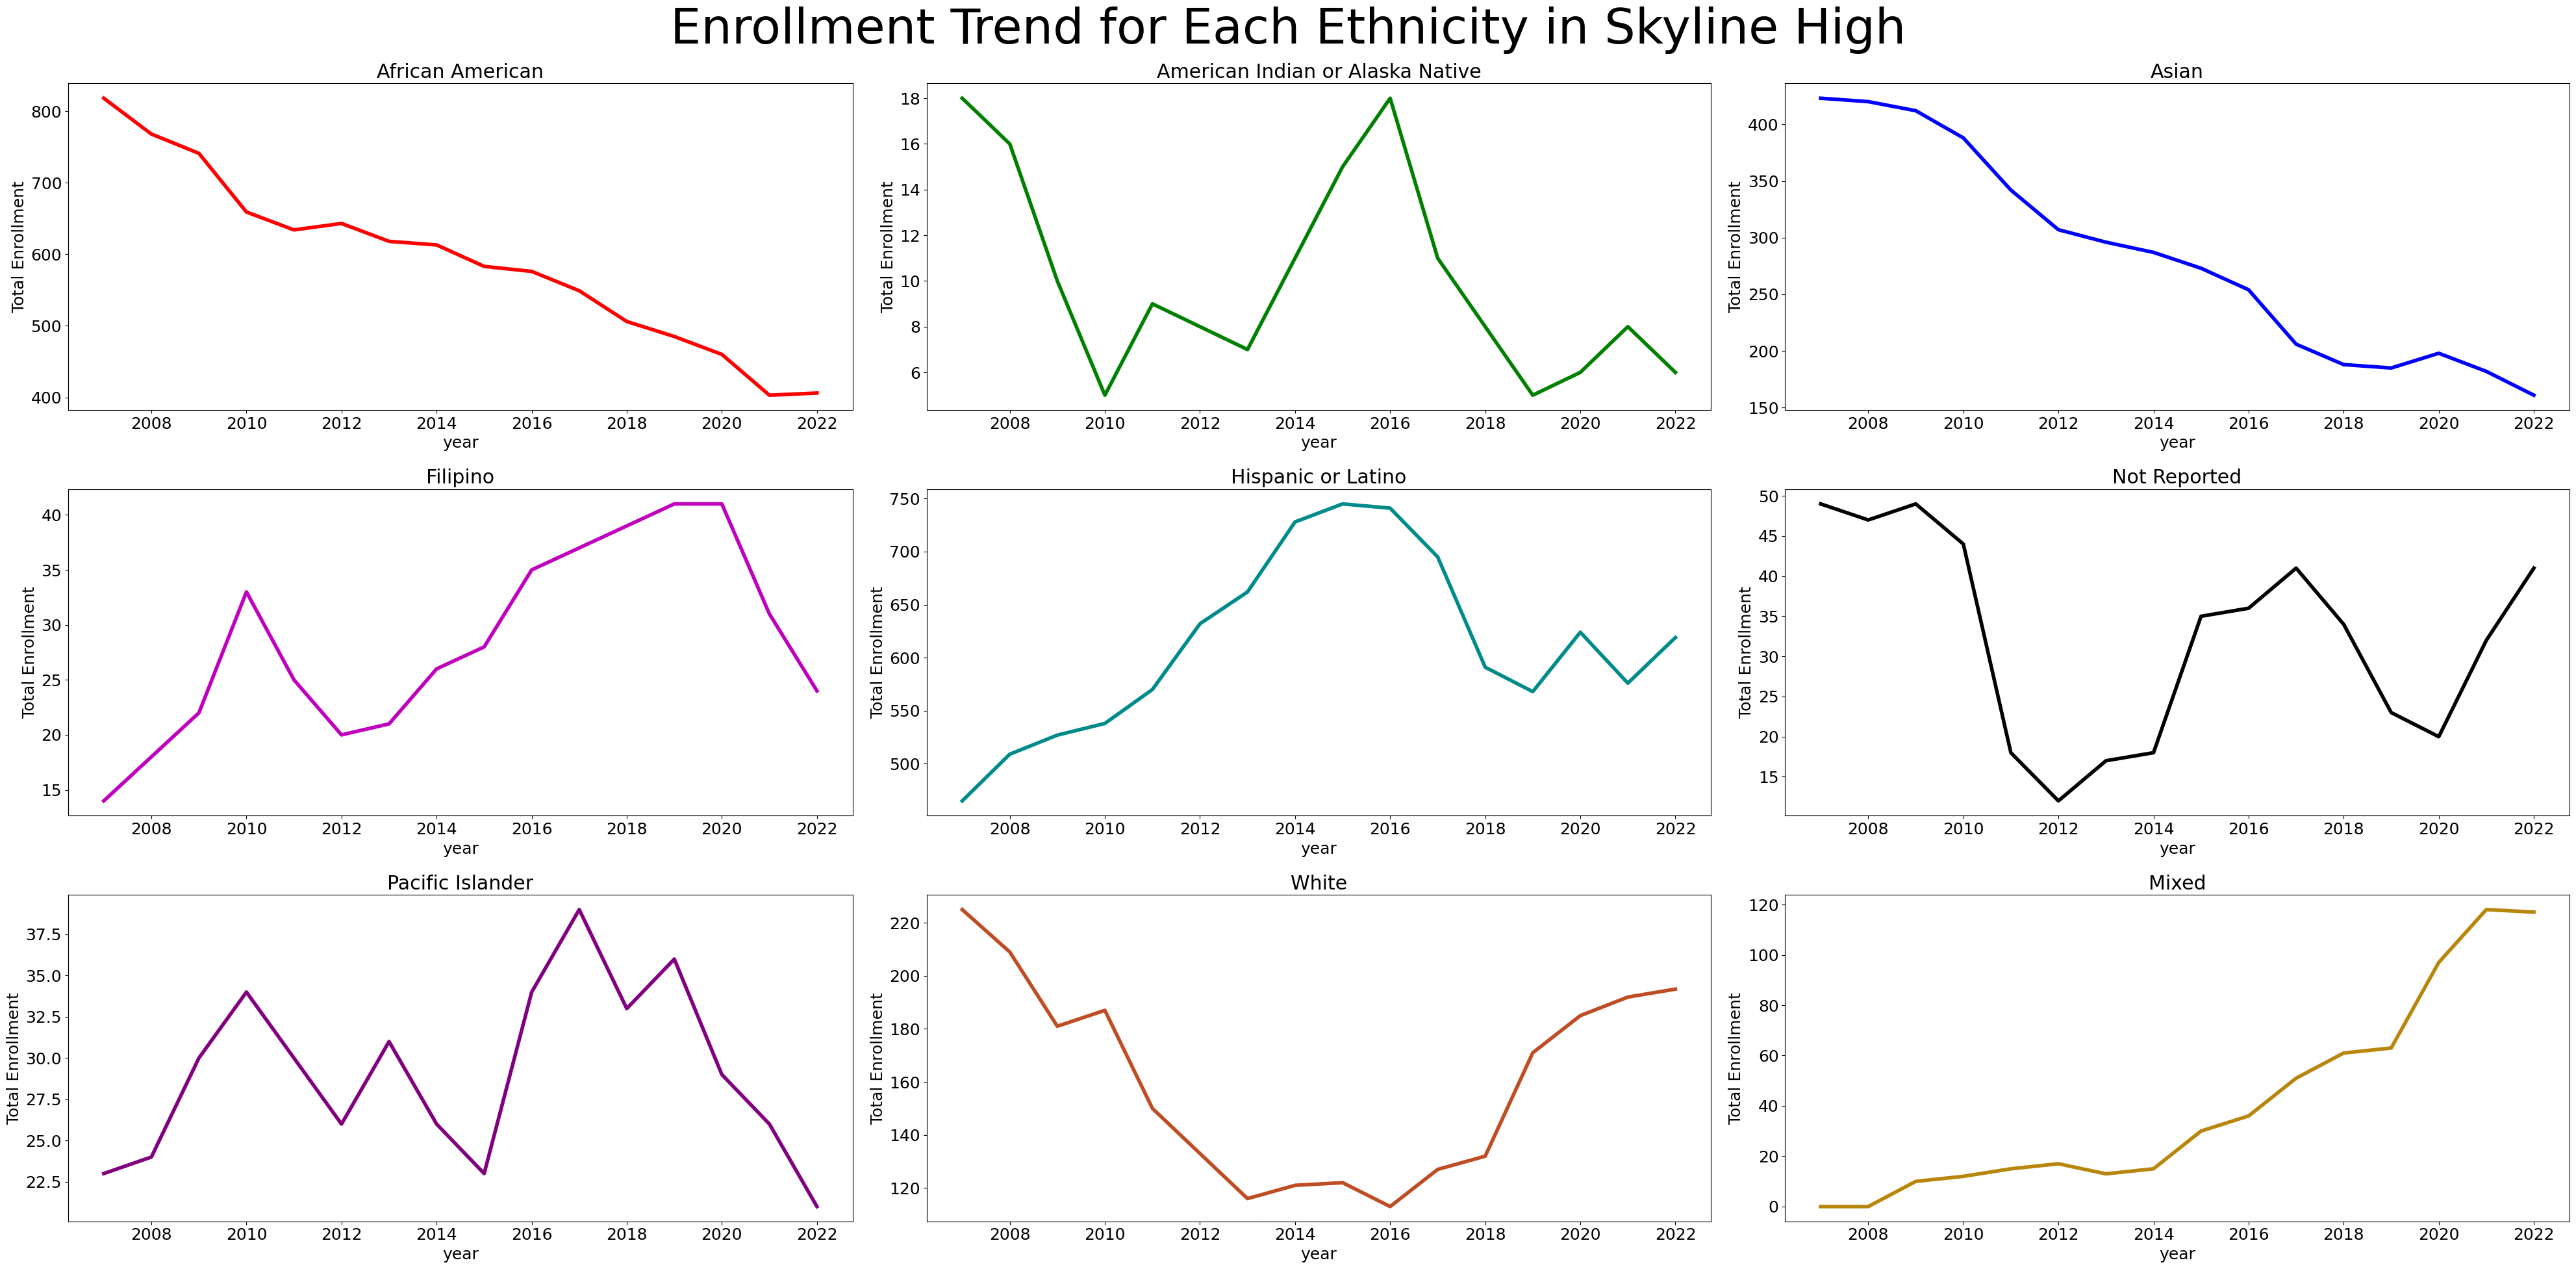

In [60]:
ethnicity_trend('Skyline High',is_district=False,facet=True)

#### Predicting Future Total Enrollment for Oakland

'The projection of total enrollment for Oakland Unified in 2050 is to be 52692. Which is 6951 more students than 2023'

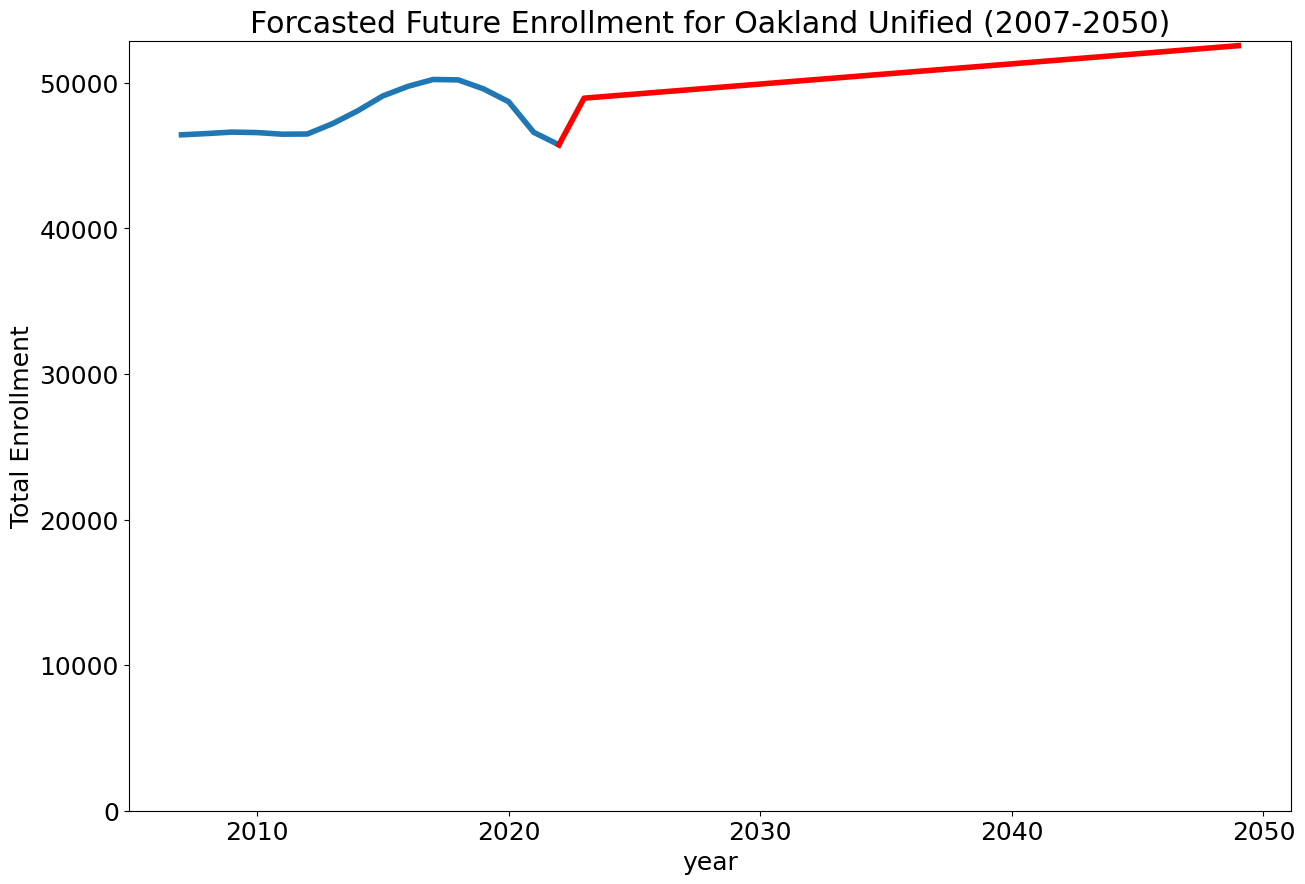

In [61]:
forecast_future_enrol(OakUni_district,2050)

['Predicted enrollment for Oakland Technical High in 2050: 2360',
 'Predicted enrollment for Skyline High in 2050: 727',
 'The disparity in enrollment between Oakland Technical High and Skyline High is 1633, indicating that Oakland Technical High is projected to have more students than Skyline High in 2050.']

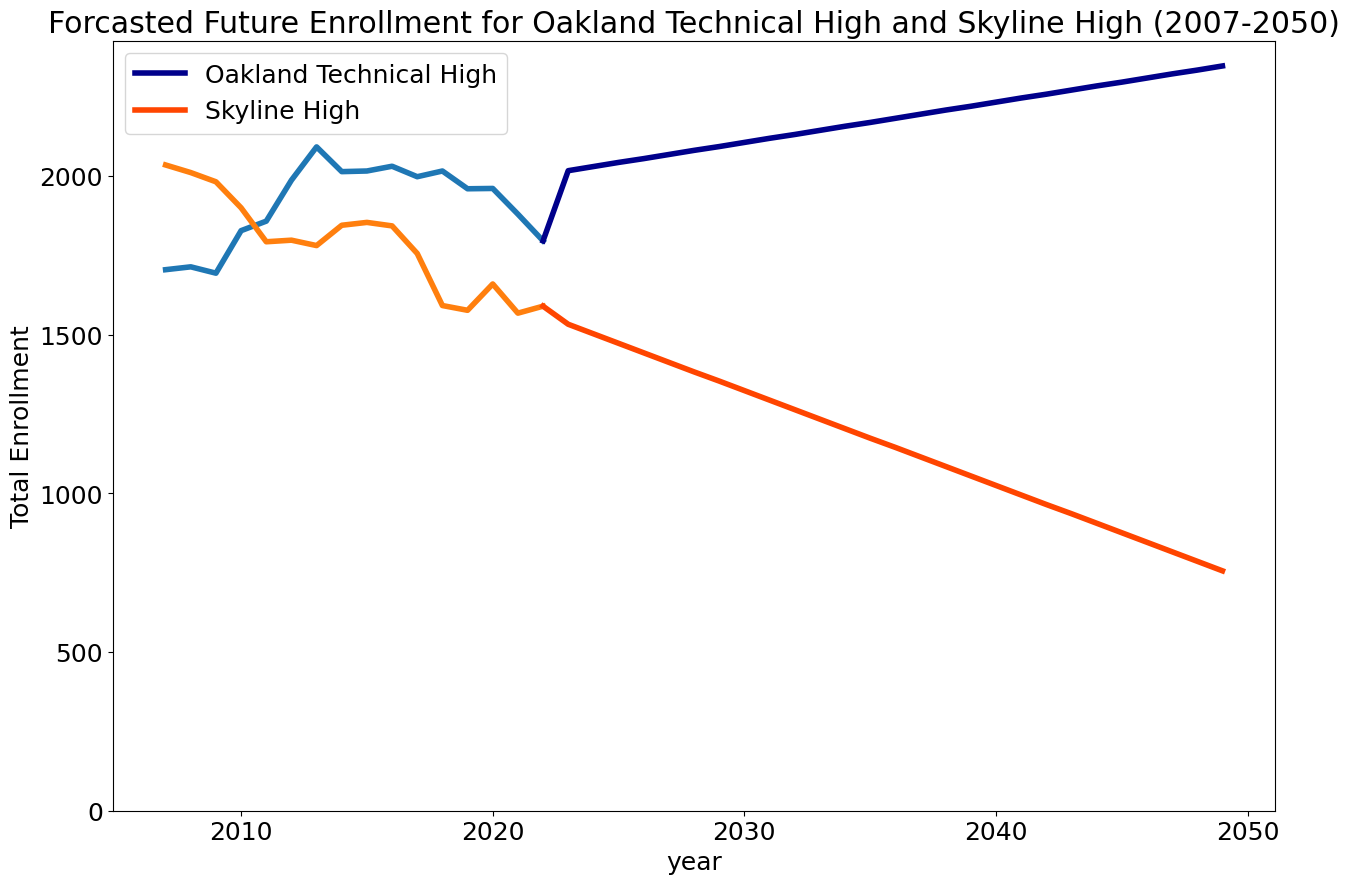

In [62]:
forecast_two_future_enrol('Oakland Technical High','Skyline High',2050,is_district=False)

##### Observation:
it seems that Oakland Tech will ultimately be on top for the next 25 years in total enrollment

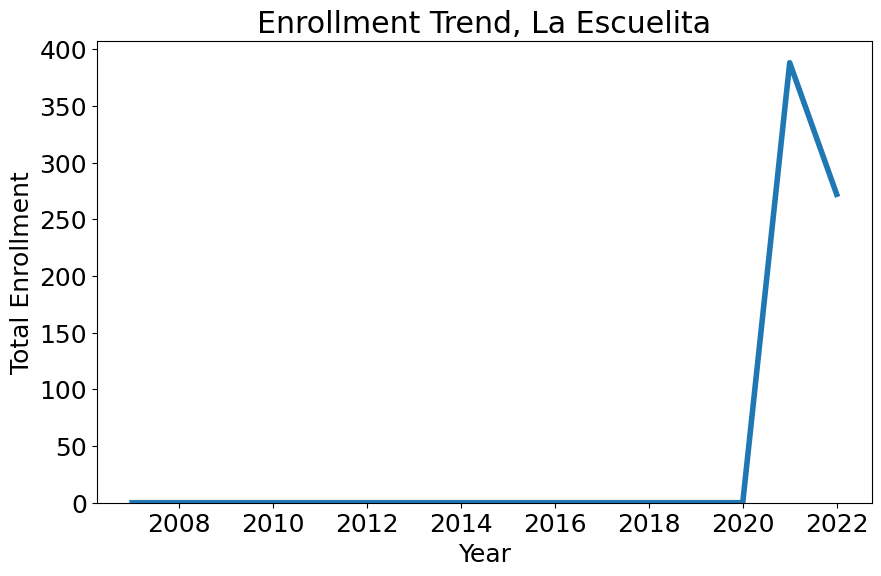

In [63]:
trend_enroll('La Escuelita',is_district=False)

##### Observation:
looks like this because there was no data recorded for this particular school unil 2020.

'The projection of total enrollment for La Escuelita in 2100 is to be 1188. Which is 916 more students than 2023'

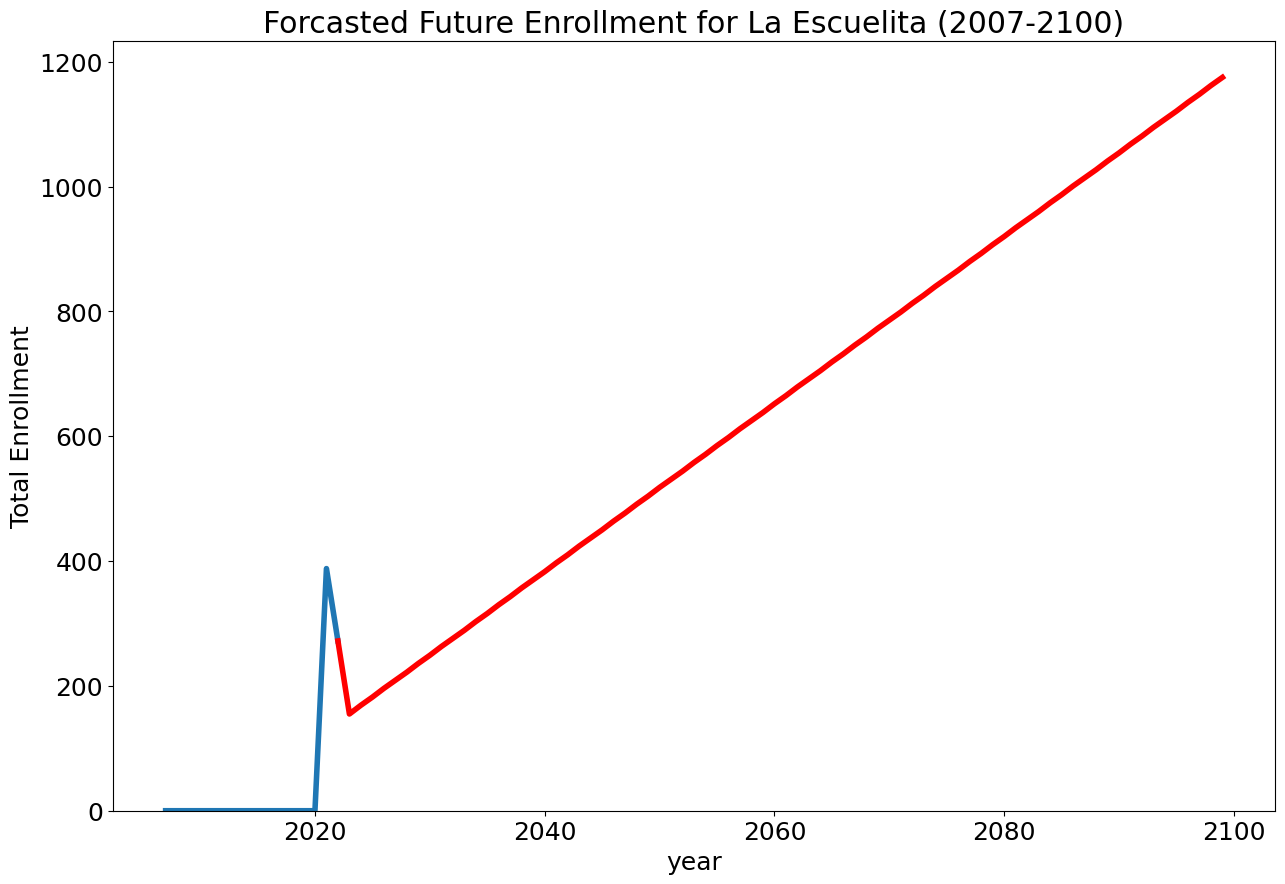

In [64]:
forecast_future_enrol('La Escuelita',2100,is_district=False)

# San Francisco Query

In [65]:

sf_closed = la_clean_cde_closed.loc[la_clean_cde_closed['district'] == 'San Francisco Unified'] #sf schools currently open and closed
sf_open = sf_closed.loc[sf_closed['statustype'] == 'Active'] #sf schools currently open



In [66]:
#find the average year schools were opened in San Francisco
sf_date_list = list(sf_closed.opendate)
sf_split_date = [re.split('/+',i) for i in sf_date_list]
sf_years =[ ''.join([i for i in sub_date if len(i) == 4]) for sub_date in sf_split_date]
int_sf_years = [int(i) for i in sf_years]
print('The average year schools opened in San Francisco is '+str(int(np.mean(int_sf_years) )) +'(closed schools included).')


sf_date_listo = list(sf_open.opendate)
sf_split_dateo = [re.split('/+',i) for i in sf_date_listo]
sf_yearso =[ ''.join([i for i in sub_date if len(i) == 4]) for sub_date in sf_split_dateo]
int_sf_yearso = [int(i) for i in sf_yearso]

print('The average year schools opened in San Francisco is '+str(int(np.mean(int_sf_yearso) )) +'(only open schools).' )




The average year schools opened in San Francisco is 1985(closed schools included).
The average year schools opened in San Francisco is 1987(only open schools).


## San Francisco and Enrollment

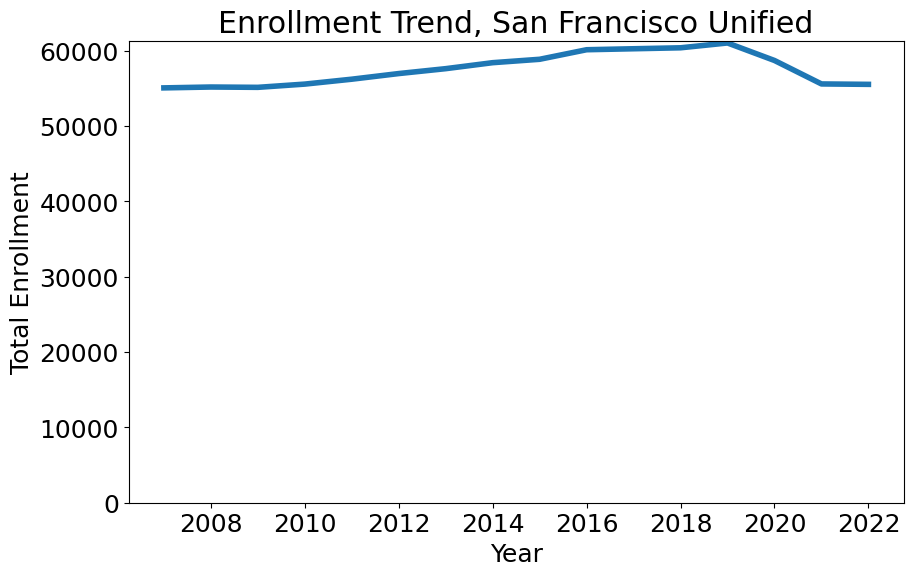

In [67]:
# Did something cause this spike or was there just more data added to SF school district.
SF_district = 'San Francisco Unified'
trend_enroll(SF_district)

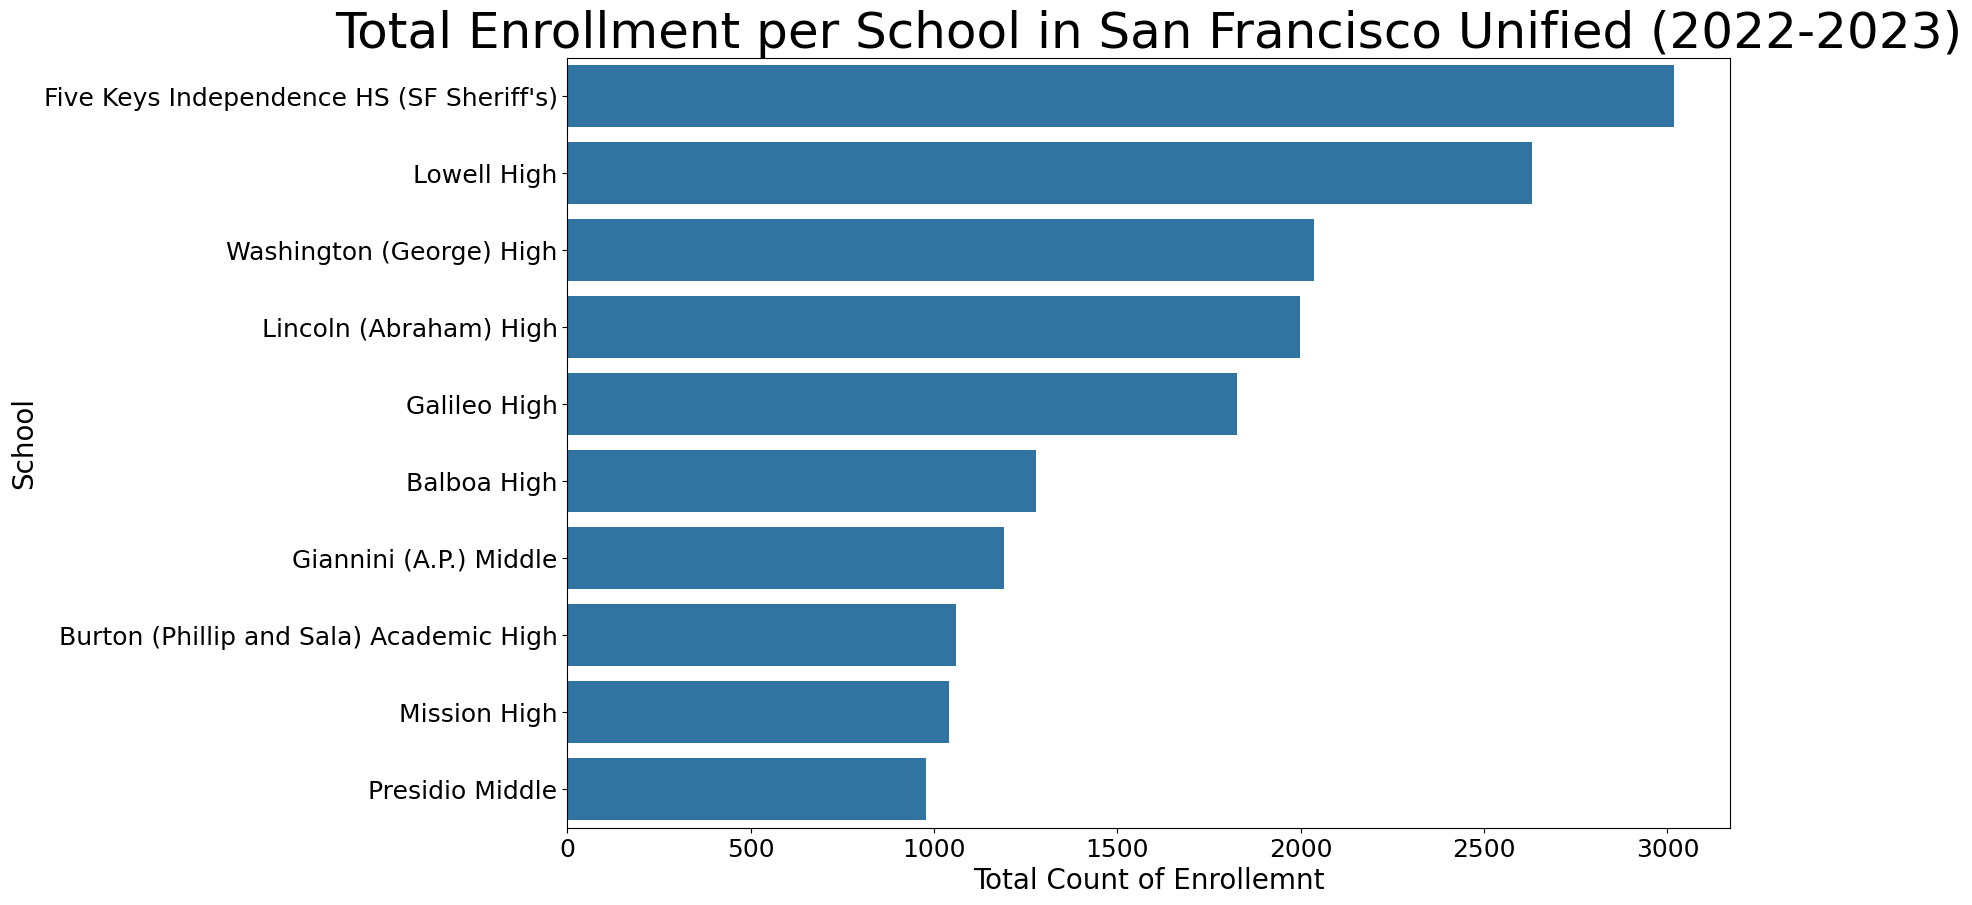

In [68]:

total_enr_dist(2022,SF_district)

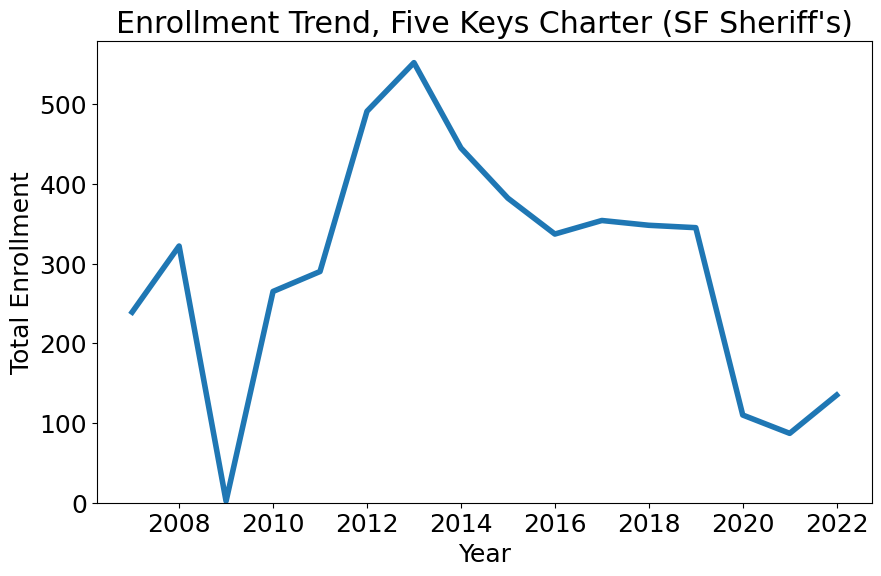

In [69]:
trend_enroll("Five Keys Charter (SF Sheriff's)",is_district=False)

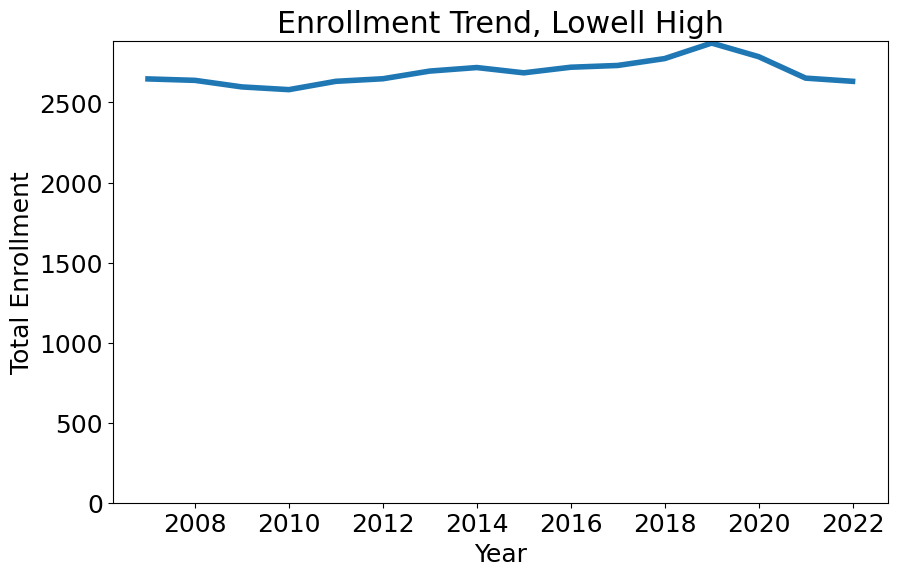

In [70]:
trend_enroll('Lowell High',is_district=False)

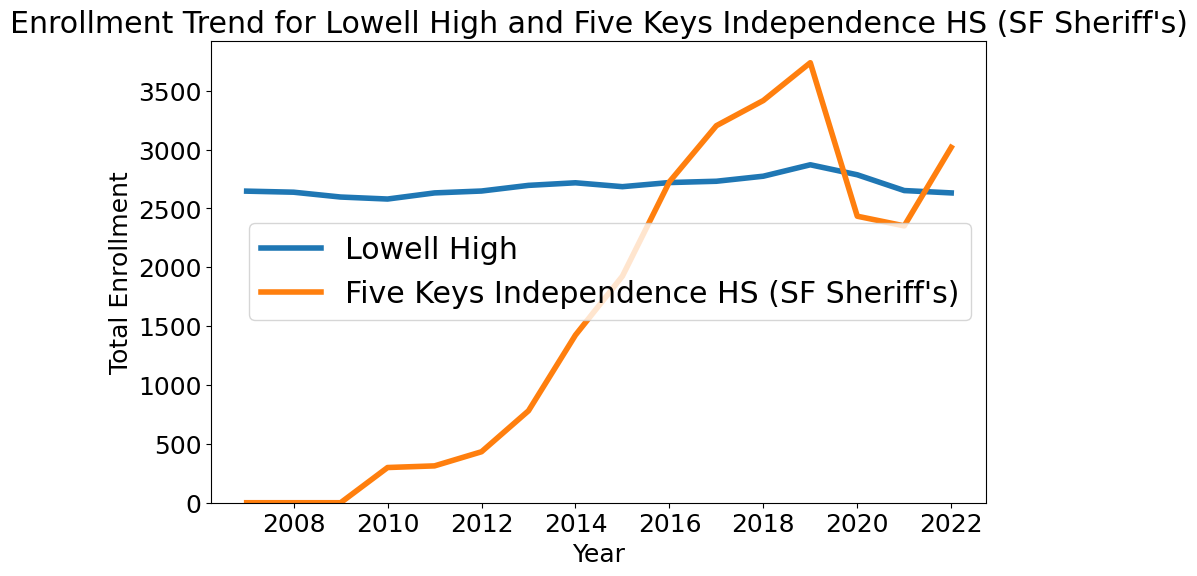

In [71]:
#FKIHS had some consistent growth in their total enrollment compred to LH which seems to be more 'steady'
trend_two_edu('Lowell High',"Five Keys Independence HS (SF Sheriff's)",is_district=False)

## SF Demographics (Gender/Ethnicity)

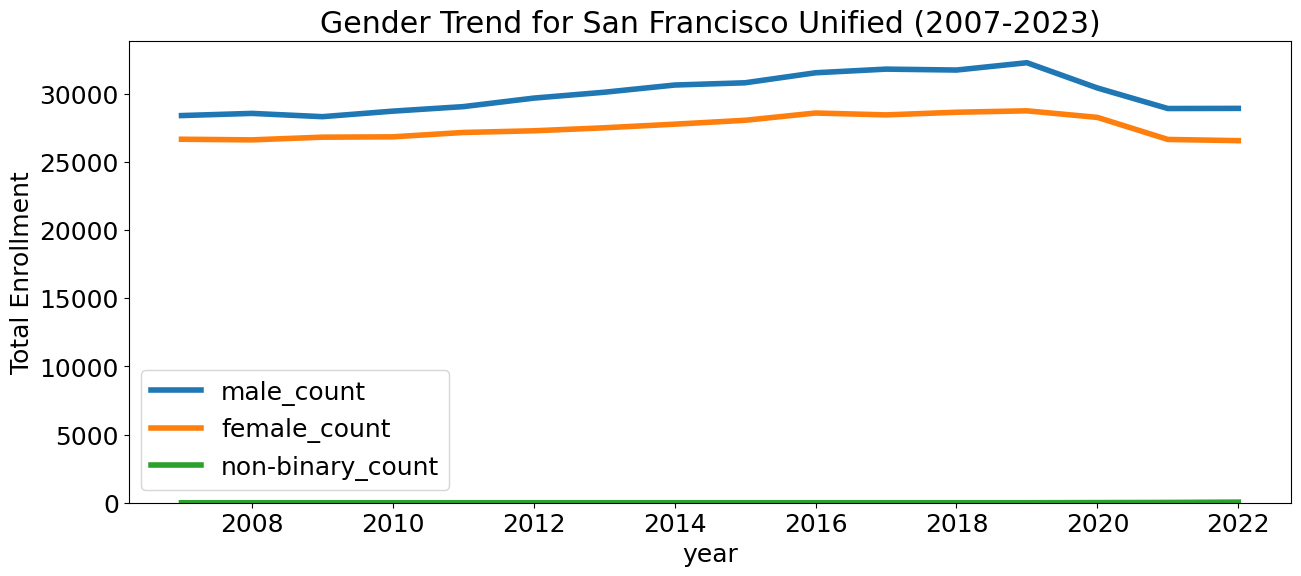

In [72]:
gender_trend(SF_district)

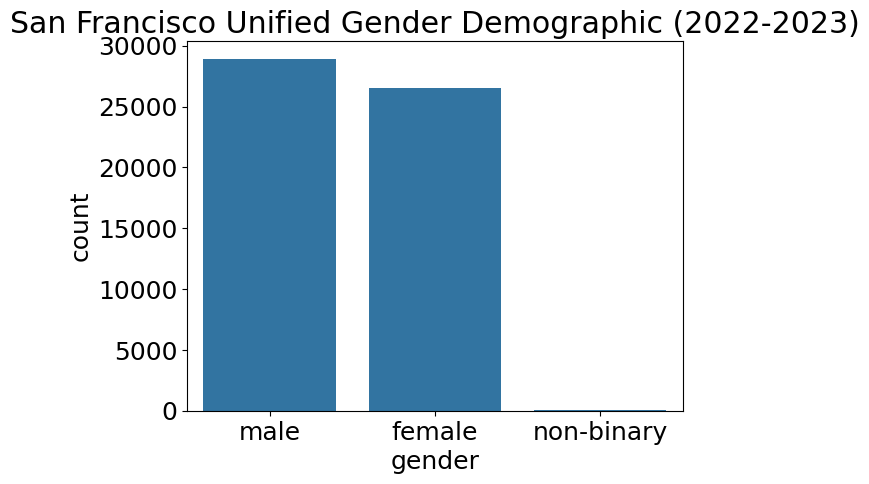

'At San Francisco Unified, males make up 52%, females make up 47%, and non-binary students make up 0% with a total of 55537 students in 2022-2023'

In [73]:
gender_stat(2022,SF_district)

["Asian's: 29.21%",
 "African American's: 7.31%",
 "Hispanic or Latino's: 34.49%",
 'Mixed: 7.16%',
 'White: 13.36%',
 'Filipino: 3.57%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 0.74%",
 'Not Reported: 3.92%']

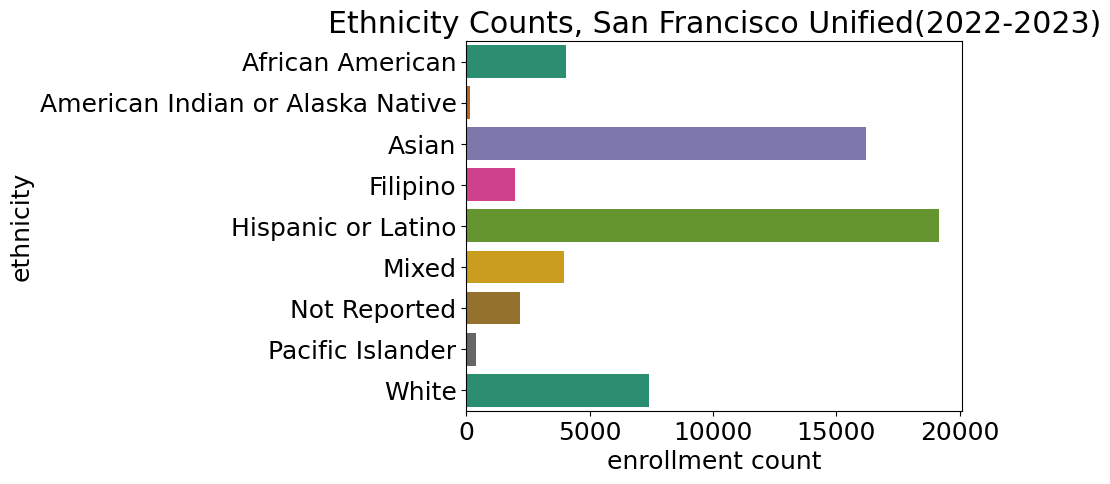

In [74]:
#recent ethnic info
ethnicity_stat(2022,SF_district)

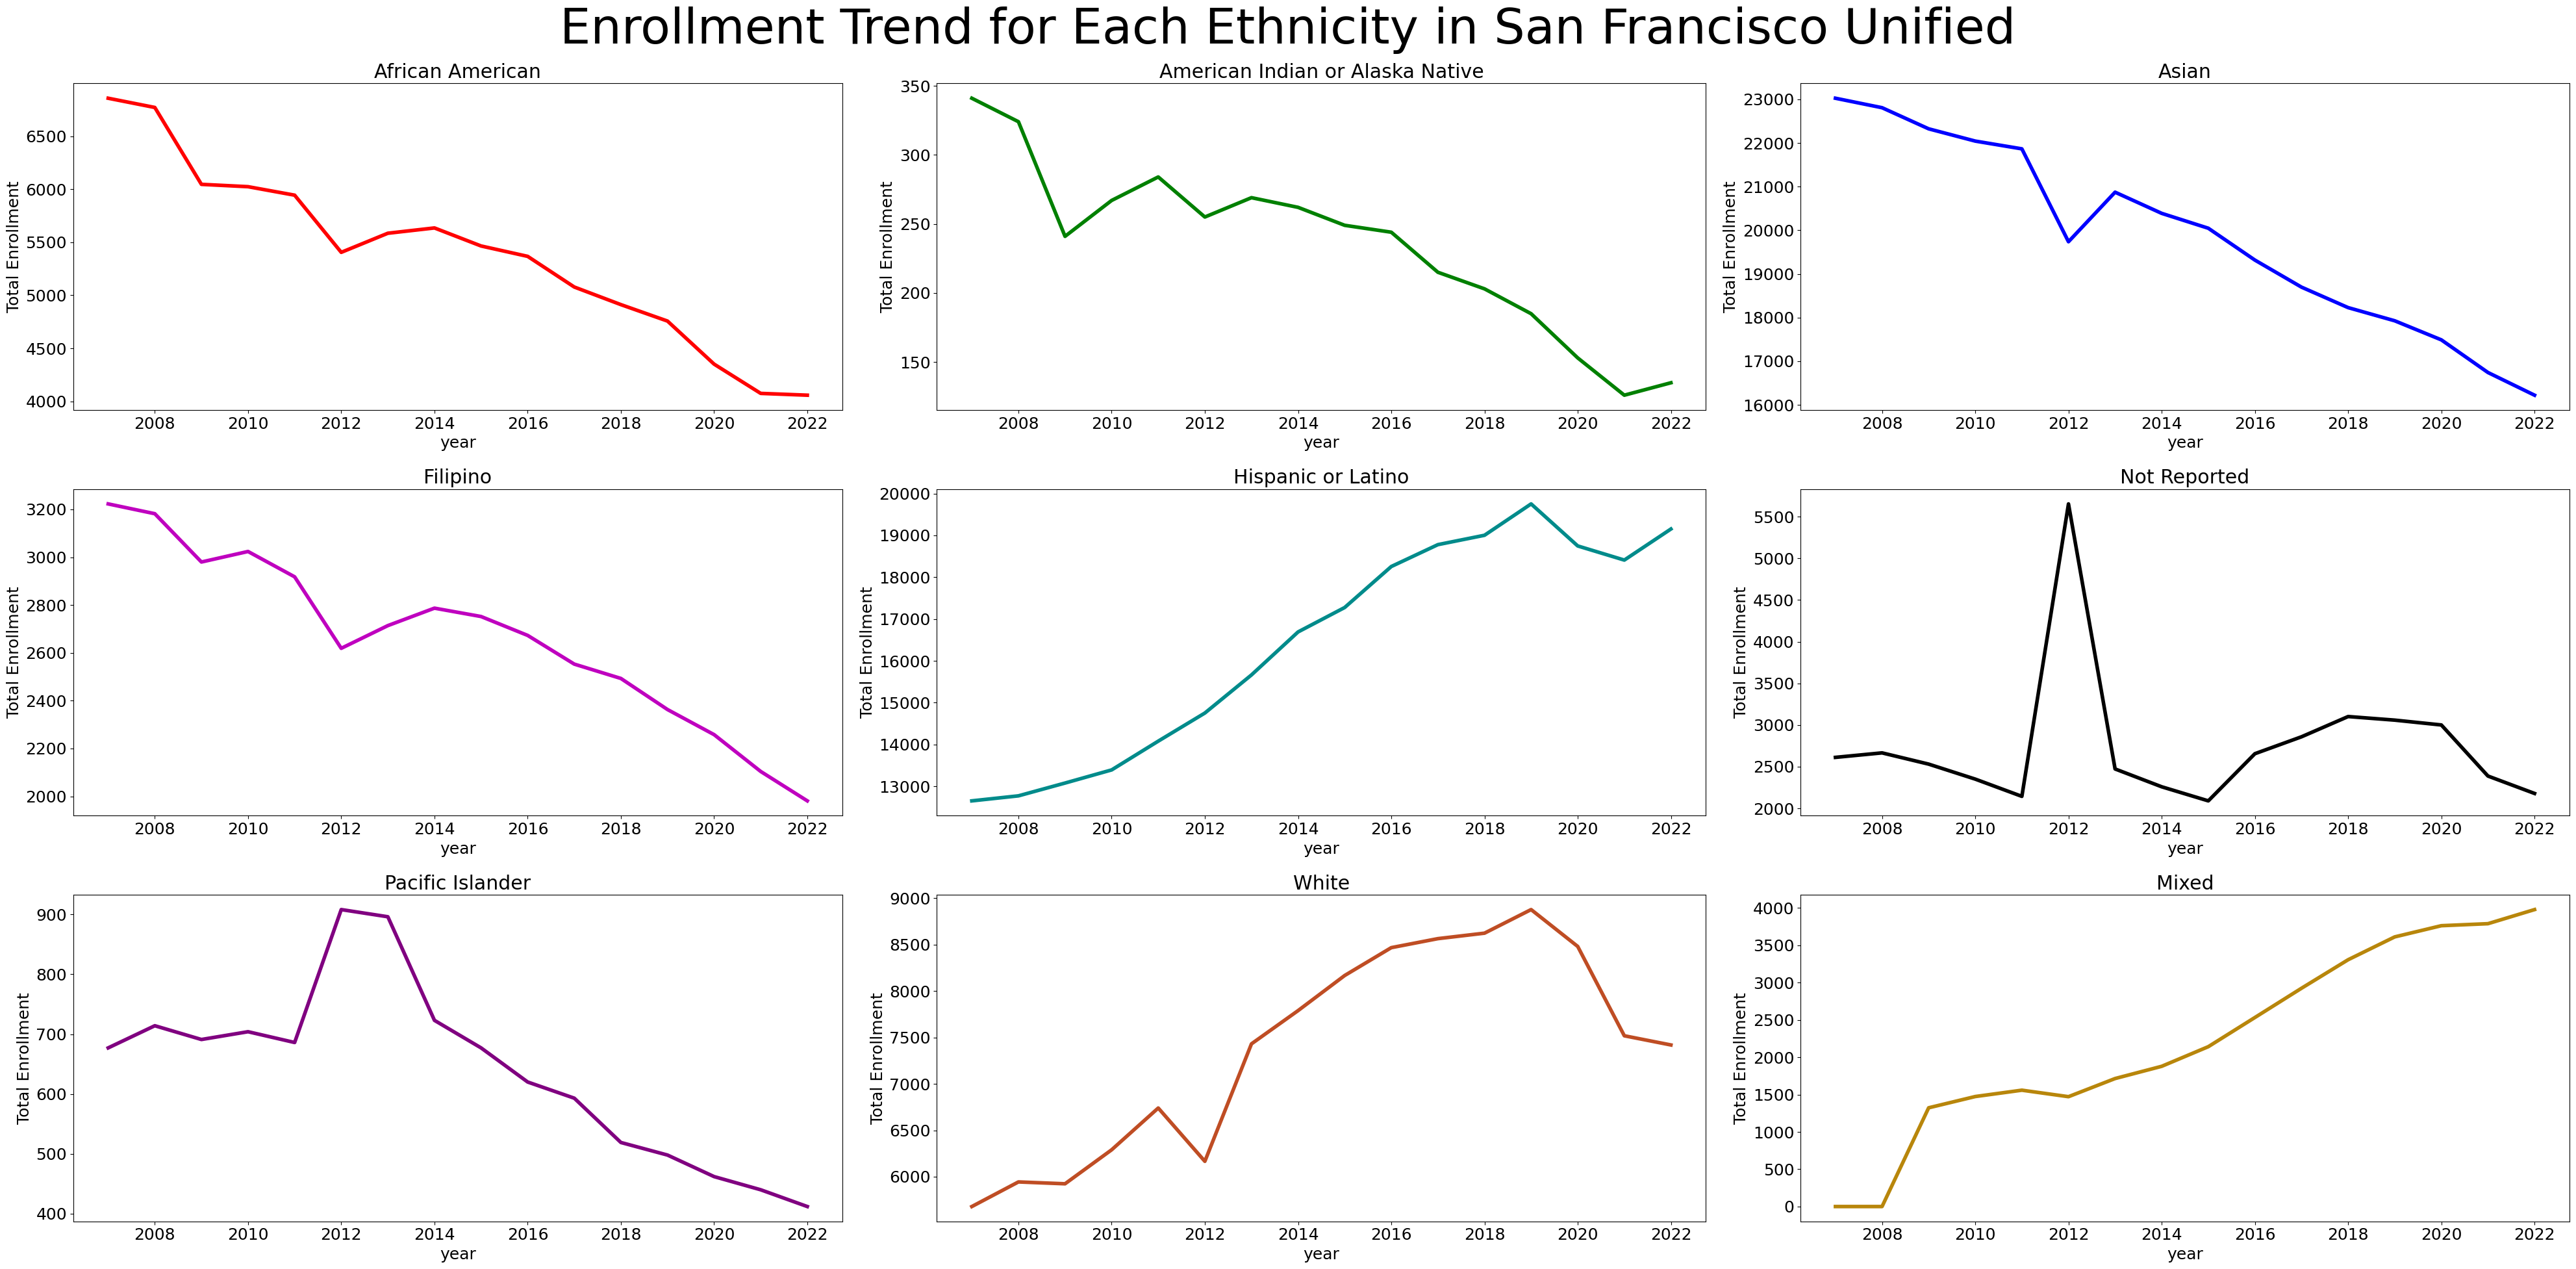

In [75]:
#their seems to some rise in the hispanic or latnio and mixed population, could this be because of
#some kind of poltics or new societal standards
ethnicity_trend(SF_district,facet=True)

### looking at top schools distribution in gender/ethnicity

#### Five Keys Independence HS (SF Sheriff's)

["Asian's: 1.19%",
 "African American's: 22.46%",
 "Hispanic or Latino's: 60.88%",
 'Mixed: 3.58%',
 'White: 9.18%',
 'Filipino: 0.73%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 1.06%",
 'Not Reported: 0%']

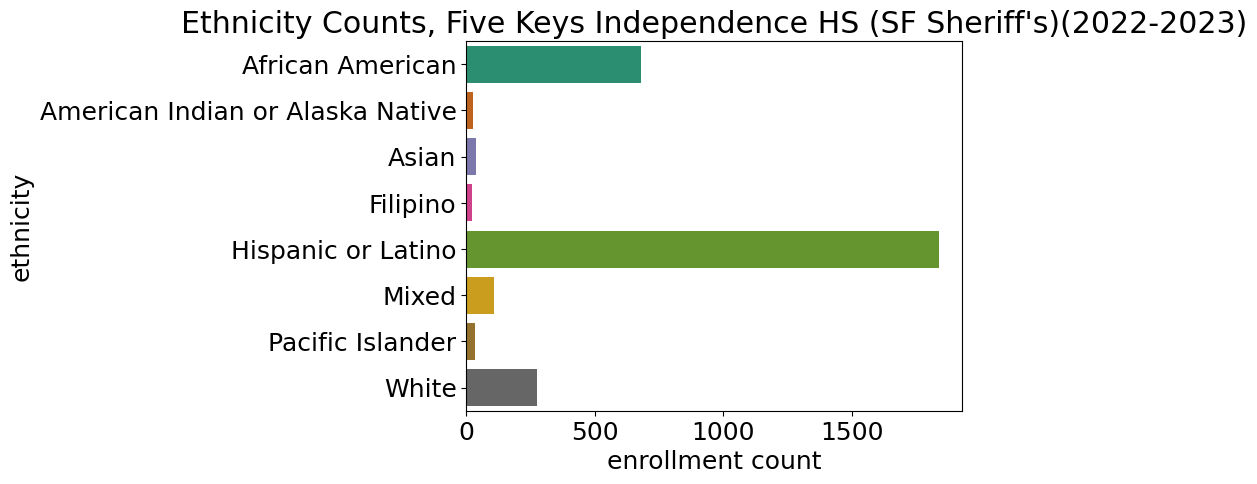

In [76]:
#recent ethnic info
ethnicity_stat(2022,"Five Keys Independence HS (SF Sheriff's)",is_district=False)

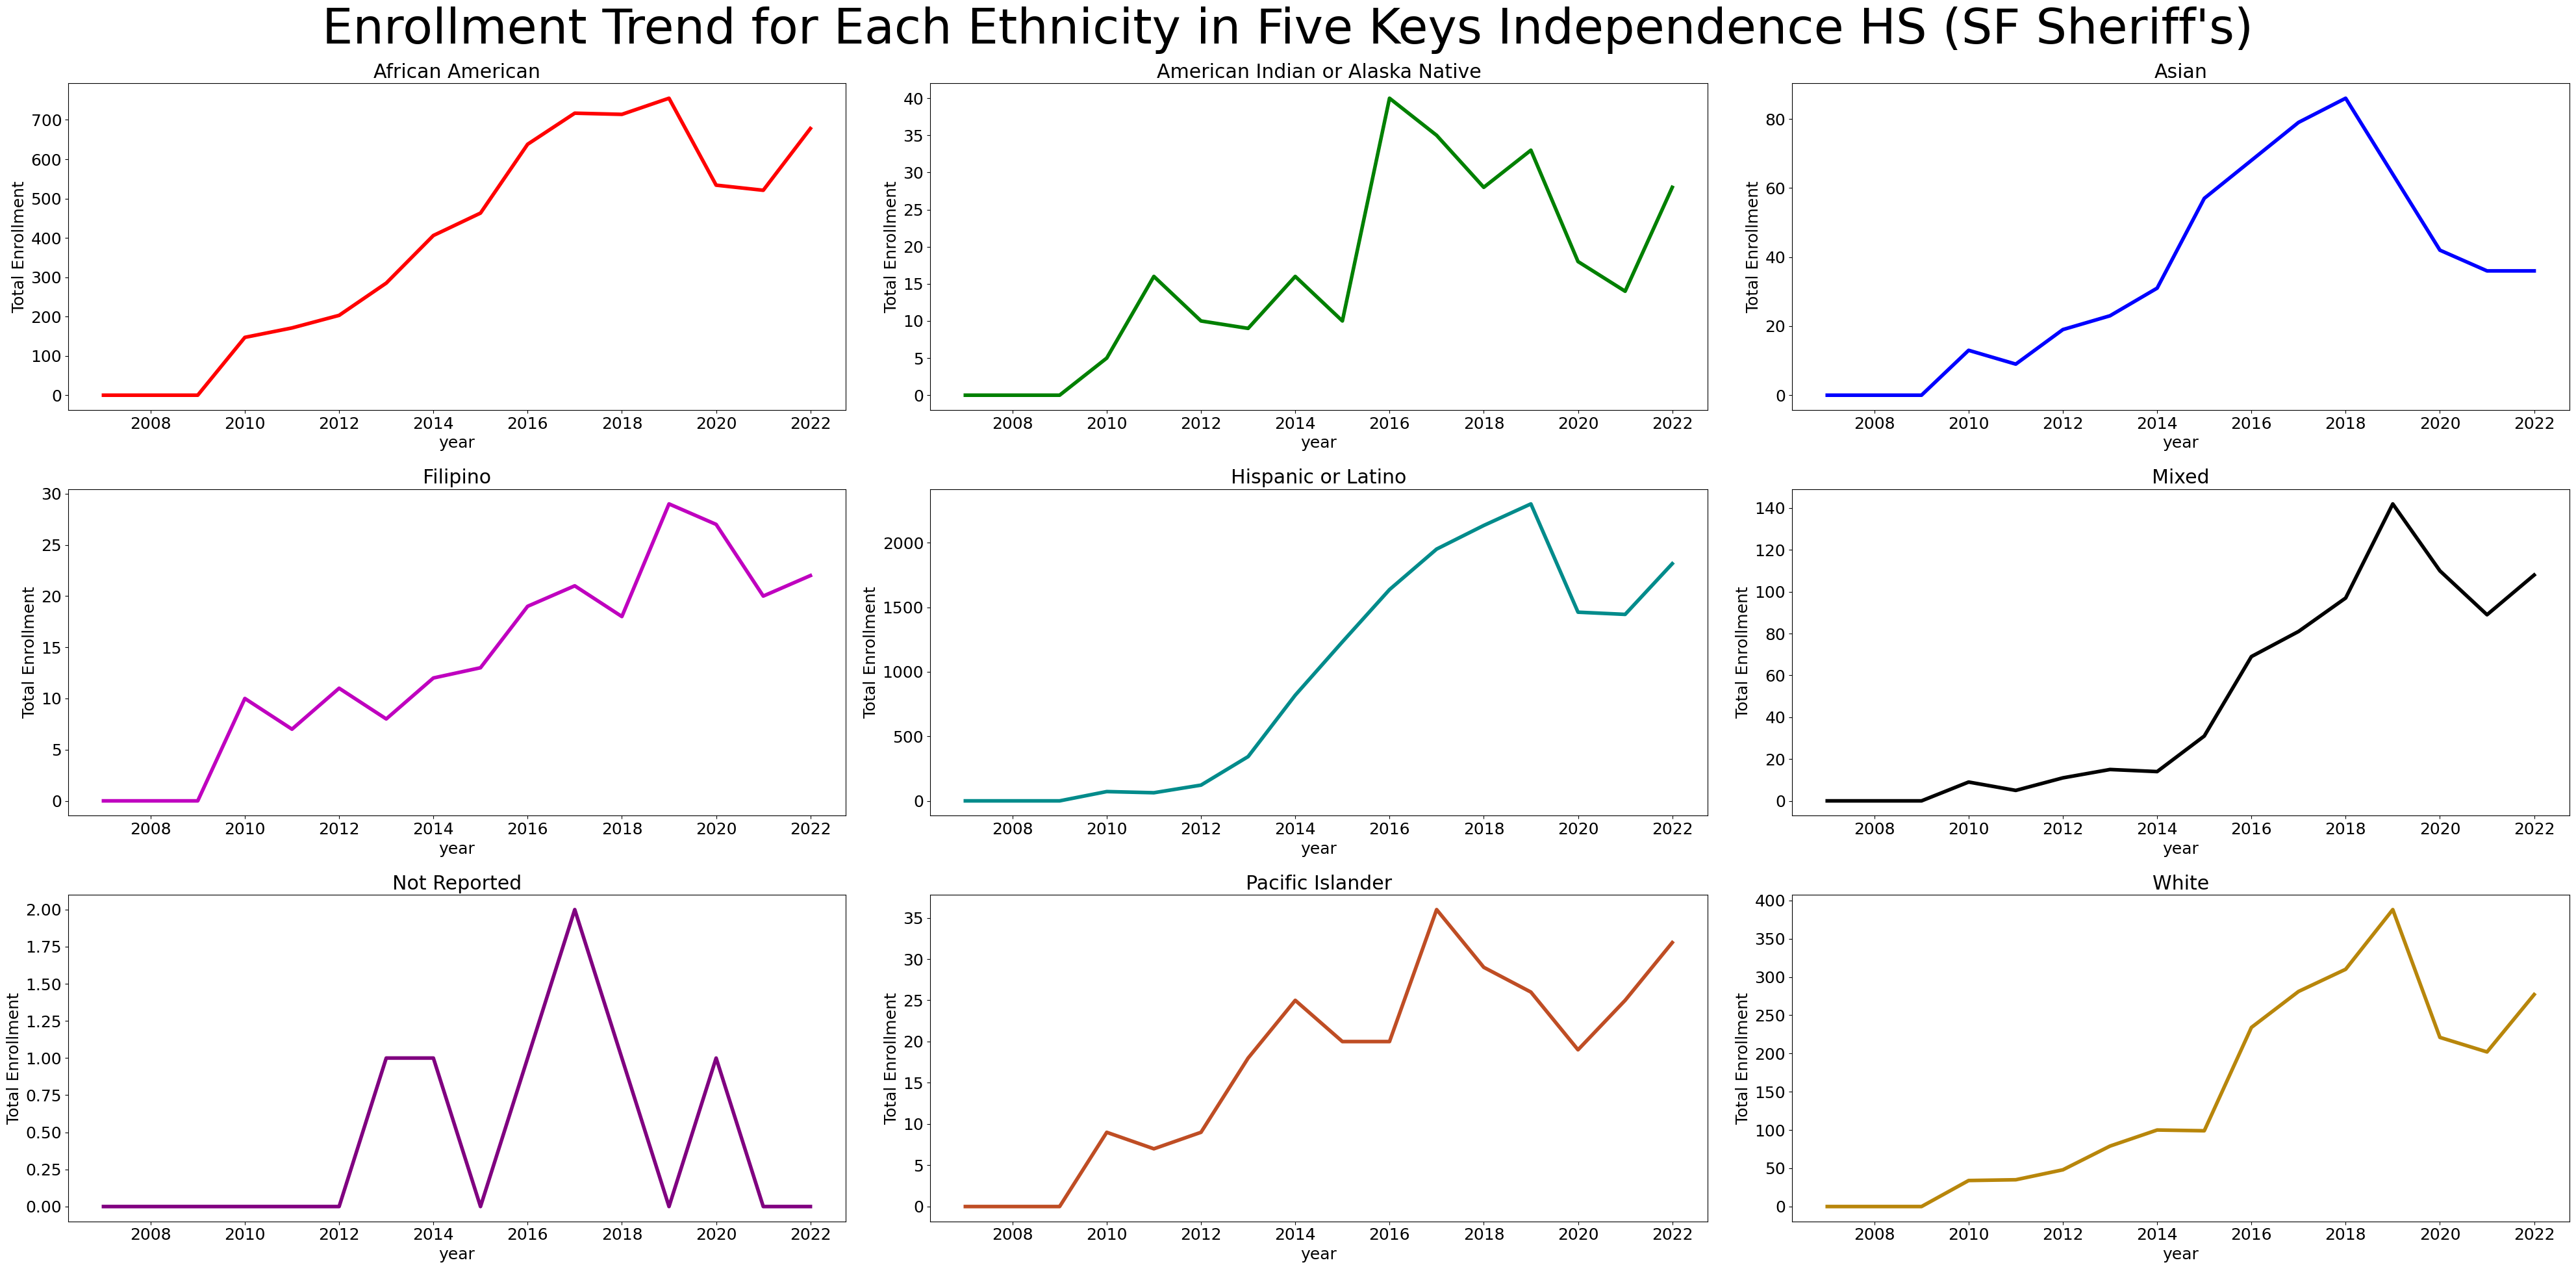

In [77]:
ethnicity_trend("Five Keys Independence HS (SF Sheriff's)",is_district=False,facet=True)

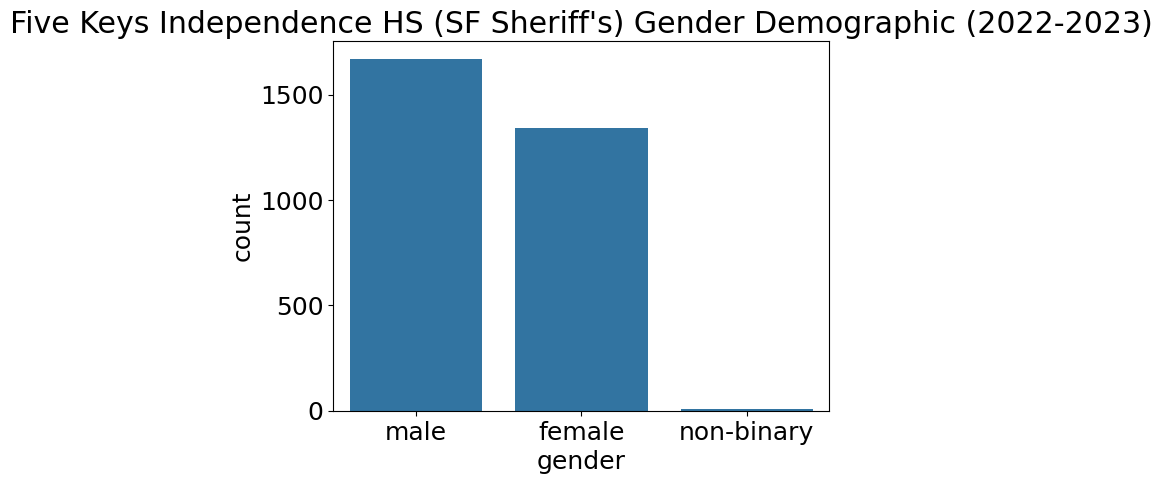

"At Five Keys Independence HS (SF Sheriff's), males make up 55%, females make up 44%, and non-binary students make up 0% with a total of 3019 students in 2022-2023"

In [78]:
gender_stat(2022,"Five Keys Independence HS (SF Sheriff's)",is_district=False)

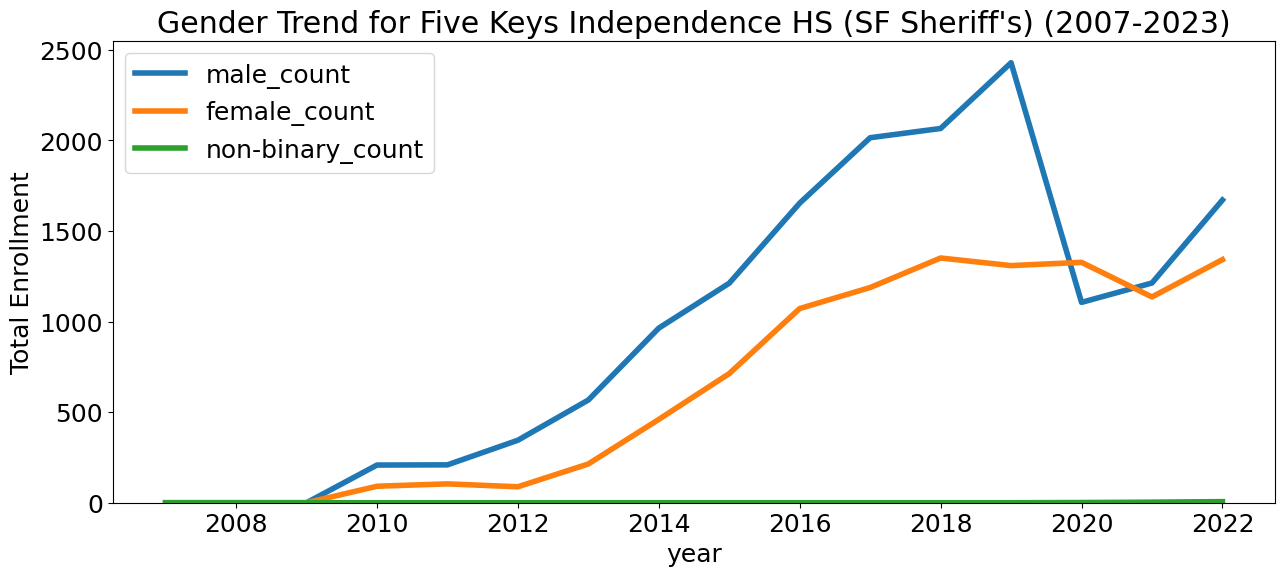

In [79]:
gender_trend("Five Keys Independence HS (SF Sheriff's)",is_district=False)

#### Lowell High

["Asian's: 46.66%",
 "African American's: 2.74%",
 "Hispanic or Latino's: 17.74%",
 'Mixed: 7.07%',
 'White: 16.79%',
 'Filipino: 5.78%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 0.42%",
 'Not Reported: 2.58%']

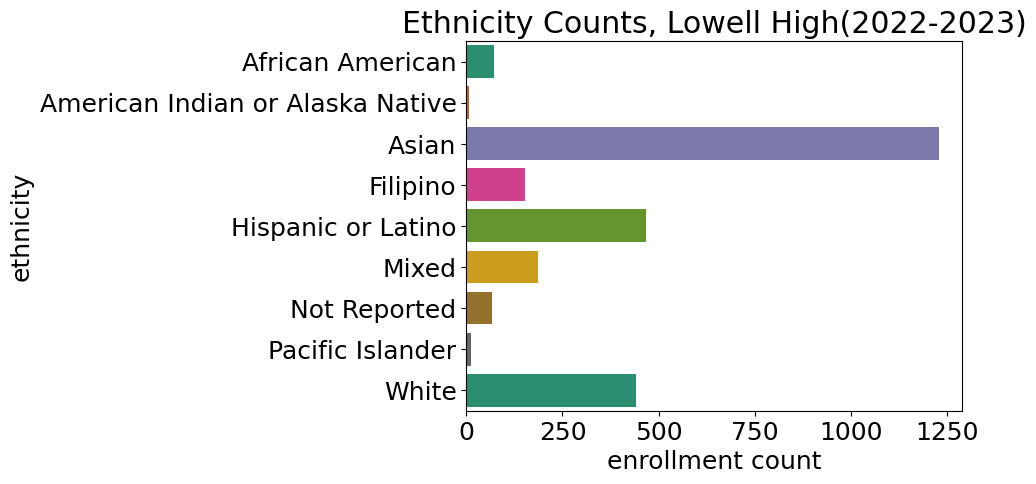

In [80]:
#recent ethnic info
ethnicity_stat(2022,"Lowell High",is_district=False)

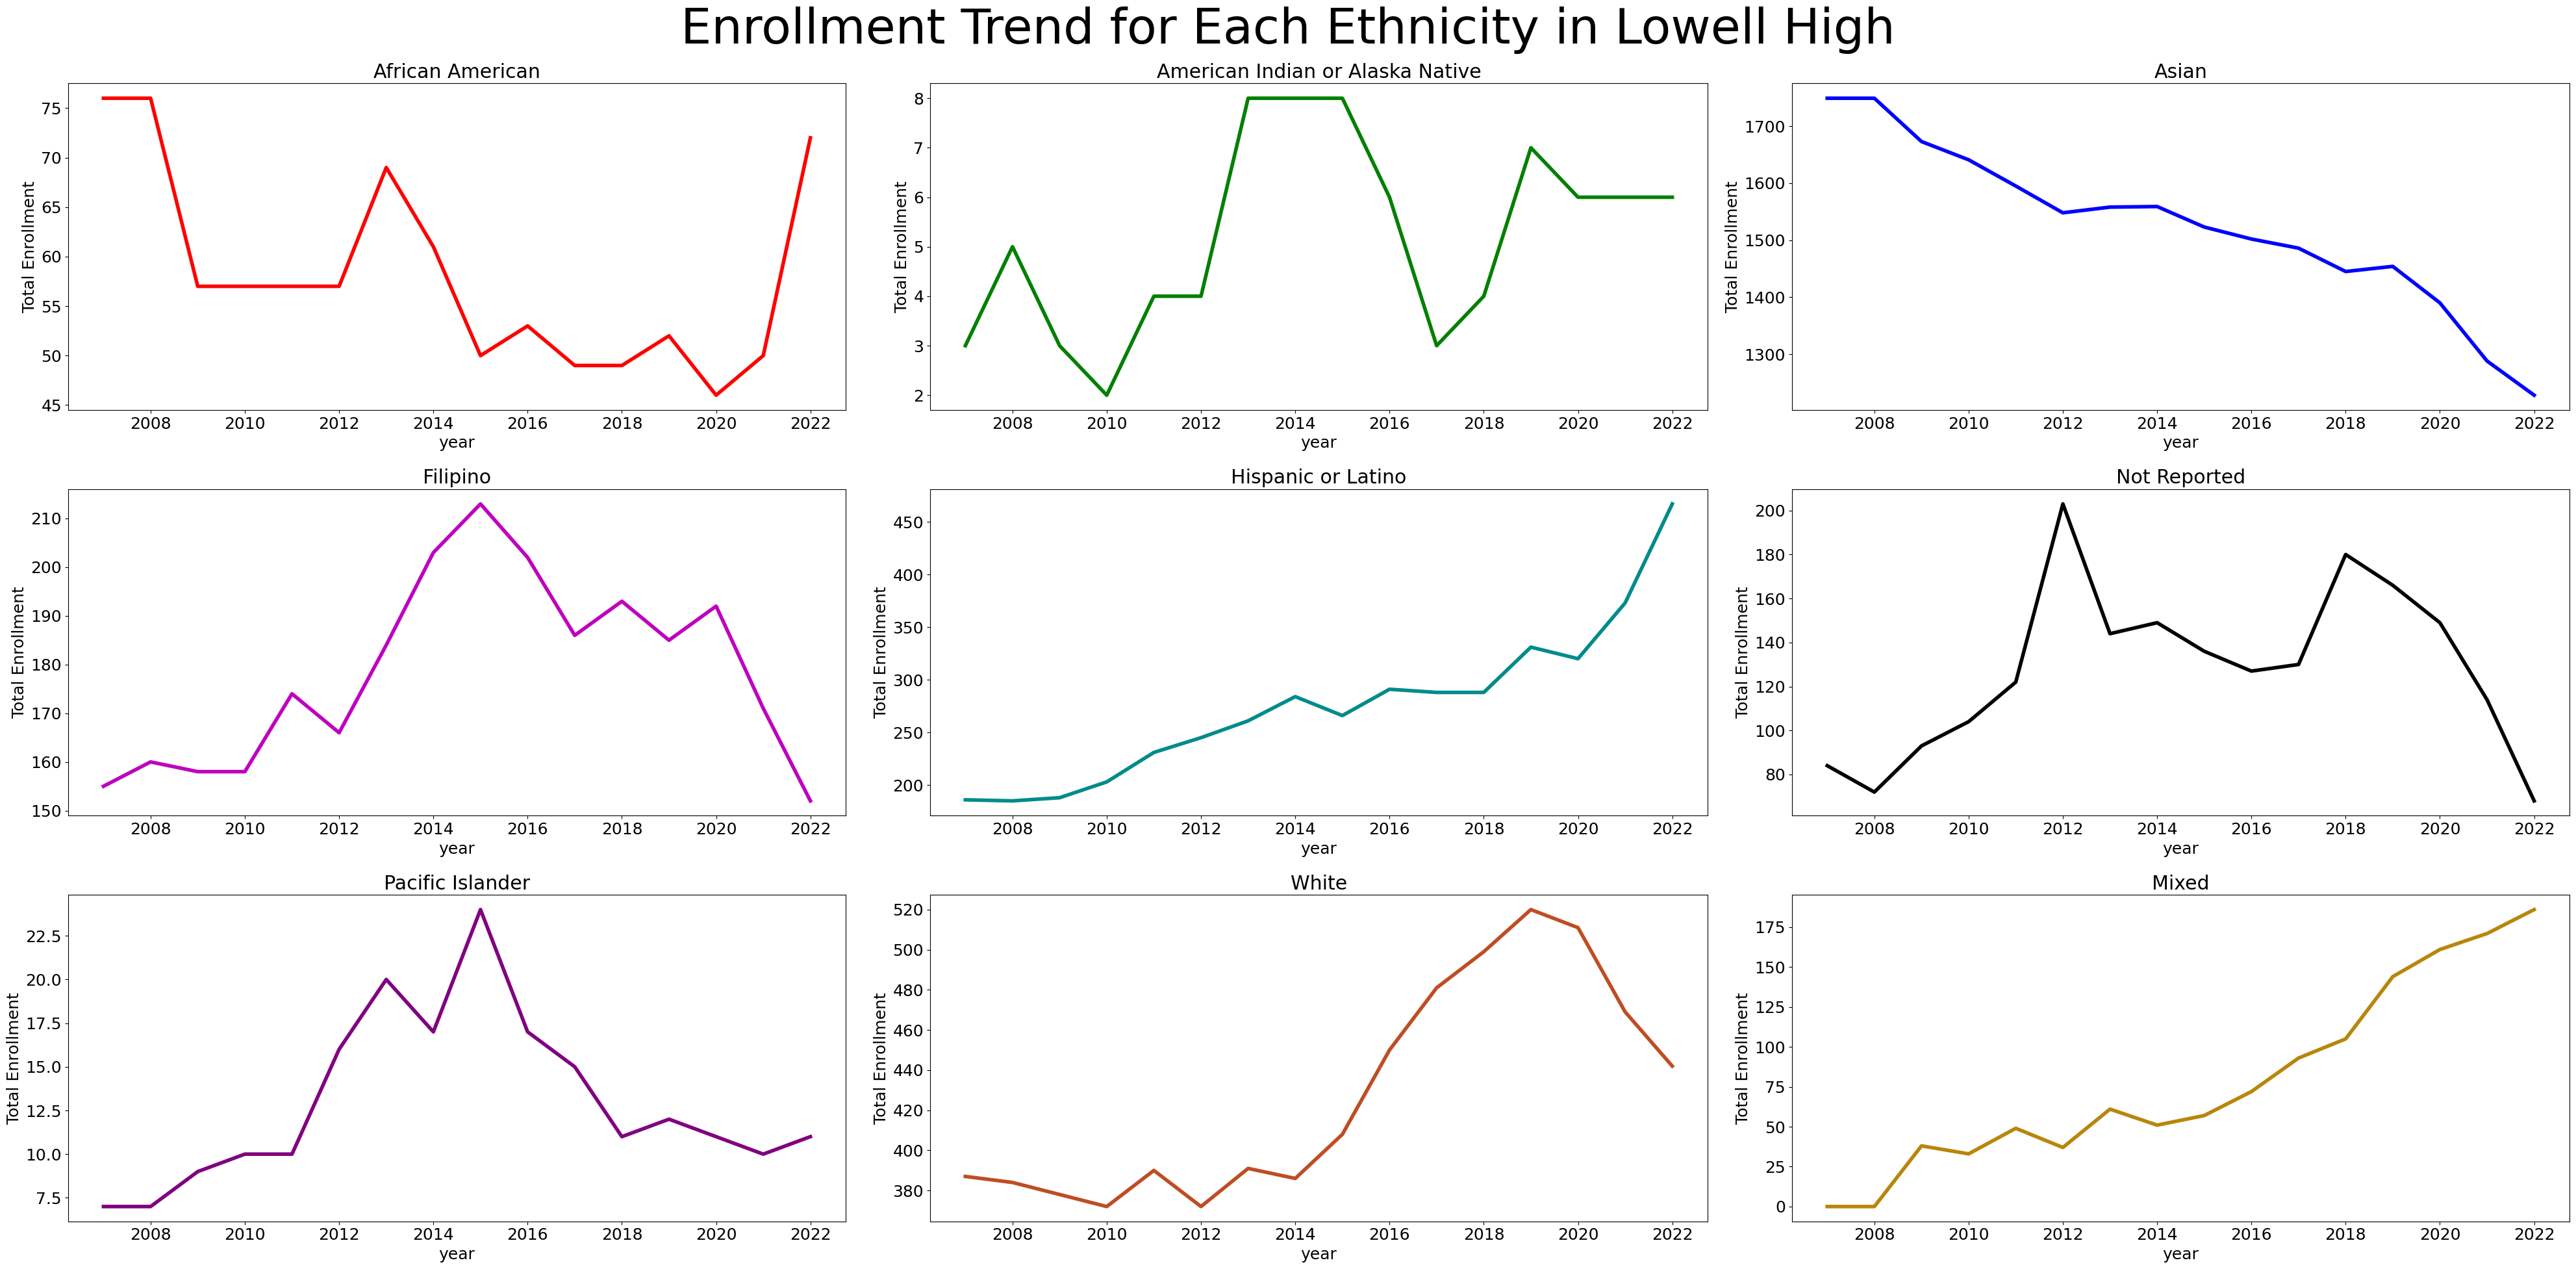

In [81]:
ethnicity_trend("Lowell High",is_district=False,facet=True)

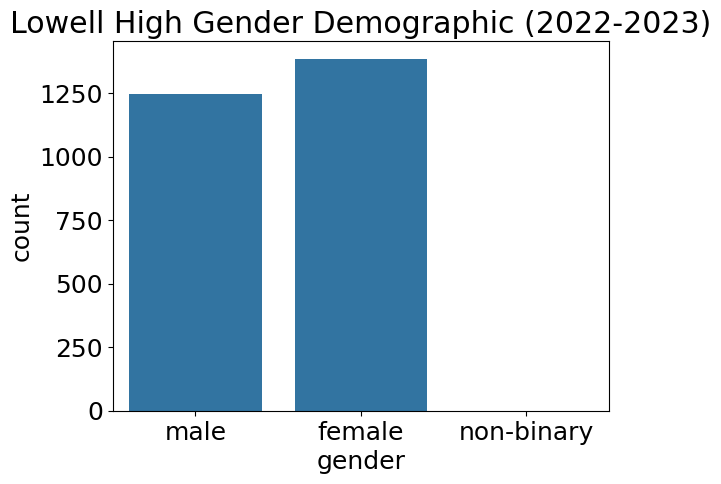

'At Lowell High, males make up 47%, females make up 52%, and non-binary students make up 0% with a total of 2632 students in 2022-2023'

In [82]:
gender_stat(2022,"Lowell High",is_district=False)

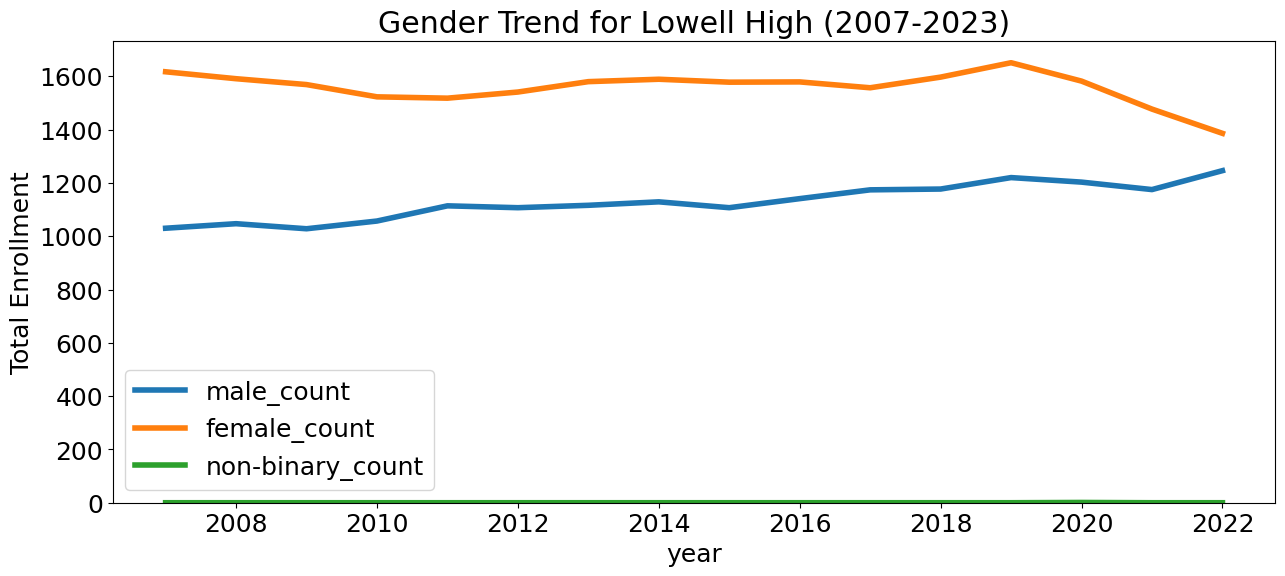

In [83]:
gender_trend("Lowell High",is_district=False)

#### Predicting Future Total Enrollment for SF


'The projection of total enrollment for San Francisco Unified in 2050 is to be 65601. Which is 10064 more students than 2023'

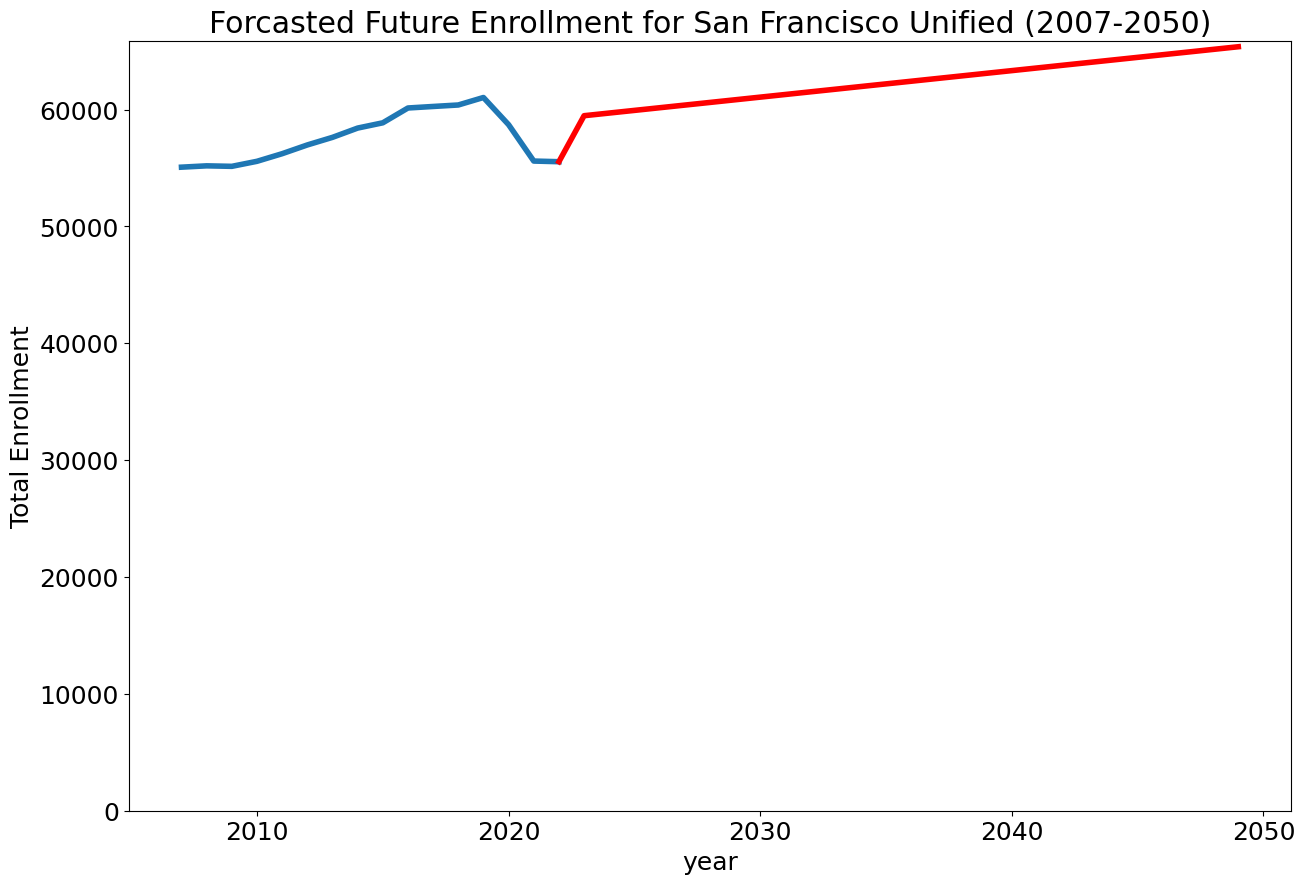

In [84]:
forecast_future_enrol(SF_district,2050)

['Predicted enrollment for Lowell High in 2050: 3007',
 "Predicted enrollment for Five Keys Independence HS (SF Sheriff's) in 2050: 10791",
 "The disparity in enrollment between Lowell High and Five Keys Independence HS (SF Sheriff's) is 7784, indicating that",
 "Five Keys Independence HS (SF Sheriff's) is projected to have more students than Lowell High in 2050."]

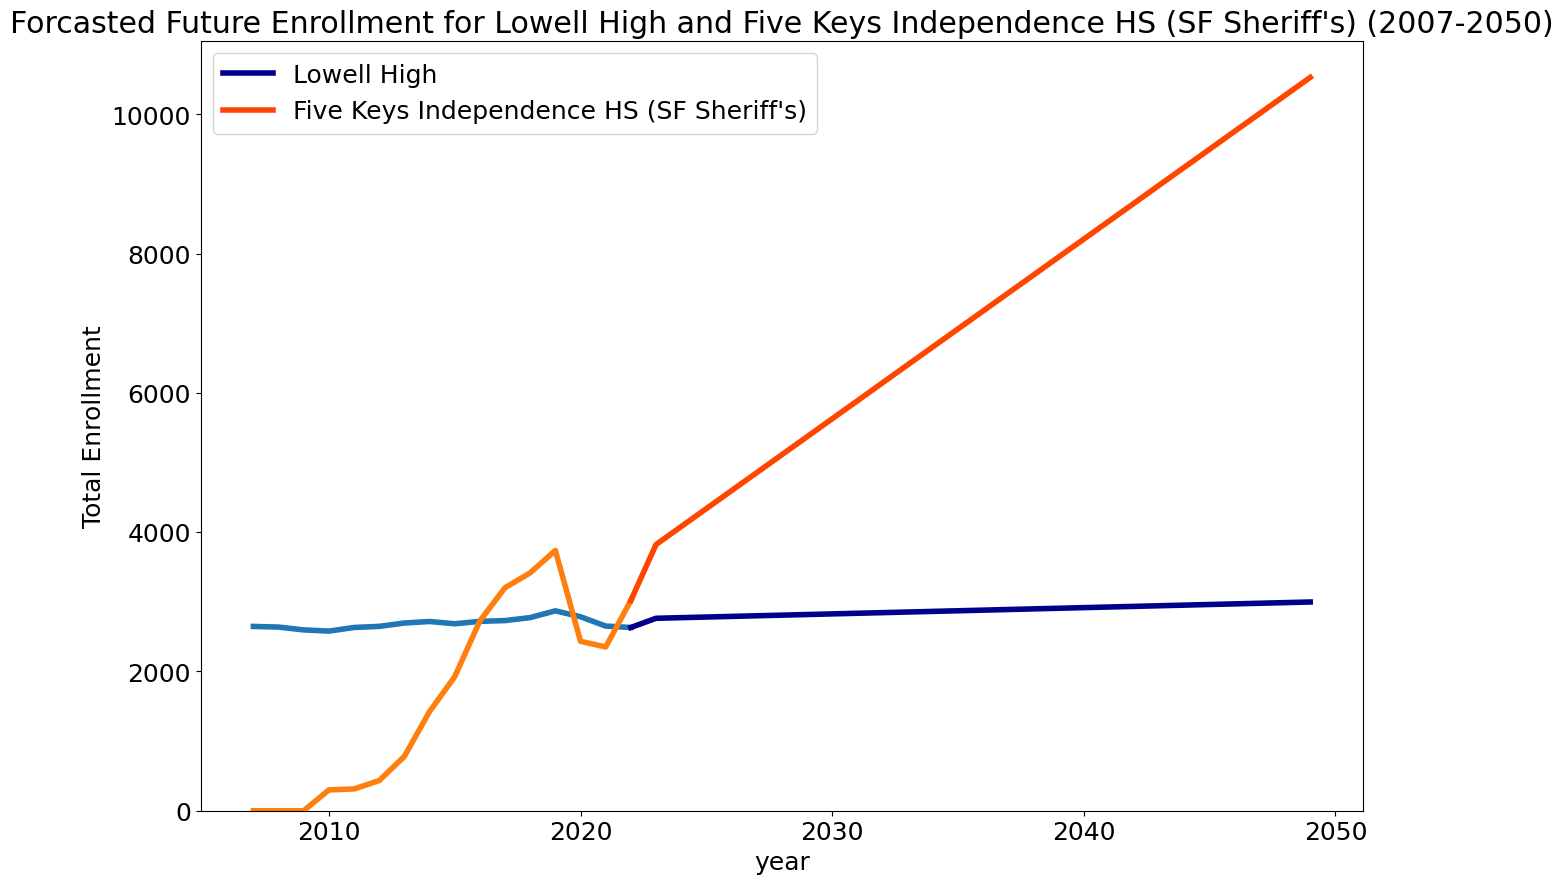

In [85]:
# Interesting graph
forecast_two_future_enrol('Lowell High',"Five Keys Independence HS (SF Sheriff's)",2050,is_district=False)

## Los Angeles Query

In [86]:
search('Los Ang')

array(['Los Angeles Unified', 'Los Angeles County Office of Education',
       'CEA Los Angeles Co', 'SBE - Prepa Tec Los Angeles High',
       'SBE - Los Angeles College Prep Academy'], dtype=object)

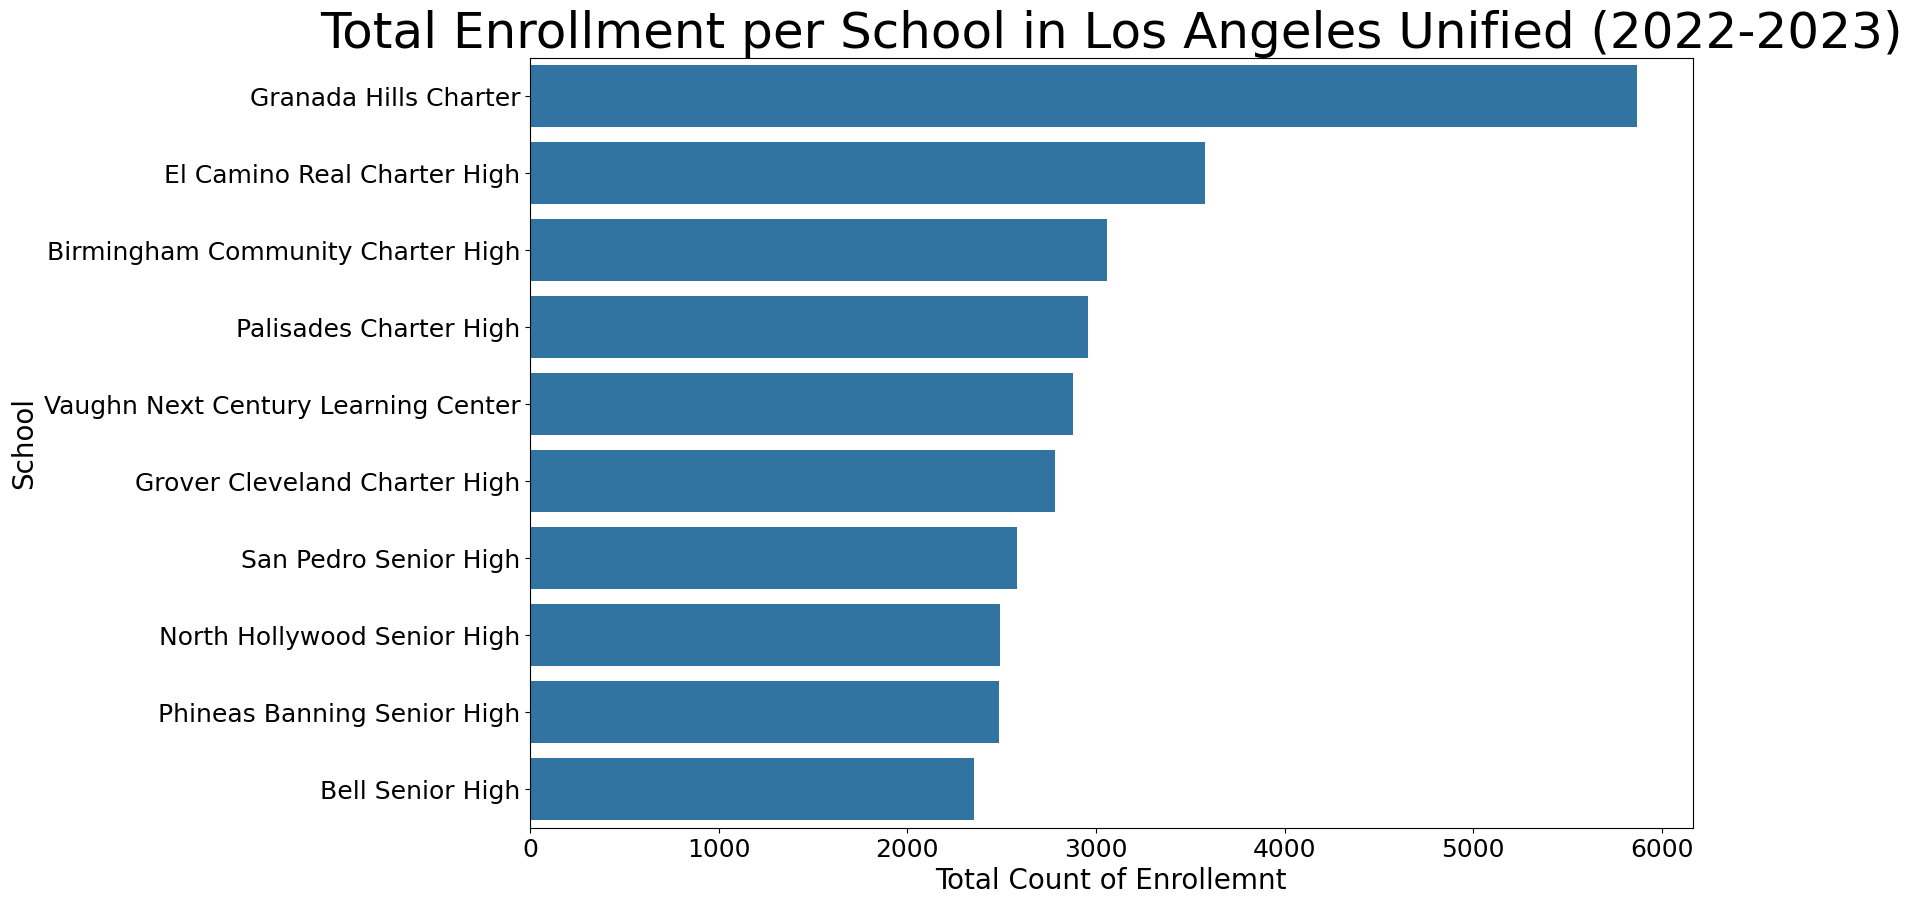

In [87]:
LA_district = 'Los Angeles Unified'
total_enr_dist(2022,LA_district)

## LA and Enrollment

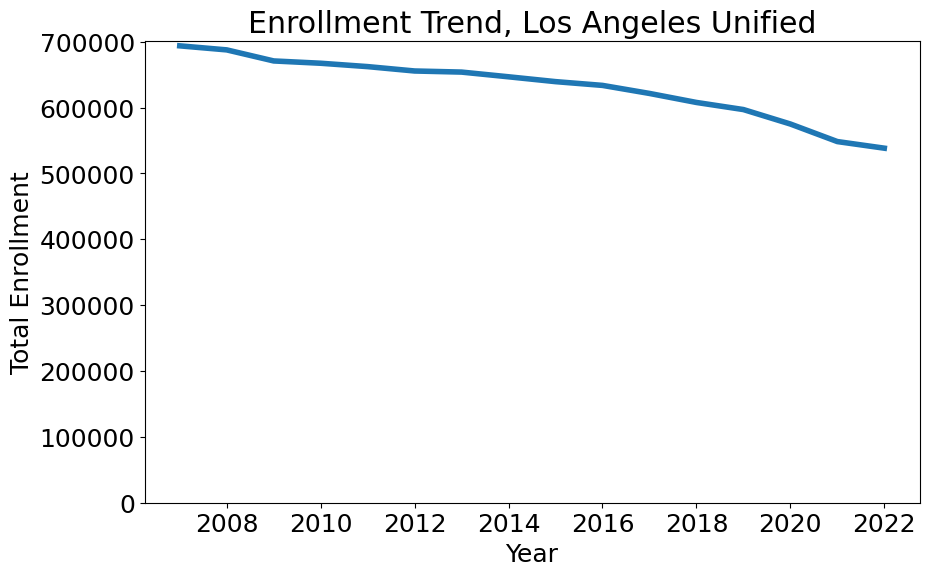

In [88]:
#has consintenly been over 500,000 over the past decade
trend_enroll(LA_district)

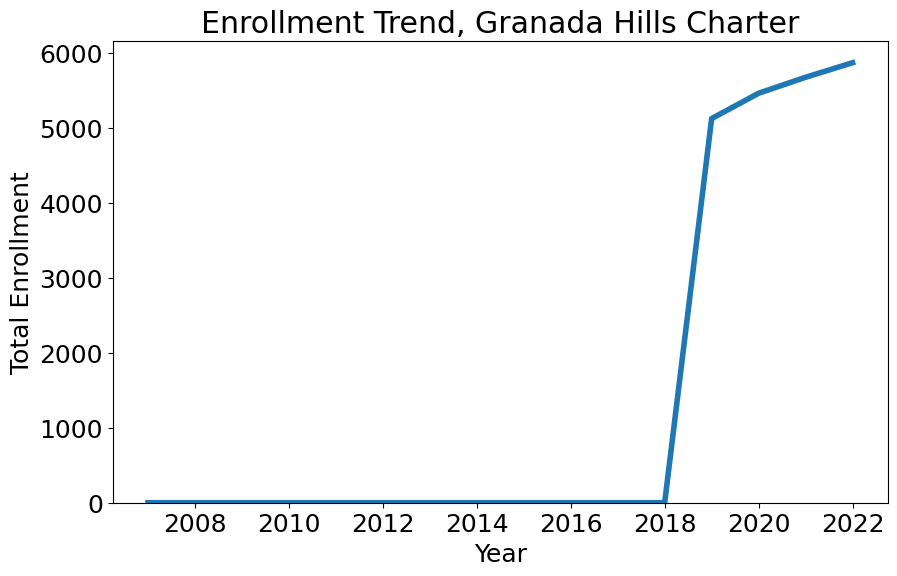

In [89]:
#my guess is that data just got added for this school
trend_enroll('Granada Hills Charter',is_district=False)

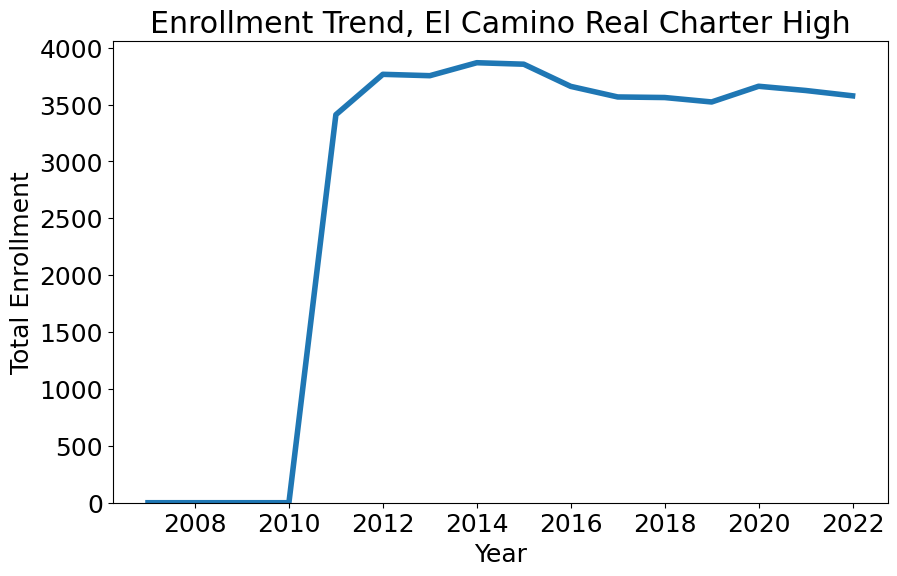

In [90]:
trend_enroll('El Camino Real Charter High',is_district=False)


## LA Demographics (Gender/Ethnicity)

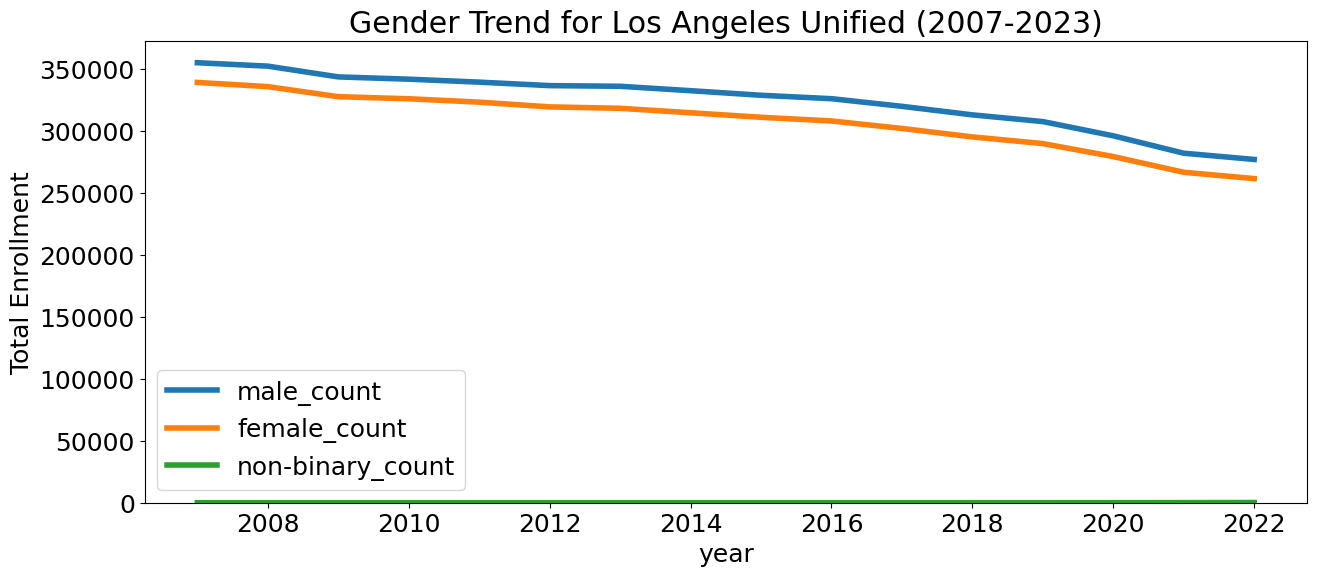

In [91]:
gender_trend(LA_district)

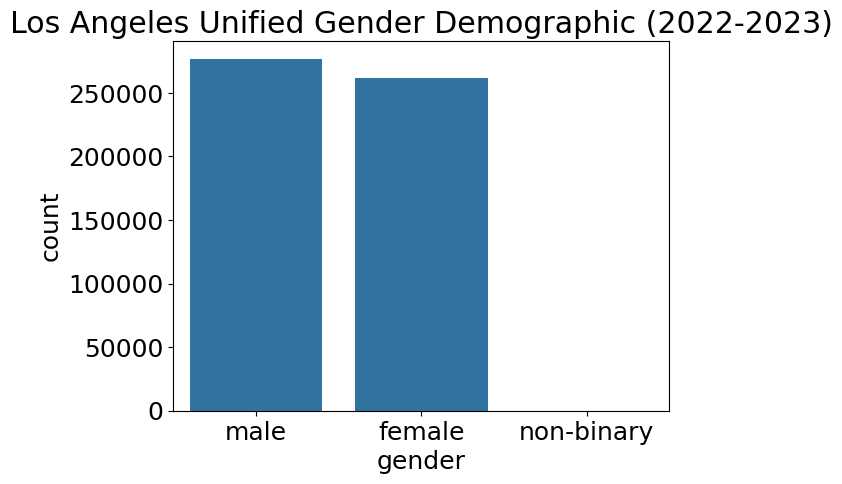

'At Los Angeles Unified, males make up 51%, females make up 48%, and non-binary students make up 0% with a total of 538295 students in 2022-2023'

In [92]:
gender_stat(2022,LA_district)

["Asian's: 1.72%",
 "African American's: 3.81%",
 "Hispanic or Latino's: 74.15%",
 'Mixed: 0.55%',
 'White: 4.81%',
 'Filipino: 0.81%',
 'American Indian or Alaska Native: 0%',
 "Pacific Islander's: 0.11%",
 'Not Reported: 13.94%']

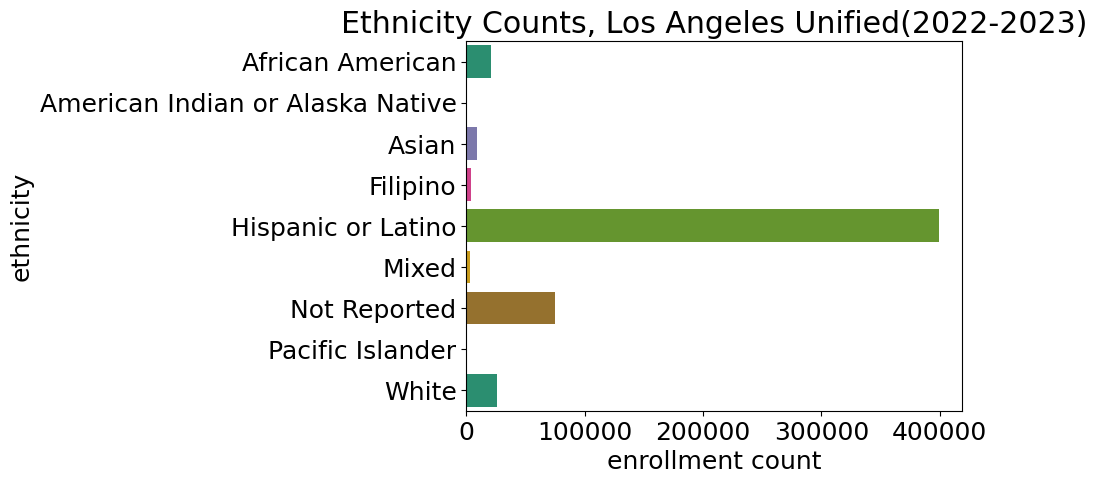

In [93]:
ethnicity_stat(2022,LA_district)

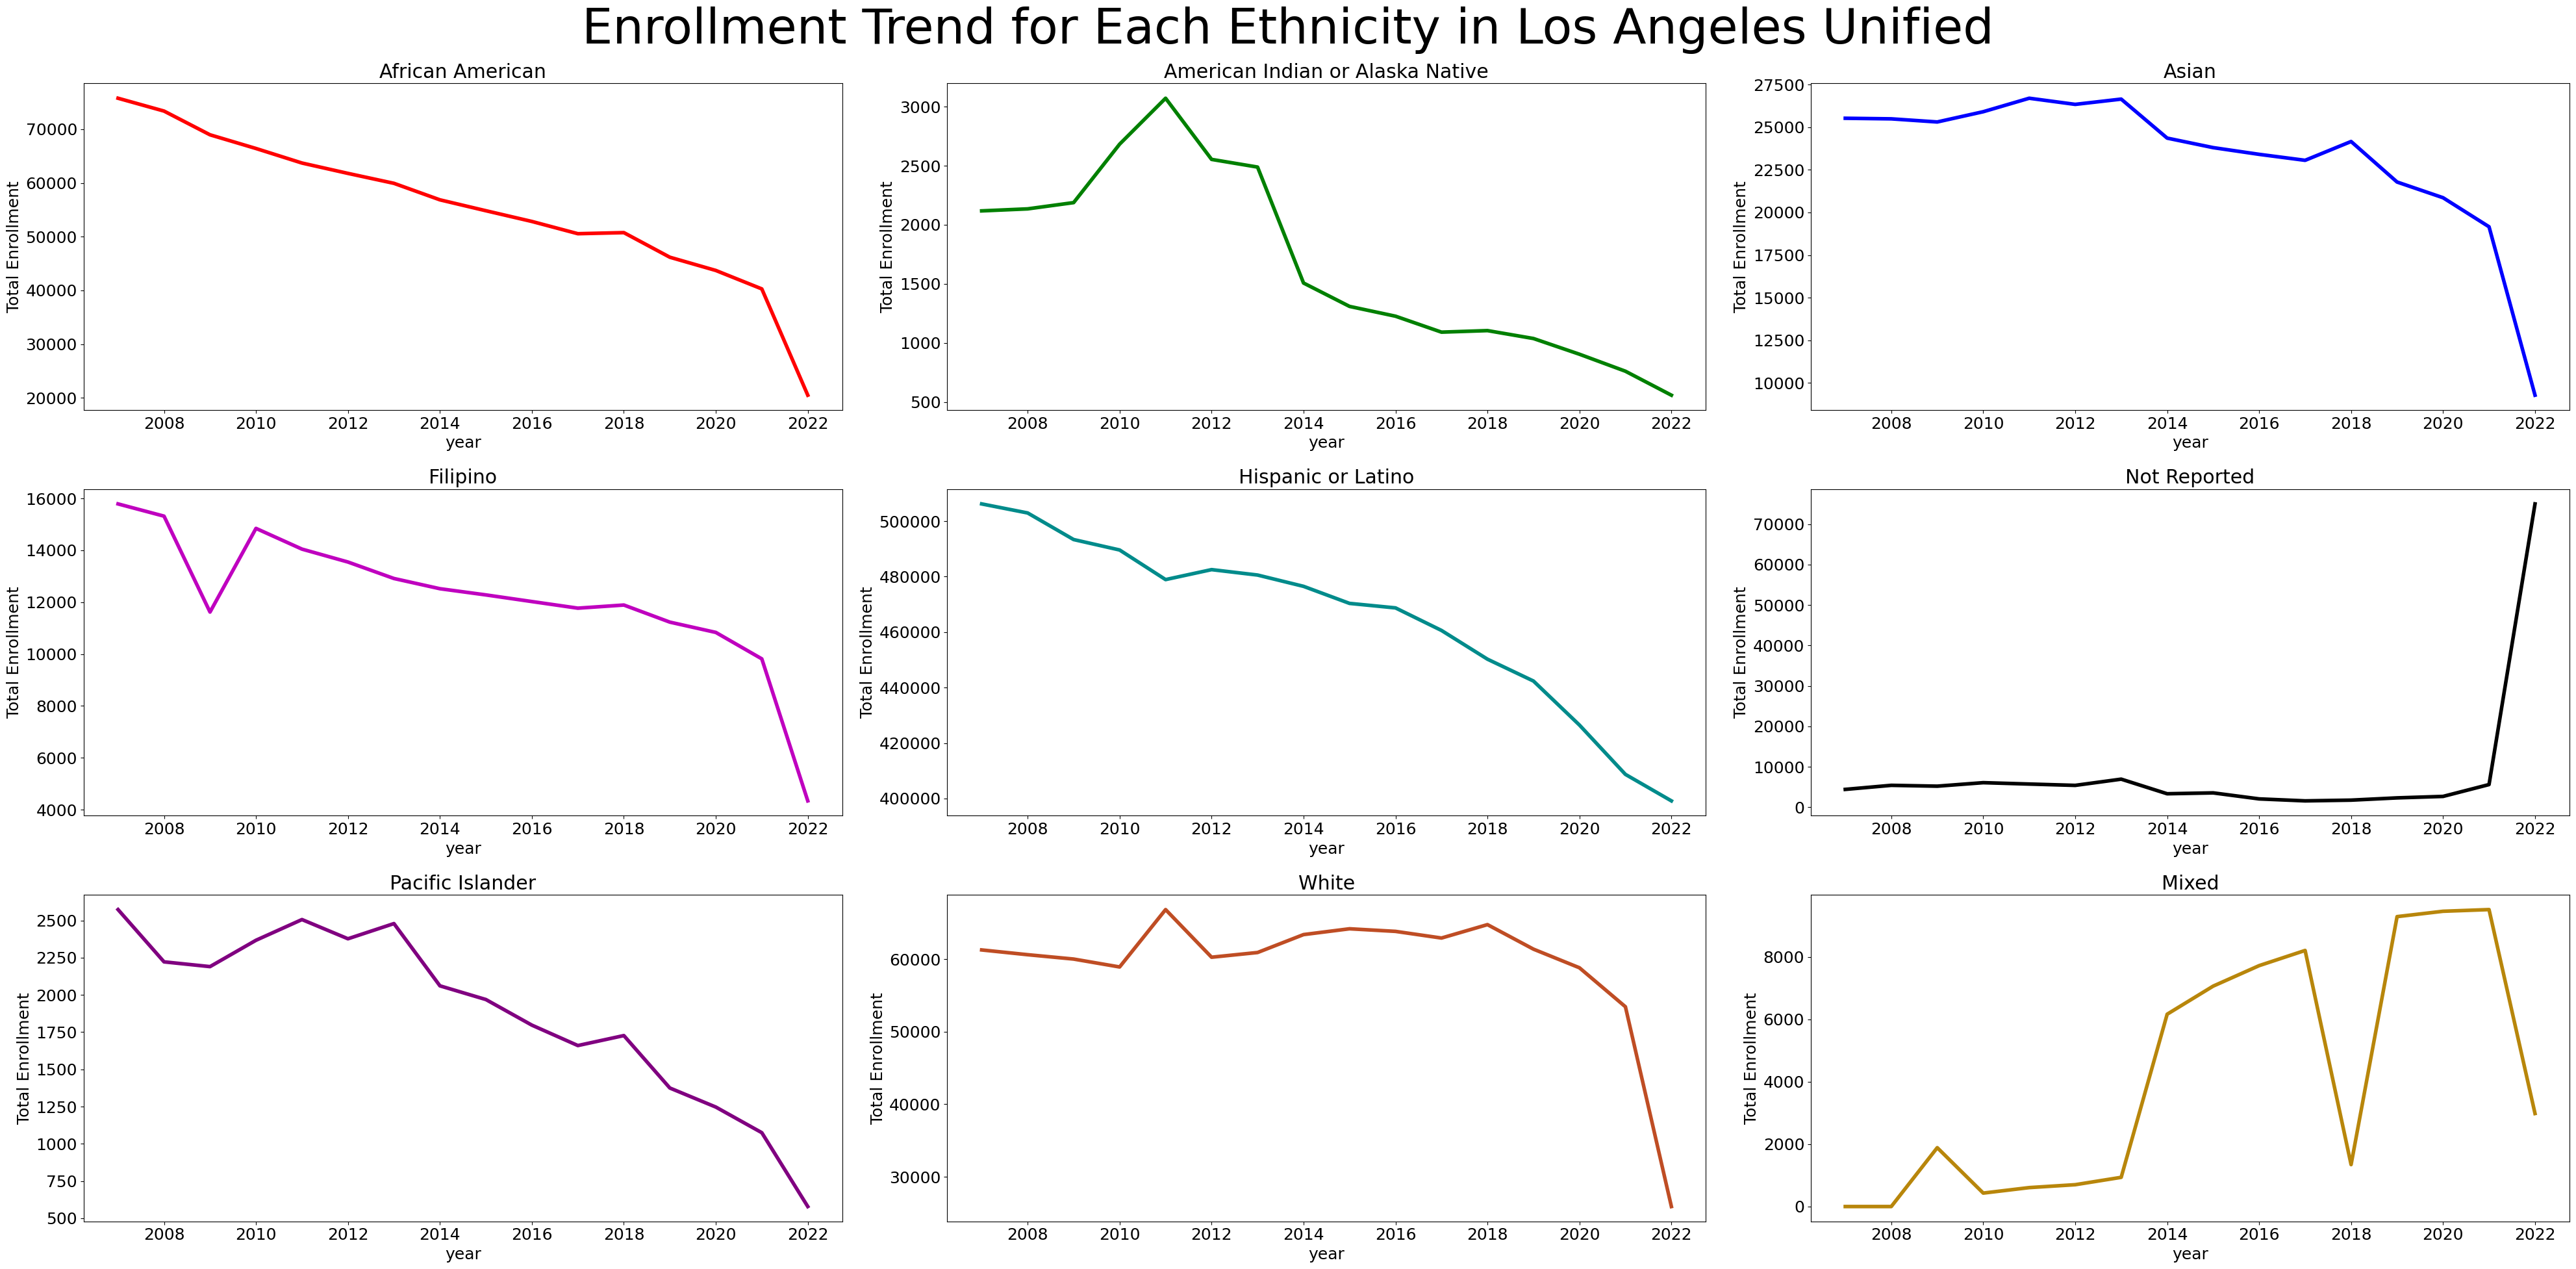

In [94]:
#it seems that the total enrollment for each ethnicty has been dropping except for 'Not Reported'
ethnicity_trend(LA_district,facet=True)

#### Predicting Future Total Enrollment for LA


'The projection of total enrollment for Los Angeles Unified in 2050 is to be 294624. Which is -243671 more students than 2023'

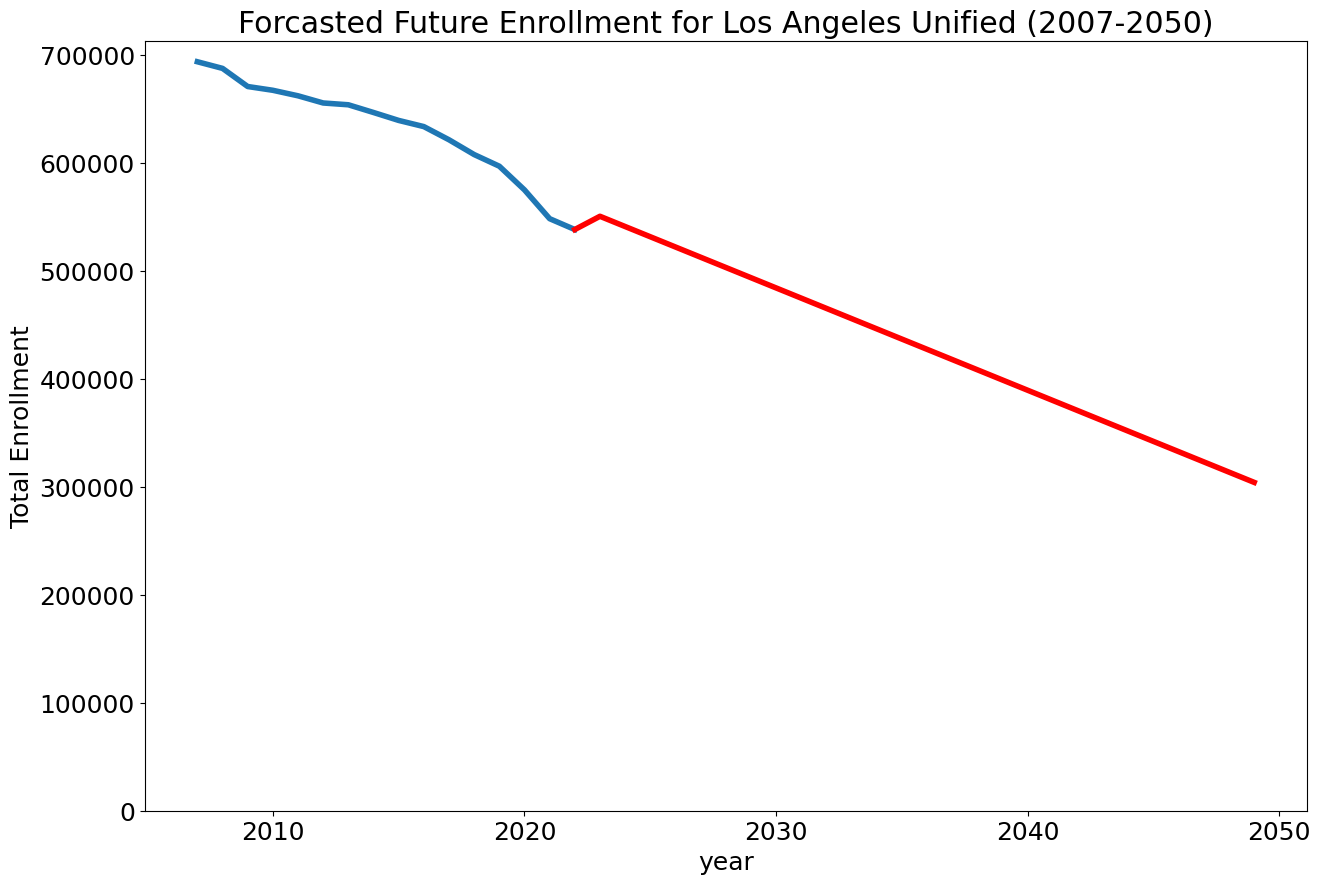

In [95]:
# it seems that LA schools could be seeing a decrease in enrollment in the next 20 years
forecast_future_enrol(LA_district,2050)

['Predicted enrollment for Granada Hills Charter in 2050: 15375',
 'Predicted enrollment for El Camino Real Charter High in 2050: 11745',
 'The disparity in enrollment between Granada Hills Charter and El Camino Real Charter High is 3630, indicating that Granada Hills Charter is projected to have more students than El Camino Real Charter High in 2050.']

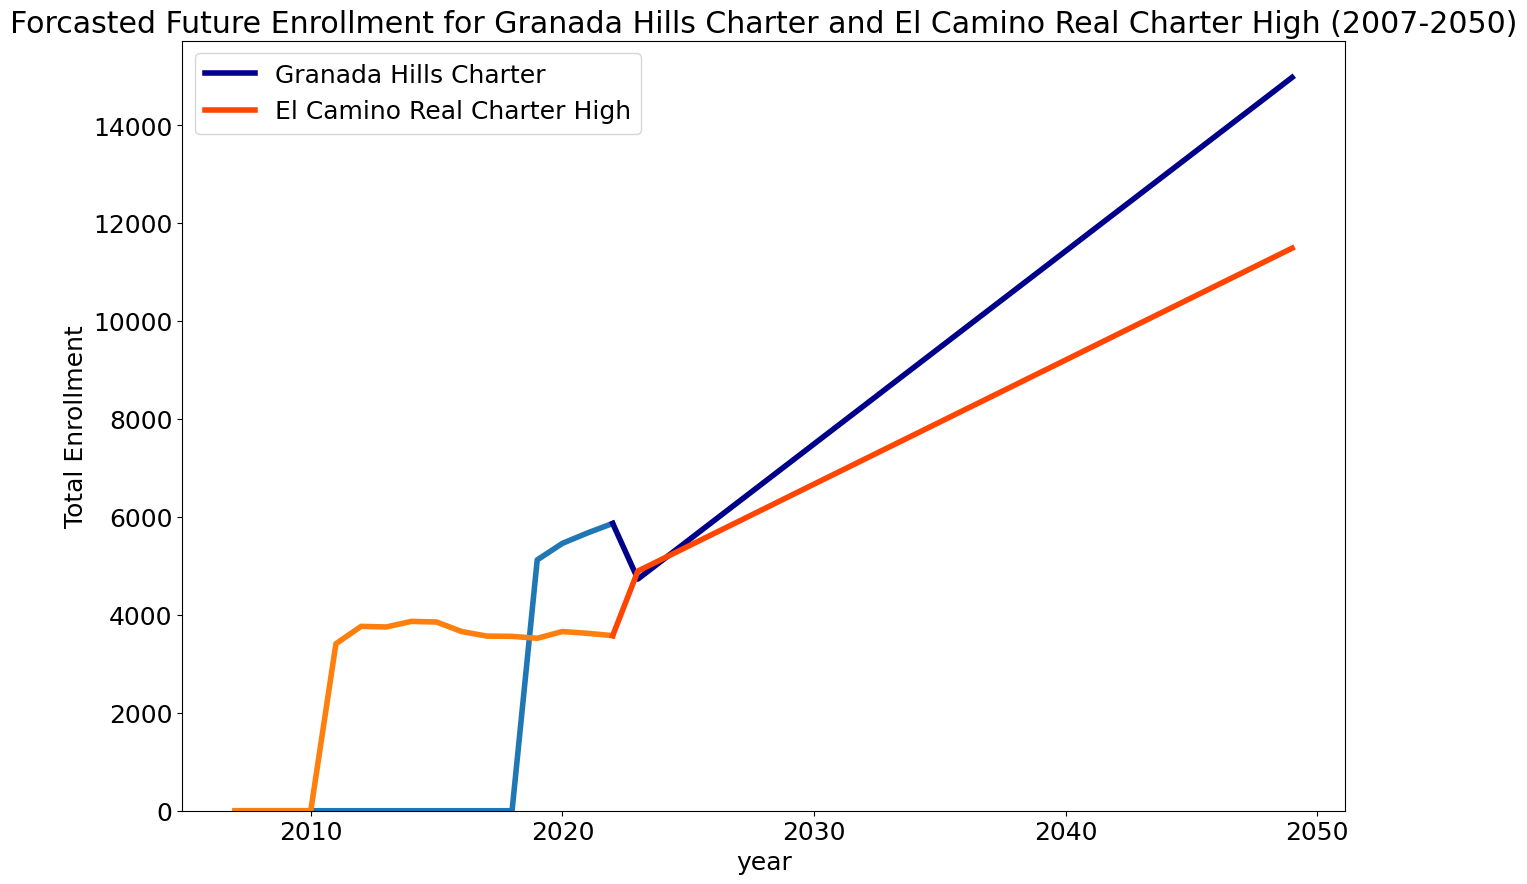

In [96]:
forecast_two_future_enrol('Granada Hills Charter','El Camino Real Charter High',2050,is_district=False)

## California Schools Geospatial Analysis

In [97]:
# for creating a colorbar
import matplotlib.colors as mcolors

In [129]:
def cali_area_rates(cali_area='California',dropout_rates=False):
    """
    cali_area=string dropout_rates=boolean -> subplots(12)
    
    Will take up 1-2min to load
    
    by default returns all of California with the graduation rates for each county unless
    
    one of the following regions of california is specified:
    Northen California,
    Bay Area,
    Central California,
    Soutern California
    

    returns a subplot for the school years in 2009-2023
    with the graduate rates by default
    or for the dropout rates if set as True
    
    """
    # defining constants
    
    # define the distinct school years and its count
    rates_school_years = pd.unique(geo_county_df.academic_year)
    num_school_years = len(rates_school_years)
    range_school_years = np.arange(num_school_years)


    # list of dataframes for each school year
    ## filtering for each school year
    yearly_rate_dfs = [geo_county_df.loc[geo_county_df.academic_year == year] for year in rates_school_years]
    
    # coords for regions in cali in the format [xmi,xmax,ymin,ymax]
    nor_cal_coords = [-125,-120,38.6,42]
    central_cal_coords = [-121.5, -116.8, 35.8, 38.33]
    so_cal_coords = [-121, -114.4, 32.5, 35.7]
    bay_area_coords = [-123.3,-121.28,37,38.6]
    
    
    # projects the distribution of dropout rates in Northen California
    if dropout_rates and cali_area == 'Northen California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='dropout_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(nor_cal_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.dropout_rate.min(),vmax=60)
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Dropout Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Dropout Rate Distribution for K-12 Schools in Northen California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()


        
    # projects the distribution of dropout rates in Central California
    elif dropout_rates and cali_area == 'Central California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='dropout_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(central_cal_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.dropout_rate.min(),vmax=60)
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Dropout Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Dropout Rate Distribution for K-12 Schools in Central California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()

    # projects the distribution of dropout rates in Southern California
    elif dropout_rates and cali_area == 'Southern California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='dropout_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(so_cal_coords) for i in range_school_years]

        # plot labels for counties
        [ plt.annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=8,fontstyle='italic',annotation_clip=True) 
                 for i in np.arange(len(ca_counties)) 
                 # conditional here so the label for the islands are removed
             if (ca_counties.centroid.x[i] >= -118) 
            or (ca_counties.centroid.y[i] > 34.2)]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.dropout_rate.min(),vmax=60)
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Dropout Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Dropout Rate Distribution for K-12 Schools in Southern California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()


        
    # projects the distribution of dropout rates in the Bay Area
    elif dropout_rates and cali_area == 'Bay Area':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='dropout_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(bay_area_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.dropout_rate.min(),vmax=60)
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Dropout Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Dropout Rate Distribution for K-12 Schools in the Bay Area \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()       
        
    
    # projects the distribution of dropout rates in all of California
    elif dropout_rates:
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='dropout_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]


        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.dropout_rate.min(),vmax=60)
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Dropout Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Dropout Rate Distribution for K-12 Schools in California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()       


        
        
    # projects the distribution of graduation rates in Northen California
    elif cali_area == 'Northen California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='graduate_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(nor_cal_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.graduate_rate.min(),vmax=geo_county_df.graduate_rate.max())
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Graduate Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Graduate Rate Distribution for K-12 Schools in Northen California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()


        
    # projects the distribution of graduation rates in Central California
    elif cali_area == 'Central California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='graduate_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(central_cal_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.graduate_rate.min(),vmax=geo_county_df.graduate_rate.max())
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Graduate Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Graduate Rate Distribution for K-12 Schools in Central California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()

    # projects the distribution of graduation rates in Southern California
    elif cali_area == 'Southern California':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='graduate_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(so_cal_coords) for i in range_school_years]

        # plot labels for counties
        [ plt.annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=8,fontstyle='italic',annotation_clip=True) 
                 for i in np.arange(len(ca_counties)) 
                 # conditional here so the label for the islands are removed
             if (ca_counties.centroid.x[i] >= -118) 
            or (ca_counties.centroid.y[i] > 34.2)]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.graduate_rate.min(),vmax=geo_county_df.graduate_rate.max())
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Graduate Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Graduate Rate Distribution for K-12 Schools in Southern California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()


        
    # projects the distribution of graduation rates in the Bay Area
    elif cali_area == 'Bay Area':
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='graduate_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]



        # zoom on to the specified region for each subplot
        [plots[i].axis(bay_area_coords) for i in range_school_years]

        # plot labels for counties
        [plots[plot_idx].annotate(ca_counties.COUNTY_NAM[i],(ca_counties.centroid.x[i],ca_counties.centroid.y[i]),
             ha='center',fontsize=5,fontstyle='italic',annotation_clip=True,color='orangered',fontweight='bold'
                         ) for i in np.arange(len(ca_counties))
                for plot_idx in range_school_years]

        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.graduate_rate.min(),vmax=geo_county_df.graduate_rate.max())
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Graduate Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Graduate Rate Distribution for K-12 Schools in the Bay Area \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()       


    
    # projects the distribution of graduation rates in all of California
    else:
        fig,ax = plt.subplots(3,4,figsize=(17.5,10))


        # plot the base layer of all counties of California. when plotted it will help distinguish the absent data.

        [ca_counties.plot(ax=ax[i//4][i%4],color='w',edgecolor='k') for i in range_school_years]
        # plot the layers of rates
        plots = [yearly_rate_dfs[i].plot(ax=ax[i//4][i%4],cmap='cividis',column='graduate_rate') for i in range_school_years]


        # removes the tick on both axes
        plt.setp(ax, xticks=[], yticks=[])

        # set title for subplots

        [plots[i].set_title(rates_school_years[i],fontsize=10) for i in range_school_years]


        # color bar which accounts for all subplots

        ## create the range of the rates and normalize the data. set 60 as the max because the real max was %59.35
        norm = mcolors.Normalize(vmin=geo_county_df.graduate_rate.min(),vmax=geo_county_df.graduate_rate.max())
        ## create a scalarmappable which will allow for the rates to be mapped to general color bar
        mappable = plt.cm.ScalarMappable(cmap='cividis',norm=norm)
        ## define the colorbar
        cbar = fig.colorbar(mappable,ax=ax)
        cbar.set_label('Graduate Rate (%)',fontsize=12)


        # figure customs
        ## set title
        fig.suptitle('Graduate Rate Distribution for K-12 Schools in California \n for the School Years in 2009-2023')
        # add subtitle to explain the white colored counties
        fig.text(0.5, 0.9050, 'Note: A white county represent missing or no recorded data.', ha='center', fontsize=10)
        ## set background color for figure and subplots
        fig.set_facecolor('#ADD8E6') # lightblue
        [plots[i].set_facecolor('silver') for i in range_school_years]
        plt.show()       

        
        



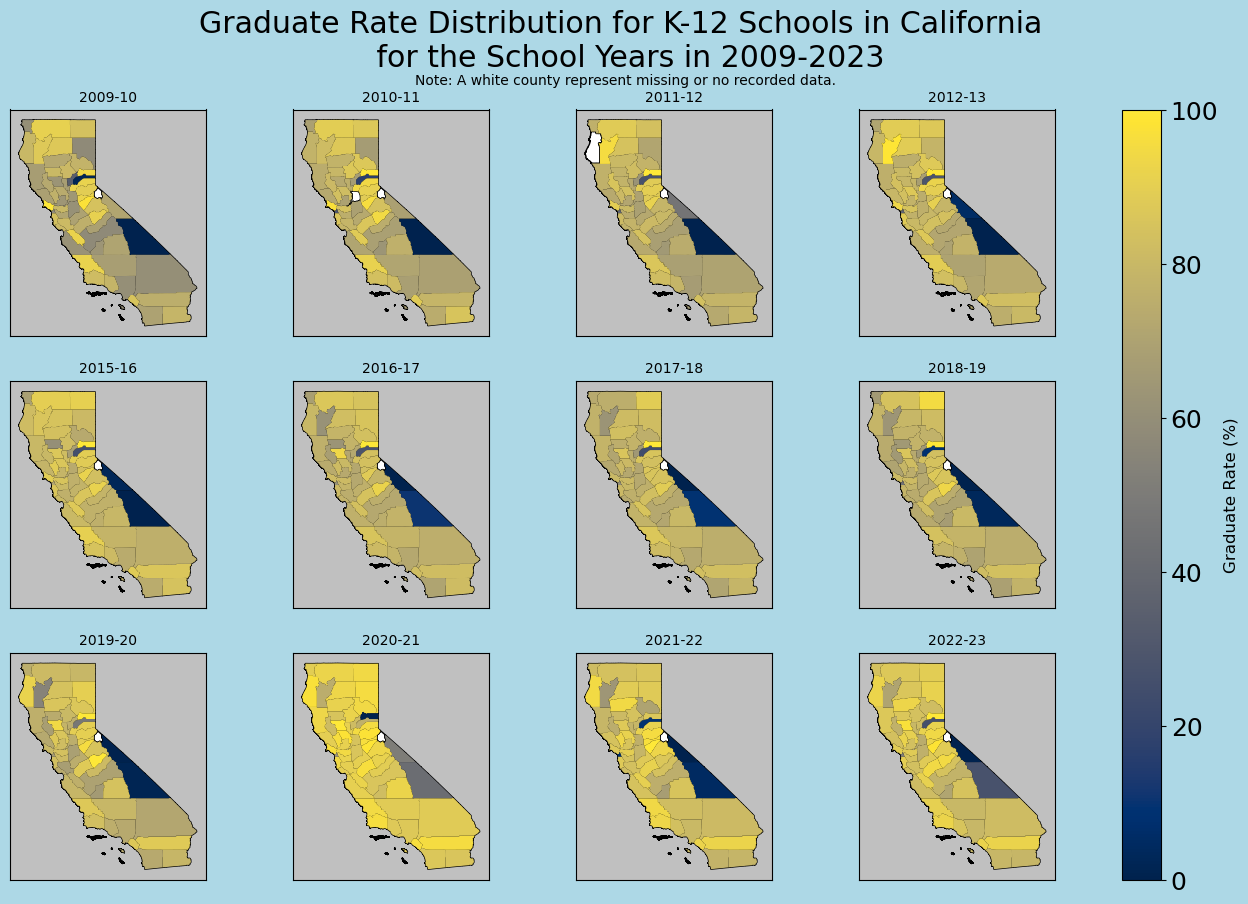

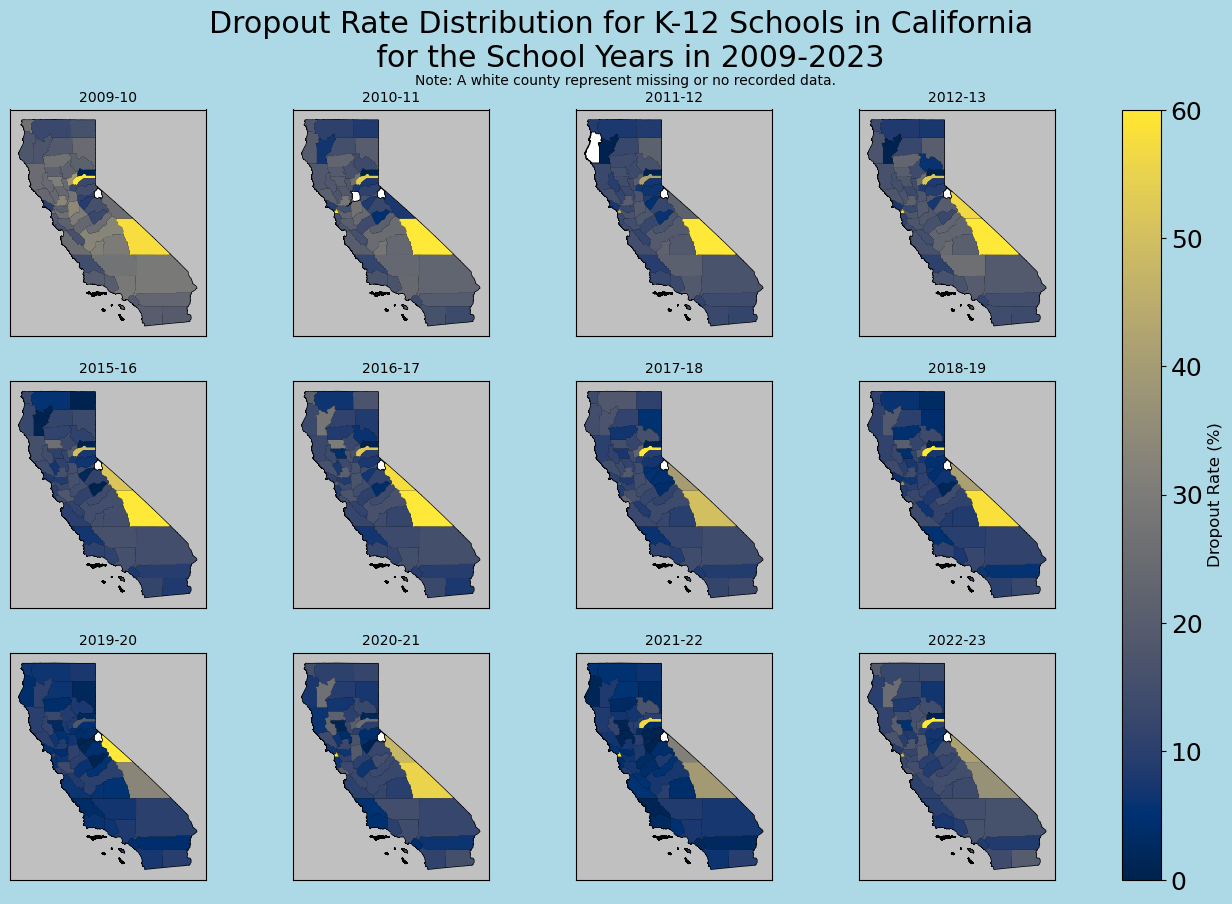

(None, None)

In [130]:
# project the graduation rates and dropout rates for Califrornia
cali_area_rates(),cali_area_rates(dropout_rates=True)

##### Insight:
Evidently, the colormap for both figures seems to contrast each other. Looking at the mapping of the graduation rates plot, it appears that graduation rates are relatively high across the majority of California, especially in the 2020-2021 school year. This is interesting considering the majority of classes were taught online due to the pandemic. Could this imply a correlation between online classes and a higher chance for individuals to graduate?

Observing the dropout rates plot, dropout rates were at their highest in the 2009-2010 school year for the majority of California. Also, there are two counties in the Central California that tend to have high dropout rates throughout the general timeframe when compared to the other counties in California.

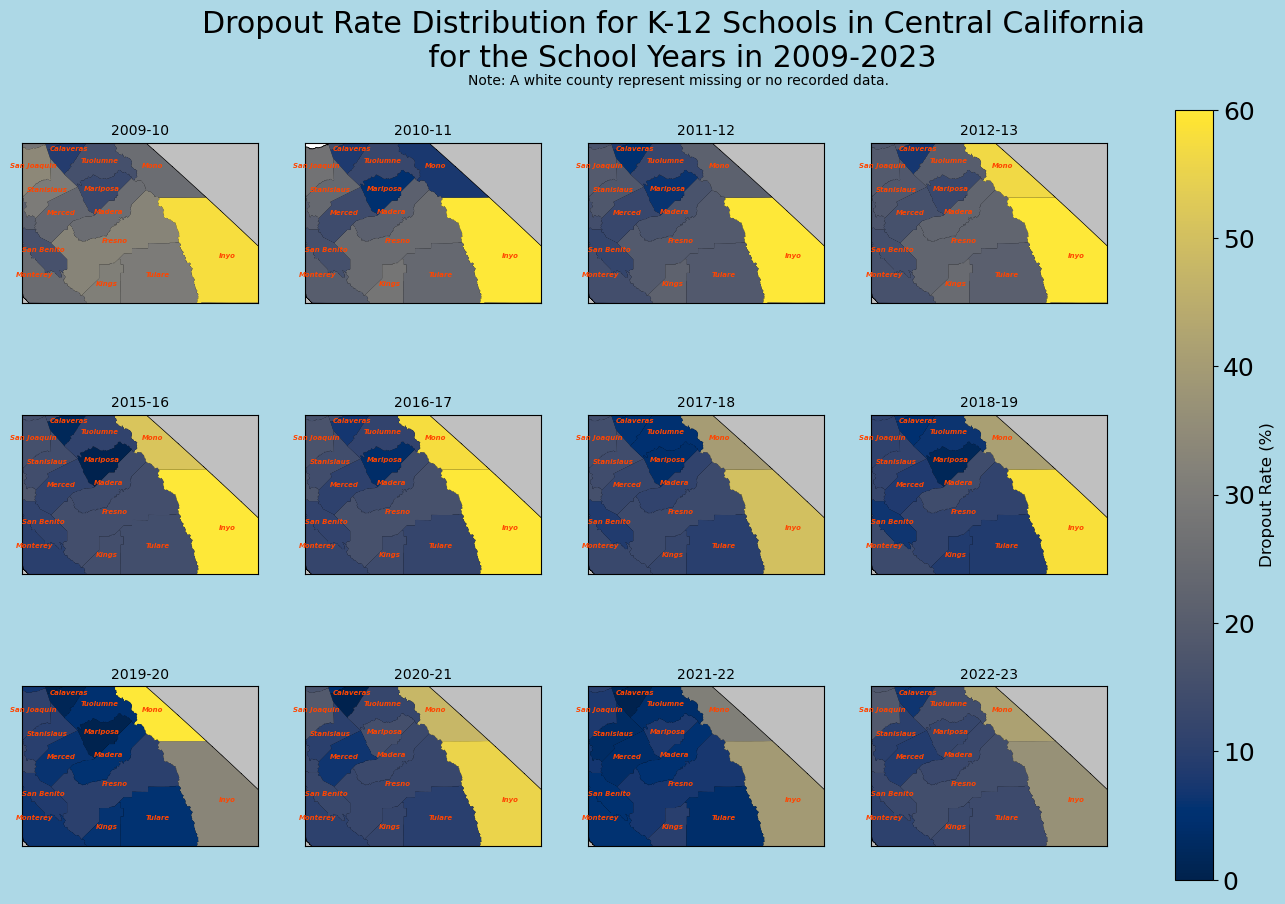

In [131]:
# project the dropout rates for Central California
cali_area_rates('Central California',dropout_rates=True)

##### Observation:
The names of the counties that showed a tendency to have a high dropout rate are Mono and Inyo. Inyo being the one to be consistent with a high dropout rate. Yet, it seems that in recent school years both counties have had their dropout rates decline to around 25%.

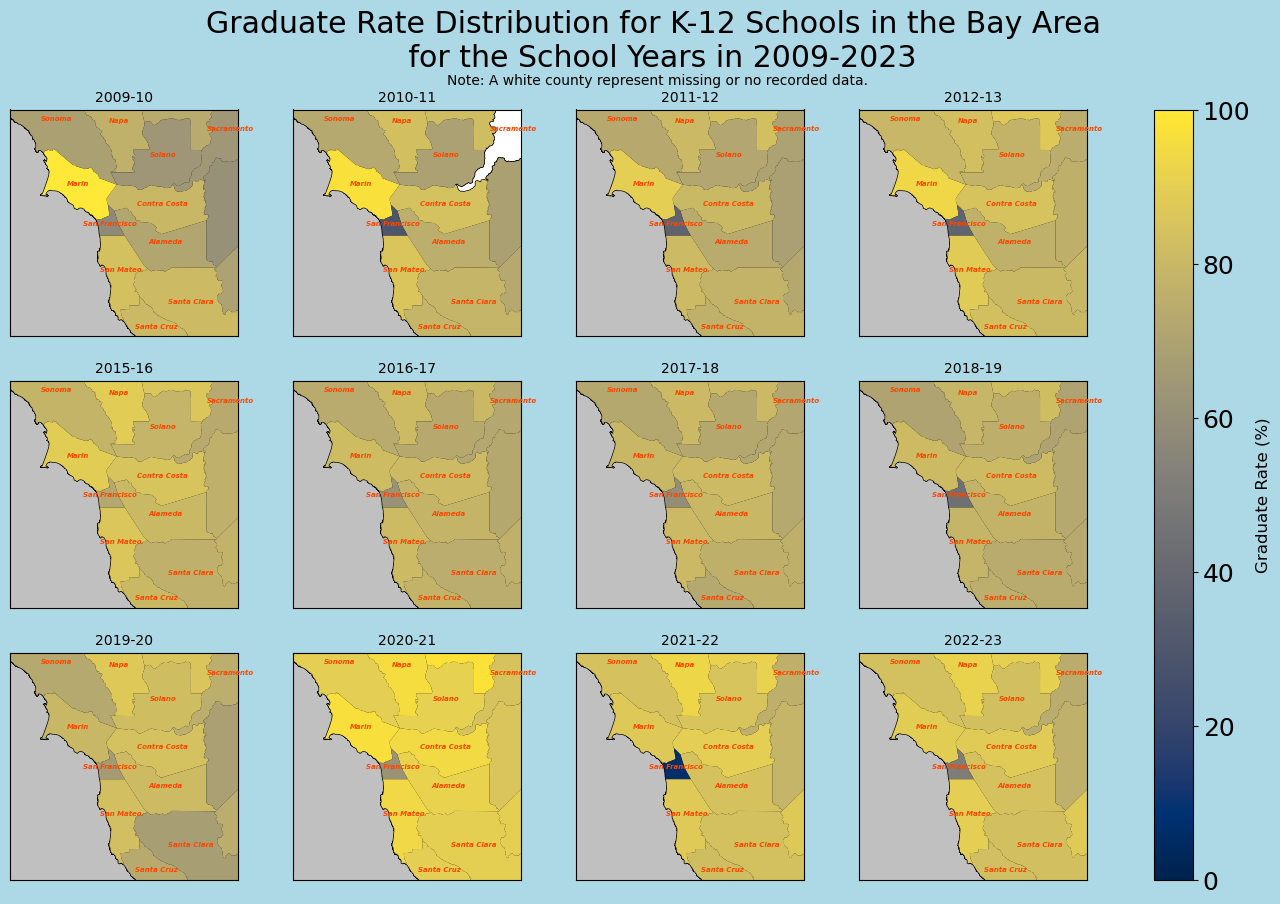

In [ ]:
# project the graduation rates and dropout rates for the Bay Area
cali_area_rates('Bay Area'),cali_area_rates('Bay Area',dropout_rates=True)

##### Observation:
Marin County tends to have a high graduation rate when compared to the counties in the Bay Area. In contrast, San Francisco tends to have a high dropout rate, notable for the first three years of the new decade. Overall, it seems that on average, the dropout rate for the Bay Area falls somewhere around 20%.

# Personal Reflection
- I learned an approach for dealing with Null values or absent data using:
    - `fillna`
    - conditionals
    - assigning a numerical Null value as zero in the context of performing arithmetic

- I discovered how to write more efficient code using:
    - conditional statements
    - optional parameters
    - data structures comprehension

- I found out more about how to make comprehensive and interpretable plots using:
    - colors 
    - facets and how to label each of them
    - inducing the grammar of graphics

- I gained a deeper understanding of the concept of 'scope' within conditionals, functions, and loops.
- I improved my comprehension skills, specifically for list and dictionary comprehensions.
- I became able to think as the audience or user of these functions when it came to writing the code and thinking of its output.
- Being able to automate outputs with categorical data. That is with functions and the educational institutions as the categorical variables.
- I started to understand the technical process behind making a color bar where I was able to have it as a general legend rather than each subplot having its own specific legend.
- I touched up on my ability to make a boundary box that is through working with xmin,xmax,ymin,ymax. Which in the context of geographical analysis allows to focus on specific region/area.